We’ll start by doing all necessary imports, and we’ll let our Jupyter Notebook know that it should display graphs and images in the notebook itself.

In [1]:
%matplotlib inline

#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import urllib
import sys
import os
import zipfile
from sklearn.metrics import *

The files we're about to use may take five minutes or more to download, so if you're following along by running the program in the corresponding notebook, feel free to start running the next few cells. In the meantime, let’s explore textual entailment in further detail.

In [2]:
glove_zip_file = "glove.6B.zip"
glove_vectors_file = "glove.6B.50d.txt"



In [3]:
from six.moves.urllib.request import urlretrieve
    
#large file - 862 MB
if (not os.path.isfile(glove_zip_file) and
    not os.path.isfile(glove_vectors_file)):
    urlretrieve ("http://nlp.stanford.edu/data/glove.6B.zip", 
                 glove_zip_file)

#medium-sized file - 94.6 MB
#if (not os.path.isfile(snli_zip_file) and
#    not os.path.isfile(snli_dev_file)):
#    urlretrieve ("https://nlp.stanford.edu/projects/snli/snli_1.0.zip", 
#                 snli_zip_file)

In [4]:
def unzip_single_file(zip_file_name, output_file_name):
    """
        If the outFile is already created, don't recreate
        If the outFile does not exist, create it from the zipFile
    """
    if not os.path.isfile(output_file_name):
        with open(output_file_name, 'wb') as out_file:
            with zipfile.ZipFile(zip_file_name) as zipped:
                for info in zipped.infolist():
                    if output_file_name in info.filename:
                        with zipped.open(info) as requested_file:
                            out_file.write(requested_file.read())
                            return

unzip_single_file(glove_zip_file, glove_vectors_file)
#unzip_single_file(snli_zip_file, snli_dev_file)
#unzip_single_file(snli_zip_file, snli_full_dataset_file)

---

Now that we have our GloVe vectors downloaded, we can load them into memory, deserializing the space separated format into a Python dictionary:

In [5]:
glove_wordmap = {}
with open(glove_vectors_file, "r", encoding="utf8") as glove:
    for line in glove:
        name, vector = tuple(line.split(" ", 1))
        glove_wordmap[name] = np.fromstring(vector, sep=" ")

---

Once we have our words, we need our input to contain entire sentences and process it through a neural network. Let's start with making the sequence:

In [6]:
def sentence2sequence(sentence):
    """
     
    - Turns an input sentence into an (n,d) matrix, 
        where n is the number of tokens in the sentence
        and d is the number of dimensions each word vector has.
    
      Tensorflow doesn't need to be used here, as simply
      turning the sentence into a sequence based off our 
      mapping does not need the computational power that
      Tensorflow provides. Normal Python suffices for this task.
    """
    tokens = sentence.lower().split(" ")
    rows = []
    words = []
    #Greedy search for tokens
    for token in tokens:
        i = len(token)
        while len(token) > 0 and i > 0:
            word = token[:i]
            if word in glove_wordmap:
                rows.append(glove_wordmap[word])
                words.append(word)
                token = token[i:]
                i = len(token)
            else:
                i = i-1
    return rows, words

To better visualize the word vectorization process, and to see what the computer sees when it looks at a sentence, we can represent the vectors as images. Each row represents a single word, and the columns represent individual dimensions of the vectorized word.  The vectorizations are trained in terms of relationships to other words, and so what the representations actually mean is ambiguous.  The computer can understand this vector language, and that’s the most important part to us. Generally speaking, two vectors that contain similar colors in the same positions represent words that are similar in meaning.


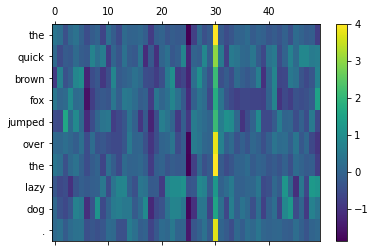

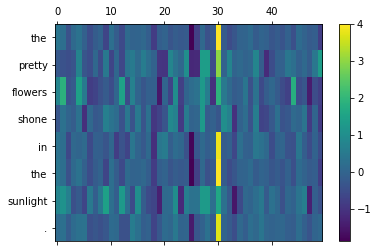

In [7]:
def visualize(sentence):
    rows, words = sentence2sequence(sentence)
    mat = np.vstack(rows)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    shown = ax.matshow(mat, aspect="auto")
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    fig.colorbar(shown)
    
    ax.set_yticklabels([""]+words)
    plt.show()
    
visualize("The quick brown fox jumped over the lazy dog.")
visualize("The pretty flowers shone in the sunlight.")

-----
Recurrent Neural Networks (also known as RNNs) are a sequence-learning tool for neural networks. This type of neural network has only one layer’s worth of hidden inputs, which is re-used for each input from the sequence, along with a “memory” that’s passed ahead to the next input’s calculations. These are calculated using matrix multiplication where the matrix indices are trained weights, just like they are in a fully-connected layer. 

The same calculations are repeated for each input in the sequence, meaning that a single “layer” of a recurrent neural network can be unrolled into many layers. In fact, there will be as many layers as there are inputs in the sequence. This allows the network to process a very complex sentence. TensorFlow includes its own implementation of a vanilla RNN cell, BasicRNNCell, which can be added to your TensorFlow graph as follows:

In [8]:
rnn_size = 64
rnn = tf.contrib.rnn.BasicRNNCell(rnn_size)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.


----

# Defining the constants for our network

Since we aren’t going to use a vanilla RNN layer in our network, let's clear out the graph and add an LSTM layer, which TensorFlow also includes by default. Since this is going to be the first part of our actual network, let's also define all the constants we'll need for the network, which we'll talk about as they come up:

In [9]:
#Constants setup
max_hypothesis_length, max_evidence_length = 15, 15
batch_size, vector_size, hidden_size = 30, 50, 100

lstm_size = hidden_size

weight_decay = 0.0001

learning_rate = 0.5

input_p, output_p = 0.5, 0.5

training_iterations_count = 100000


display_step = 10

def score_setup(row):
    convert_dict = {
      'ENTAILMENT': 0,
      'NEUTRAL': 1,
      'CONTRADICTION': 2
    }
    score = np.zeros((3,))
    #for x in range(1,6):
    tag = row["entailment_judgment"]
    if tag in convert_dict: 
        score[convert_dict[tag]] += 1
    return score / (1.0*np.sum(score))

def fit_to_size(matrix, shape):
    res = np.zeros(shape)
    slices = [slice(0,min(dim,shape[e])) for e, dim in enumerate(matrix.shape)]
    res[slices] = matrix[slices]
    return res


In [10]:
def split_data_into_scores():
    import csv
    with open("sick_dataset_train.txt","r") as data:
        train = csv.DictReader(data, delimiter='\t')
        evi_sentences = []
        hyp_sentences = []
        labels = []
        scores = []
        for row in train:
            hyp_sentences.append(np.vstack(
                    sentence2sequence(row["sentence_B"].lower())[0]))
            evi_sentences.append(np.vstack(
                    sentence2sequence(row["sentence_A"].lower())[0]))
            labels.append(row["entailment_judgment"])
            scores.append(score_setup(row))
        
        hyp_sentences = np.stack([fit_to_size(x, (max_hypothesis_length, vector_size))
                          for x in hyp_sentences])
        evi_sentences = np.stack([fit_to_size(x, (max_evidence_length, vector_size))
                          for x in evi_sentences])
                                 
        return (hyp_sentences, evi_sentences), labels, np.array(scores)
    
data_feature_list, correct_values, correct_scores = split_data_into_scores()

l_h, l_e = max_hypothesis_length, max_evidence_length
N, D, H = batch_size, vector_size, hidden_size
l_seq = l_h + l_e


C:\Users\Shilpu\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


We'll also reset the graph to not include the RNN cell we added earlier, since we won't be using that for this network:



In [11]:
tf.reset_default_graph()

With both those out of the way, we can define our LSTM using TensorFlow as follows:

In [12]:
lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.


The loss of certain pieces of crucial memory means that complicated relationships required for first order logic have a harder time forming with dropout, and so for our LSTM layer we’ll skip using dropout on internal gates, instead using it on everything else. Thankfully, this is the default implementation of Tensorflow’s DropoutWrapper for recurrent layers:


In [13]:
lstm_drop =  tf.contrib.rnn.DropoutWrapper(lstm, input_p, output_p)

----

With all the explanations out of the way, we can finish up our model. The first step is tokenizing and using our GloVe dictionary to turn the two input sentences into a single sequence of vectors. Since we can’t effectively use dropout on information that gets passed within an LSTM, we’ll use dropout on features from words, and on final output instead -- effectively using dropout on the first and last layers from the unrolled LSTM network portions. 

The final output from the LSTMs will be passed into a set of fully connected layers, and then from that we’ll get a single real-valued score that indicates how strong each of the kinds of entailment are, which we use to select our final result and our confidence in that result.

In [14]:
# N: The number of elements in each of our batches, 
#   which we use to train subsets of data for efficiency's sake.
# l_h: The maximum length of a hypothesis, or the second sentence.  This is
#   used because training an RNN is extraordinarily difficult without 
#   rolling it out to a fixed length.
# l_e: The maximum length of evidence, the first sentence.  This is used
#   because training an RNN is extraordinarily difficult without 
#   rolling it out to a fixed length.
# D: The size of our used GloVe or other vectors.
hyp = tf.placeholder(tf.float32, [N, l_h, D], 'hypothesis')
evi = tf.placeholder(tf.float32, [N, l_e, D], 'evidence')
y = tf.placeholder(tf.float32, [N, 3], 'label')
# hyp: Where the hypotheses will be stored during training.
# evi: Where the evidences will be stored during training.
# y: Where correct scores will be stored during training.

# lstm_size: the size of the gates in the LSTM, 
#    as in the first LSTM layer's initialization.
lstm_back = tf.contrib.rnn.BasicLSTMCell(lstm_size)
# lstm_back:  The LSTM used for looking backwards 
#   through the sentences, similar to lstm.

# input_p: the probability that inputs to the LSTM will be retained at each
#   iteration of dropout.
# output_p: the probability that outputs from the LSTM will be retained at 
#   each iteration of dropout.
lstm_drop_back = tf.contrib.rnn.DropoutWrapper(lstm_back, input_p, output_p)
# lstm_drop_back:  A dropout wrapper for lstm_back, like lstm_drop.


fc_initializer = tf.random_normal_initializer(stddev=0.1) 
# fc_initializer: initial values for the fully connected layer's weights.
# hidden_size: the size of the outputs from each lstm layer.  
#   Multiplied by 2 to account for the two LSTMs.
fc_weight = tf.get_variable('fc_weight', [2*hidden_size, 3], 
                            initializer = fc_initializer)
# fc_weight: Storage for the fully connected layer's weights.
fc_bias = tf.get_variable('bias', [3])
# fc_bias: Storage for the fully connected layer's bias.

# tf.GraphKeys.REGULARIZATION_LOSSES:  A key to a collection in the graph
#   designated for losses due to regularization.
#   In this case, this portion of loss is regularization on the weights
#   for the fully connected layer.
tf.add_to_collection(tf.GraphKeys.REGULARIZATION_LOSSES, 
                     tf.nn.l2_loss(fc_weight)) 

x = tf.concat([hyp, evi], 1) # N, (Lh+Le), d
# Permuting batch_size and n_steps
x = tf.transpose(x, [1, 0, 2]) # (Le+Lh), N, d
# Reshaping to (n_steps*batch_size, n_input)
x = tf.reshape(x, [-1, vector_size]) # (Le+Lh)*N, d
# Split to get a list of 'n_steps' tensors of shape (batch_size, n_input)
x = tf.split(x, l_seq,)

# x: the inputs to the bidirectional_rnn


# tf.contrib.rnn.static_bidirectional_rnn: Runs the input through
#   two recurrent networks, one that runs the inputs forward and one
#   that runs the inputs in reversed order, combining the outputs.
rnn_outputs, _, _ = tf.contrib.rnn.static_bidirectional_rnn(lstm, lstm_back,
                                                            x, dtype=tf.float32)
# rnn_outputs: the list of LSTM outputs, as a list. 
#   What we want is the latest output, rnn_outputs[-1]

classification_scores = tf.matmul(rnn_outputs[-1], fc_weight) + fc_bias
# The scores are relative certainties for how likely the output matches
#   a certain entailment: 
#     0: Positive entailment
#     1: Neutral entailment
#     2: Negative entailment

Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell, unroll=True))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In order to test the accuracy and begin to add in optimization constraints, we need to show TensorFlow how to calculate the accuracy, or -- the percentage of correctly predicted labels.

We also need to determine a loss, to show how poorly the network is doing. Since we have both classification scores and optimal scores, the choice here is using a variation on softmax loss from Tensorflow: tf.nn.softmax_cross_entropy_with_logits. We add in regularization losses to help with overfitting, and then prepare an optimizer to learn how to reduce the loss.

In [15]:
with tf.variable_scope('Accuracy'):
    predicts = tf.cast(tf.argmax(classification_scores, 1), 'int32')
    y_label = tf.cast(tf.argmax(y, 1), 'int32')
    corrects = tf.equal(predicts, y_label)
    num_corrects = tf.reduce_sum(tf.cast(corrects, tf.float32))
    accuracy = tf.reduce_mean(tf.cast(corrects, tf.float32))

with tf.variable_scope("loss"):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
        logits = classification_scores, labels = y)
    loss = tf.reduce_mean(cross_entropy)
    total_loss = loss + weight_decay * tf.add_n(
        tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))

optimizer = tf.train.GradientDescentOptimizer(learning_rate)

opt_op = optimizer.minimize(total_loss)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



Finally, we can train the network! If you installed TQDM, you can use it to keep track of progress as the network trains.


In [16]:
# Initialize variables
init = tf.global_variables_initializer()

# Use TQDM if installed
tqdm_installed = False
try:
    from tqdm import tqdm
    tqdm_installed = True
except:
    pass

# Launch the Tensorflow session
sess = tf.Session()
sess.run(init)

# training_iterations_count: The number of data pieces to train on in total
# batch_size: The number of data pieces per batch
training_iterations = range(0,training_iterations_count,batch_size)
if tqdm_installed:
    # Add a progress bar if TQDM is installed
    training_iterations = tqdm(training_iterations)

for i in training_iterations:

    # Select indices for a random data subset
    batch = np.random.randint(data_feature_list[0].shape[0], size=batch_size)
    
    # Use the selected subset indices to initialize the graph's 
    #   placeholder values
    hyps, evis, ys = (data_feature_list[0][batch,:],
                      data_feature_list[1][batch,:],
                      correct_scores[batch])
    
    # Run the optimization with these initialized values
    sess.run([opt_op], feed_dict={hyp: hyps, evi: evis, y: ys})
    # display_step: how often the accuracy and loss should 
    #   be tested and displayed.
    if (i/batch_size) % display_step == 0:
        # Calculate batch accuracy
        acc = sess.run(accuracy, feed_dict={hyp: hyps, evi: evis, y: ys})
        # Calculate batch loss
        tmp_loss = sess.run(loss, feed_dict={hyp: hyps, evi: evis, y: ys})
        # Display results
        print("Iter " + str(i/batch_size) + ", Minibatch Loss= " + \
              "{:.6f}".format(tmp_loss) + ", Training Accuracy= " + \
              "{:.5f}".format(acc))

  0%|                                                                                                                                                                                    | 0/3334 [00:00<?, ?it/s]

Iter 0.0, Minibatch Loss= 0.998392, Training Accuracy= 0.53333


  0%|▌                                                                                                                                                                          | 10/3334 [00:02<47:45,  1.16it/s]

Iter 10.0, Minibatch Loss= 0.976623, Training Accuracy= 0.56667


  1%|▉                                                                                                                                                                          | 19/3334 [00:03<17:44,  3.11it/s]

Iter 20.0, Minibatch Loss= 0.837379, Training Accuracy= 0.66667


  1%|█▍                                                                                                                                                                         | 29/3334 [00:03<07:25,  7.41it/s]

Iter 30.0, Minibatch Loss= 1.008137, Training Accuracy= 0.50000


  1%|█▉                                                                                                                                                                         | 38/3334 [00:03<03:57, 13.87it/s]

Iter 40.0, Minibatch Loss= 0.898047, Training Accuracy= 0.66667


  1%|██▍                                                                                                                                                                        | 48/3334 [00:04<02:38, 20.74it/s]

Iter 50.0, Minibatch Loss= 1.060093, Training Accuracy= 0.46667


  2%|███                                                                                                                                                                        | 59/3334 [00:04<02:14, 24.28it/s]

Iter 60.0, Minibatch Loss= 0.905909, Training Accuracy= 0.60000


  2%|███▍                                                                                                                                                                       | 68/3334 [00:05<02:08, 25.39it/s]

Iter 70.0, Minibatch Loss= 0.959400, Training Accuracy= 0.56667


  2%|████                                                                                                                                                                       | 79/3334 [00:05<01:59, 27.31it/s]

Iter 80.0, Minibatch Loss= 0.954082, Training Accuracy= 0.50000


  3%|████▌                                                                                                                                                                      | 90/3334 [00:05<01:56, 27.95it/s]

Iter 90.0, Minibatch Loss= 1.009696, Training Accuracy= 0.50000


  3%|█████                                                                                                                                                                     | 100/3334 [00:06<02:04, 26.07it/s]

Iter 100.0, Minibatch Loss= 0.928047, Training Accuracy= 0.63333


  3%|█████▍                                                                                                                                                                    | 106/3334 [00:06<02:54, 18.49it/s]

Iter 110.0, Minibatch Loss= 1.008109, Training Accuracy= 0.50000


  4%|██████                                                                                                                                                                    | 118/3334 [00:07<02:05, 25.63it/s]

Iter 120.0, Minibatch Loss= 1.029919, Training Accuracy= 0.43333


  4%|██████▍                                                                                                                                                                   | 127/3334 [00:07<02:09, 24.85it/s]

Iter 130.0, Minibatch Loss= 0.908418, Training Accuracy= 0.50000


  4%|███████                                                                                                                                                                   | 138/3334 [00:07<01:56, 27.55it/s]

Iter 140.0, Minibatch Loss= 0.974841, Training Accuracy= 0.50000


  4%|███████▋                                                                                                                                                                  | 150/3334 [00:08<02:08, 24.77it/s]

Iter 150.0, Minibatch Loss= 0.775385, Training Accuracy= 0.66667


  5%|████████▏                                                                                                                                                                 | 160/3334 [00:08<02:02, 25.87it/s]

Iter 160.0, Minibatch Loss= 0.918255, Training Accuracy= 0.60000


  5%|████████▋                                                                                                                                                                 | 170/3334 [00:09<01:49, 28.91it/s]

Iter 170.0, Minibatch Loss= 1.077259, Training Accuracy= 0.43333


  5%|█████████▏                                                                                                                                                                | 179/3334 [00:09<02:02, 25.74it/s]

Iter 180.0, Minibatch Loss= 1.119960, Training Accuracy= 0.33333


  6%|█████████▌                                                                                                                                                                | 188/3334 [00:09<02:11, 23.86it/s]

Iter 190.0, Minibatch Loss= 0.852450, Training Accuracy= 0.66667


  6%|██████████▏                                                                                                                                                               | 199/3334 [00:10<01:48, 28.77it/s]

Iter 200.0, Minibatch Loss= 0.983773, Training Accuracy= 0.56667


  6%|██████████▌                                                                                                                                                               | 207/3334 [00:10<01:47, 29.21it/s]

Iter 210.0, Minibatch Loss= 0.913101, Training Accuracy= 0.53333


  7%|███████████▏                                                                                                                                                              | 219/3334 [00:10<01:34, 32.91it/s]

Iter 220.0, Minibatch Loss= 0.822738, Training Accuracy= 0.66667


  7%|███████████▌                                                                                                                                                              | 227/3334 [00:10<01:32, 33.74it/s]

Iter 230.0, Minibatch Loss= 1.027102, Training Accuracy= 0.43333


  7%|████████████▏                                                                                                                                                             | 239/3334 [00:11<01:28, 34.95it/s]

Iter 240.0, Minibatch Loss= 0.911505, Training Accuracy= 0.60000


  7%|████████████▌                                                                                                                                                             | 247/3334 [00:11<01:31, 33.78it/s]

Iter 250.0, Minibatch Loss= 0.896138, Training Accuracy= 0.53333


  8%|█████████████▏                                                                                                                                                            | 259/3334 [00:11<01:34, 32.69it/s]

Iter 260.0, Minibatch Loss= 0.876497, Training Accuracy= 0.63333


  8%|█████████████▌                                                                                                                                                            | 267/3334 [00:12<01:32, 33.23it/s]

Iter 270.0, Minibatch Loss= 0.682789, Training Accuracy= 0.76667


  8%|██████████████▏                                                                                                                                                           | 279/3334 [00:12<01:34, 32.45it/s]

Iter 280.0, Minibatch Loss= 0.844432, Training Accuracy= 0.70000


  9%|██████████████▋                                                                                                                                                           | 287/3334 [00:12<01:36, 31.55it/s]

Iter 290.0, Minibatch Loss= 0.806985, Training Accuracy= 0.70000


  9%|███████████████▏                                                                                                                                                          | 299/3334 [00:13<01:31, 33.20it/s]

Iter 300.0, Minibatch Loss= 0.819986, Training Accuracy= 0.73333


  9%|███████████████▋                                                                                                                                                          | 308/3334 [00:13<01:34, 32.11it/s]

Iter 310.0, Minibatch Loss= 0.766185, Training Accuracy= 0.66667


 10%|████████████████▎                                                                                                                                                         | 320/3334 [00:13<01:31, 33.04it/s]

Iter 320.0, Minibatch Loss= 0.862019, Training Accuracy= 0.63333


 10%|████████████████▋                                                                                                                                                         | 328/3334 [00:14<01:41, 29.72it/s]

Iter 330.0, Minibatch Loss= 0.906629, Training Accuracy= 0.50000


 10%|█████████████████▎                                                                                                                                                        | 340/3334 [00:14<01:29, 33.37it/s]

Iter 340.0, Minibatch Loss= 0.939905, Training Accuracy= 0.60000


 10%|█████████████████▋                                                                                                                                                        | 348/3334 [00:14<01:44, 28.54it/s]

Iter 350.0, Minibatch Loss= 0.893952, Training Accuracy= 0.60000


 11%|██████████████████▎                                                                                                                                                       | 358/3334 [00:15<01:58, 25.15it/s]

Iter 360.0, Minibatch Loss= 0.973249, Training Accuracy= 0.56667


 11%|██████████████████▊                                                                                                                                                       | 370/3334 [00:15<01:56, 25.38it/s]

Iter 370.0, Minibatch Loss= 0.771353, Training Accuracy= 0.60000


 11%|███████████████████▎                                                                                                                                                      | 379/3334 [00:16<02:13, 22.06it/s]

Iter 380.0, Minibatch Loss= 0.903788, Training Accuracy= 0.53333


 12%|███████████████████▉                                                                                                                                                      | 390/3334 [00:16<01:53, 26.05it/s]

Iter 390.0, Minibatch Loss= 1.024041, Training Accuracy= 0.53333


 12%|████████████████████▍                                                                                                                                                     | 400/3334 [00:16<01:57, 24.93it/s]

Iter 400.0, Minibatch Loss= 0.746524, Training Accuracy= 0.70000


 12%|████████████████████▉                                                                                                                                                     | 410/3334 [00:17<01:47, 27.20it/s]

Iter 410.0, Minibatch Loss= 0.945252, Training Accuracy= 0.50000


 13%|█████████████████████▎                                                                                                                                                    | 417/3334 [00:17<01:39, 29.26it/s]

Iter 420.0, Minibatch Loss= 0.964173, Training Accuracy= 0.53333


 13%|█████████████████████▊                                                                                                                                                    | 427/3334 [00:17<01:43, 28.06it/s]

Iter 430.0, Minibatch Loss= 0.810216, Training Accuracy= 0.63333


 13%|██████████████████████▍                                                                                                                                                   | 439/3334 [00:18<01:38, 29.27it/s]

Iter 440.0, Minibatch Loss= 0.855051, Training Accuracy= 0.56667


 13%|██████████████████████▊                                                                                                                                                   | 447/3334 [00:18<01:36, 29.90it/s]

Iter 450.0, Minibatch Loss= 0.727161, Training Accuracy= 0.66667


 14%|███████████████████████▍                                                                                                                                                  | 459/3334 [00:18<01:39, 28.94it/s]

Iter 460.0, Minibatch Loss= 0.874091, Training Accuracy= 0.56667


 14%|███████████████████████▉                                                                                                                                                  | 470/3334 [00:19<01:36, 29.81it/s]

Iter 470.0, Minibatch Loss= 0.981141, Training Accuracy= 0.66667


 14%|████████████████████████▎                                                                                                                                                 | 477/3334 [00:19<01:44, 27.44it/s]

Iter 480.0, Minibatch Loss= 0.780595, Training Accuracy= 0.66667


 15%|████████████████████████▉                                                                                                                                                 | 489/3334 [00:20<01:32, 30.71it/s]

Iter 490.0, Minibatch Loss= 0.960446, Training Accuracy= 0.56667


 15%|█████████████████████████▎                                                                                                                                                | 497/3334 [00:20<01:31, 30.88it/s]

Iter 500.0, Minibatch Loss= 0.757308, Training Accuracy= 0.73333


 15%|█████████████████████████▉                                                                                                                                                | 508/3334 [00:20<01:46, 26.42it/s]

Iter 510.0, Minibatch Loss= 0.954033, Training Accuracy= 0.50000


 16%|██████████████████████████▍                                                                                                                                               | 518/3334 [00:21<01:47, 26.11it/s]

Iter 520.0, Minibatch Loss= 0.892197, Training Accuracy= 0.53333


 16%|██████████████████████████▉                                                                                                                                               | 529/3334 [00:21<01:38, 28.43it/s]

Iter 530.0, Minibatch Loss= 0.927168, Training Accuracy= 0.56667


 16%|███████████████████████████▍                                                                                                                                              | 539/3334 [00:21<01:37, 28.74it/s]

Iter 540.0, Minibatch Loss= 0.889670, Training Accuracy= 0.56667


 16%|███████████████████████████▉                                                                                                                                              | 549/3334 [00:22<01:41, 27.34it/s]

Iter 550.0, Minibatch Loss= 0.973026, Training Accuracy= 0.56667


 17%|████████████████████████████▌                                                                                                                                             | 560/3334 [00:22<01:31, 30.38it/s]

Iter 560.0, Minibatch Loss= 1.046692, Training Accuracy= 0.46667


 17%|█████████████████████████████                                                                                                                                             | 569/3334 [00:22<01:29, 30.84it/s]

Iter 570.0, Minibatch Loss= 0.905271, Training Accuracy= 0.56667


 17%|█████████████████████████████▍                                                                                                                                            | 577/3334 [00:23<01:29, 30.72it/s]

Iter 580.0, Minibatch Loss= 0.944229, Training Accuracy= 0.53333


 18%|██████████████████████████████                                                                                                                                            | 590/3334 [00:23<01:26, 31.69it/s]

Iter 590.0, Minibatch Loss= 0.886607, Training Accuracy= 0.56667


 18%|██████████████████████████████▍                                                                                                                                           | 598/3334 [00:23<01:22, 33.07it/s]

Iter 600.0, Minibatch Loss= 0.915765, Training Accuracy= 0.50000


 18%|███████████████████████████████                                                                                                                                           | 610/3334 [00:24<01:25, 31.88it/s]

Iter 610.0, Minibatch Loss= 0.883084, Training Accuracy= 0.63333


 19%|███████████████████████████████▌                                                                                                                                          | 618/3334 [00:24<01:26, 31.39it/s]

Iter 620.0, Minibatch Loss= 0.802896, Training Accuracy= 0.63333


 19%|████████████████████████████████                                                                                                                                          | 630/3334 [00:24<01:20, 33.45it/s]

Iter 630.0, Minibatch Loss= 0.831395, Training Accuracy= 0.70000


 19%|████████████████████████████████▌                                                                                                                                         | 638/3334 [00:25<01:34, 28.50it/s]

Iter 640.0, Minibatch Loss= 0.743947, Training Accuracy= 0.66667


 19%|█████████████████████████████████                                                                                                                                         | 649/3334 [00:25<01:34, 28.32it/s]

Iter 650.0, Minibatch Loss= 0.753642, Training Accuracy= 0.50000


 20%|█████████████████████████████████▋                                                                                                                                        | 660/3334 [00:25<01:30, 29.43it/s]

Iter 660.0, Minibatch Loss= 0.894683, Training Accuracy= 0.60000


 20%|██████████████████████████████████                                                                                                                                        | 668/3334 [00:26<01:30, 29.46it/s]

Iter 670.0, Minibatch Loss= 0.783518, Training Accuracy= 0.63333


 20%|██████████████████████████████████▋                                                                                                                                       | 680/3334 [00:26<01:26, 30.56it/s]

Iter 680.0, Minibatch Loss= 0.701914, Training Accuracy= 0.73333


 21%|███████████████████████████████████                                                                                                                                       | 688/3334 [00:26<01:21, 32.65it/s]

Iter 690.0, Minibatch Loss= 1.007310, Training Accuracy= 0.50000


 21%|███████████████████████████████████▋                                                                                                                                      | 700/3334 [00:27<01:26, 30.38it/s]

Iter 700.0, Minibatch Loss= 0.908777, Training Accuracy= 0.53333


 21%|████████████████████████████████████                                                                                                                                      | 708/3334 [00:27<01:26, 30.24it/s]

Iter 710.0, Minibatch Loss= 0.765339, Training Accuracy= 0.56667


 22%|████████████████████████████████████▋                                                                                                                                     | 720/3334 [00:27<01:19, 33.08it/s]

Iter 720.0, Minibatch Loss= 0.947058, Training Accuracy= 0.56667


 22%|█████████████████████████████████████                                                                                                                                     | 728/3334 [00:28<01:19, 32.85it/s]

Iter 730.0, Minibatch Loss= 0.563717, Training Accuracy= 0.76667


 22%|█████████████████████████████████████▋                                                                                                                                    | 740/3334 [00:28<01:18, 32.90it/s]

Iter 740.0, Minibatch Loss= 0.886119, Training Accuracy= 0.50000


 22%|██████████████████████████████████████▏                                                                                                                                   | 748/3334 [00:28<01:21, 31.69it/s]

Iter 750.0, Minibatch Loss= 0.813412, Training Accuracy= 0.63333


 23%|██████████████████████████████████████▊                                                                                                                                   | 760/3334 [00:29<01:16, 33.50it/s]

Iter 760.0, Minibatch Loss= 0.666211, Training Accuracy= 0.76667


 23%|███████████████████████████████████████▏                                                                                                                                  | 768/3334 [00:29<01:20, 31.96it/s]

Iter 770.0, Minibatch Loss= 0.826890, Training Accuracy= 0.53333


 23%|███████████████████████████████████████▊                                                                                                                                  | 780/3334 [00:29<01:21, 31.43it/s]

Iter 780.0, Minibatch Loss= 0.753494, Training Accuracy= 0.73333


 24%|████████████████████████████████████████▏                                                                                                                                 | 788/3334 [00:29<01:22, 30.79it/s]

Iter 790.0, Minibatch Loss= 0.807861, Training Accuracy= 0.66667


 24%|████████████████████████████████████████▊                                                                                                                                 | 800/3334 [00:30<01:19, 31.83it/s]

Iter 800.0, Minibatch Loss= 0.812020, Training Accuracy= 0.63333


 24%|█████████████████████████████████████████▏                                                                                                                                | 807/3334 [00:30<01:37, 26.05it/s]

Iter 810.0, Minibatch Loss= 0.708254, Training Accuracy= 0.70000


 25%|█████████████████████████████████████████▊                                                                                                                                | 819/3334 [00:31<01:25, 29.49it/s]

Iter 820.0, Minibatch Loss= 0.905200, Training Accuracy= 0.60000


 25%|██████████████████████████████████████████▎                                                                                                                               | 830/3334 [00:31<01:27, 28.47it/s]

Iter 830.0, Minibatch Loss= 0.817242, Training Accuracy= 0.70000


 25%|██████████████████████████████████████████▊                                                                                                                               | 840/3334 [00:31<01:38, 25.28it/s]

Iter 840.0, Minibatch Loss= 0.780055, Training Accuracy= 0.63333


 25%|███████████████████████████████████████████▏                                                                                                                              | 847/3334 [00:32<01:31, 27.14it/s]

Iter 850.0, Minibatch Loss= 0.791968, Training Accuracy= 0.60000


 26%|███████████████████████████████████████████▊                                                                                                                              | 859/3334 [00:32<01:26, 28.70it/s]

Iter 860.0, Minibatch Loss= 0.796953, Training Accuracy= 0.60000


 26%|████████████████████████████████████████████▏                                                                                                                             | 867/3334 [00:32<01:23, 29.42it/s]

Iter 870.0, Minibatch Loss= 0.681621, Training Accuracy= 0.70000


 26%|████████████████████████████████████████████▊                                                                                                                             | 879/3334 [00:33<01:15, 32.54it/s]

Iter 880.0, Minibatch Loss= 0.801893, Training Accuracy= 0.50000


 27%|█████████████████████████████████████████████▏                                                                                                                            | 887/3334 [00:33<01:18, 31.18it/s]

Iter 890.0, Minibatch Loss= 0.792956, Training Accuracy= 0.56667


 27%|█████████████████████████████████████████████▊                                                                                                                            | 899/3334 [00:33<01:22, 29.47it/s]

Iter 900.0, Minibatch Loss= 0.792515, Training Accuracy= 0.63333


 27%|██████████████████████████████████████████████▏                                                                                                                           | 907/3334 [00:34<01:19, 30.41it/s]

Iter 910.0, Minibatch Loss= 0.645226, Training Accuracy= 0.70000


 28%|██████████████████████████████████████████████▊                                                                                                                           | 919/3334 [00:34<01:26, 27.92it/s]

Iter 920.0, Minibatch Loss= 0.678808, Training Accuracy= 0.60000


 28%|███████████████████████████████████████████████▍                                                                                                                          | 930/3334 [00:34<01:23, 28.88it/s]

Iter 930.0, Minibatch Loss= 0.690406, Training Accuracy= 0.53333


 28%|███████████████████████████████████████████████▊                                                                                                                          | 937/3334 [00:35<01:24, 28.33it/s]

Iter 940.0, Minibatch Loss= 0.748666, Training Accuracy= 0.63333


 28%|████████████████████████████████████████████████▍                                                                                                                         | 949/3334 [00:35<01:23, 28.67it/s]

Iter 950.0, Minibatch Loss= 0.690881, Training Accuracy= 0.56667


 29%|████████████████████████████████████████████████▉                                                                                                                         | 960/3334 [00:35<01:16, 31.21it/s]

Iter 960.0, Minibatch Loss= 0.741796, Training Accuracy= 0.60000


 29%|█████████████████████████████████████████████████▍                                                                                                                        | 969/3334 [00:36<01:16, 30.87it/s]

Iter 970.0, Minibatch Loss= 0.794981, Training Accuracy= 0.56667


 29%|█████████████████████████████████████████████████▊                                                                                                                        | 977/3334 [00:36<01:14, 31.63it/s]

Iter 980.0, Minibatch Loss= 0.729895, Training Accuracy= 0.70000


 30%|██████████████████████████████████████████████████▍                                                                                                                       | 989/3334 [00:36<01:19, 29.45it/s]

Iter 990.0, Minibatch Loss= 0.915559, Training Accuracy= 0.43333


 30%|██████████████████████████████████████████████████▊                                                                                                                       | 997/3334 [00:37<01:18, 29.75it/s]

Iter 1000.0, Minibatch Loss= 0.698291, Training Accuracy= 0.56667


 30%|███████████████████████████████████████████████████▏                                                                                                                     | 1009/3334 [00:37<01:14, 31.21it/s]

Iter 1010.0, Minibatch Loss= 0.660203, Training Accuracy= 0.70000


 31%|███████████████████████████████████████████████████▌                                                                                                                     | 1017/3334 [00:37<01:15, 30.52it/s]

Iter 1020.0, Minibatch Loss= 0.726800, Training Accuracy= 0.56667


 31%|████████████████████████████████████████████████████▏                                                                                                                    | 1029/3334 [00:38<01:14, 31.07it/s]

Iter 1030.0, Minibatch Loss= 0.788311, Training Accuracy= 0.53333


 31%|████████████████████████████████████████████████████▌                                                                                                                    | 1038/3334 [00:38<01:17, 29.65it/s]

Iter 1040.0, Minibatch Loss= 0.713620, Training Accuracy= 0.46667


 31%|█████████████████████████████████████████████████████▏                                                                                                                   | 1050/3334 [00:38<01:13, 30.91it/s]

Iter 1050.0, Minibatch Loss= 0.703396, Training Accuracy= 0.53333


 32%|█████████████████████████████████████████████████████▌                                                                                                                   | 1057/3334 [00:39<01:26, 26.46it/s]

Iter 1060.0, Minibatch Loss= 0.635631, Training Accuracy= 0.66667


 32%|██████████████████████████████████████████████████████▏                                                                                                                  | 1069/3334 [00:39<01:13, 30.76it/s]

Iter 1070.0, Minibatch Loss= 0.600460, Training Accuracy= 0.66667


 32%|██████████████████████████████████████████████████████▌                                                                                                                  | 1077/3334 [00:39<01:11, 31.72it/s]

Iter 1080.0, Minibatch Loss= 0.624614, Training Accuracy= 0.60000


 33%|███████████████████████████████████████████████████████▏                                                                                                                 | 1089/3334 [00:40<01:06, 33.57it/s]

Iter 1090.0, Minibatch Loss= 0.702088, Training Accuracy= 0.73333


 33%|███████████████████████████████████████████████████████▌                                                                                                                 | 1097/3334 [00:40<01:06, 33.88it/s]

Iter 1100.0, Minibatch Loss= 0.895680, Training Accuracy= 0.63333


 33%|████████████████████████████████████████████████████████▏                                                                                                                | 1109/3334 [00:40<01:07, 32.79it/s]

Iter 1110.0, Minibatch Loss= 0.752213, Training Accuracy= 0.60000


 34%|████████████████████████████████████████████████████████▌                                                                                                                | 1117/3334 [00:41<01:08, 32.34it/s]

Iter 1120.0, Minibatch Loss= 0.803827, Training Accuracy= 0.53333


 34%|█████████████████████████████████████████████████████████▏                                                                                                               | 1129/3334 [00:41<01:06, 33.16it/s]

Iter 1130.0, Minibatch Loss= 0.636938, Training Accuracy= 0.63333


 34%|█████████████████████████████████████████████████████████▋                                                                                                               | 1137/3334 [00:41<01:08, 32.18it/s]

Iter 1140.0, Minibatch Loss= 0.552671, Training Accuracy= 0.73333


 34%|██████████████████████████████████████████████████████████▏                                                                                                              | 1149/3334 [00:42<01:05, 33.40it/s]

Iter 1150.0, Minibatch Loss= 0.788151, Training Accuracy= 0.63333


 35%|██████████████████████████████████████████████████████████▋                                                                                                              | 1157/3334 [00:42<01:05, 33.06it/s]

Iter 1160.0, Minibatch Loss= 0.695904, Training Accuracy= 0.70000


 35%|███████████████████████████████████████████████████████████▎                                                                                                             | 1169/3334 [00:42<01:03, 34.30it/s]

Iter 1170.0, Minibatch Loss= 0.661290, Training Accuracy= 0.70000


 35%|███████████████████████████████████████████████████████████▋                                                                                                             | 1177/3334 [00:42<01:06, 32.58it/s]

Iter 1180.0, Minibatch Loss= 0.780392, Training Accuracy= 0.56667


 36%|████████████████████████████████████████████████████████████▎                                                                                                            | 1189/3334 [00:43<01:05, 32.91it/s]

Iter 1190.0, Minibatch Loss= 0.630459, Training Accuracy= 0.70000


 36%|████████████████████████████████████████████████████████████▋                                                                                                            | 1197/3334 [00:43<01:04, 33.19it/s]

Iter 1200.0, Minibatch Loss= 0.732699, Training Accuracy= 0.36667


 36%|█████████████████████████████████████████████████████████████▎                                                                                                           | 1209/3334 [00:43<01:08, 31.07it/s]

Iter 1210.0, Minibatch Loss= 0.557690, Training Accuracy= 0.70000


 37%|█████████████████████████████████████████████████████████████▋                                                                                                           | 1217/3334 [00:44<01:07, 31.21it/s]

Iter 1220.0, Minibatch Loss= 0.661116, Training Accuracy= 0.70000


 37%|██████████████████████████████████████████████████████████████▎                                                                                                          | 1229/3334 [00:44<01:04, 32.68it/s]

Iter 1230.0, Minibatch Loss= 0.661205, Training Accuracy= 0.66667


 37%|██████████████████████████████████████████████████████████████▋                                                                                                          | 1237/3334 [00:44<01:05, 31.96it/s]

Iter 1240.0, Minibatch Loss= 0.590286, Training Accuracy= 0.70000


 37%|███████████████████████████████████████████████████████████████▎                                                                                                         | 1249/3334 [00:45<01:05, 31.96it/s]

Iter 1250.0, Minibatch Loss= 0.624097, Training Accuracy= 0.73333


 38%|███████████████████████████████████████████████████████████████▋                                                                                                         | 1257/3334 [00:45<01:03, 32.63it/s]

Iter 1260.0, Minibatch Loss= 0.636518, Training Accuracy= 0.56667


 38%|████████████████████████████████████████████████████████████████▎                                                                                                        | 1269/3334 [00:45<00:58, 35.12it/s]

Iter 1270.0, Minibatch Loss= 0.689609, Training Accuracy= 0.63333


 38%|████████████████████████████████████████████████████████████████▋                                                                                                        | 1277/3334 [00:46<01:01, 33.32it/s]

Iter 1280.0, Minibatch Loss= 0.634358, Training Accuracy= 0.66667


 39%|█████████████████████████████████████████████████████████████████▎                                                                                                       | 1289/3334 [00:46<01:03, 32.31it/s]

Iter 1290.0, Minibatch Loss= 0.649156, Training Accuracy= 0.63333


 39%|█████████████████████████████████████████████████████████████████▋                                                                                                       | 1297/3334 [00:46<01:02, 32.51it/s]

Iter 1300.0, Minibatch Loss= 0.723750, Training Accuracy= 0.76667


 39%|██████████████████████████████████████████████████████████████████▎                                                                                                      | 1309/3334 [00:47<01:03, 31.82it/s]

Iter 1310.0, Minibatch Loss= 0.625920, Training Accuracy= 0.66667


 40%|██████████████████████████████████████████████████████████████████▊                                                                                                      | 1317/3334 [00:47<01:06, 30.25it/s]

Iter 1320.0, Minibatch Loss= 0.457251, Training Accuracy= 0.80000


 40%|███████████████████████████████████████████████████████████████████▎                                                                                                     | 1329/3334 [00:47<00:59, 33.48it/s]

Iter 1330.0, Minibatch Loss= 0.566293, Training Accuracy= 0.76667


 40%|███████████████████████████████████████████████████████████████████▊                                                                                                     | 1337/3334 [00:48<01:12, 27.45it/s]

Iter 1340.0, Minibatch Loss= 0.538137, Training Accuracy= 0.63333


 40%|████████████████████████████████████████████████████████████████████▍                                                                                                    | 1349/3334 [00:48<01:13, 27.00it/s]

Iter 1350.0, Minibatch Loss= 0.727553, Training Accuracy= 0.63333


 41%|████████████████████████████████████████████████████████████████████▊                                                                                                    | 1357/3334 [00:48<01:06, 29.82it/s]

Iter 1360.0, Minibatch Loss= 0.607618, Training Accuracy= 0.73333


 41%|█████████████████████████████████████████████████████████████████████▍                                                                                                   | 1369/3334 [00:49<01:04, 30.67it/s]

Iter 1370.0, Minibatch Loss= 0.564570, Training Accuracy= 0.73333


 41%|█████████████████████████████████████████████████████████████████████▊                                                                                                   | 1377/3334 [00:49<00:58, 33.40it/s]

Iter 1380.0, Minibatch Loss= 0.650163, Training Accuracy= 0.70000


 42%|██████████████████████████████████████████████████████████████████████▍                                                                                                  | 1389/3334 [00:49<00:59, 32.56it/s]

Iter 1390.0, Minibatch Loss= 0.499912, Training Accuracy= 0.80000


 42%|██████████████████████████████████████████████████████████████████████▉                                                                                                  | 1399/3334 [00:50<01:17, 24.89it/s]

Iter 1400.0, Minibatch Loss= 0.645370, Training Accuracy= 0.76667


 42%|███████████████████████████████████████████████████████████████████████▎                                                                                                 | 1408/3334 [00:50<01:21, 23.65it/s]

Iter 1410.0, Minibatch Loss= 0.725862, Training Accuracy= 0.66667


 43%|███████████████████████████████████████████████████████████████████████▉                                                                                                 | 1418/3334 [00:50<01:20, 23.94it/s]

Iter 1420.0, Minibatch Loss= 0.612343, Training Accuracy= 0.63333


 43%|████████████████████████████████████████████████████████████████████████▍                                                                                                | 1428/3334 [00:51<01:13, 25.76it/s]

Iter 1430.0, Minibatch Loss= 0.554976, Training Accuracy= 0.80000


 43%|████████████████████████████████████████████████████████████████████████▉                                                                                                | 1438/3334 [00:51<01:12, 26.18it/s]

Iter 1440.0, Minibatch Loss= 0.616108, Training Accuracy= 0.70000


 43%|█████████████████████████████████████████████████████████████████████████▍                                                                                               | 1449/3334 [00:52<01:07, 27.94it/s]

Iter 1450.0, Minibatch Loss= 0.618087, Training Accuracy= 0.70000


 44%|█████████████████████████████████████████████████████████████████████████▉                                                                                               | 1458/3334 [00:52<01:13, 25.58it/s]

Iter 1460.0, Minibatch Loss= 0.629574, Training Accuracy= 0.70000


 44%|██████████████████████████████████████████████████████████████████████████▌                                                                                              | 1470/3334 [00:52<01:02, 29.90it/s]

Iter 1470.0, Minibatch Loss= 0.625994, Training Accuracy= 0.70000


 44%|██████████████████████████████████████████████████████████████████████████▉                                                                                              | 1478/3334 [00:53<00:59, 31.26it/s]

Iter 1480.0, Minibatch Loss= 0.567071, Training Accuracy= 0.73333


 45%|███████████████████████████████████████████████████████████████████████████▍                                                                                             | 1489/3334 [00:53<01:08, 26.79it/s]

Iter 1490.0, Minibatch Loss= 0.630354, Training Accuracy= 0.70000


 45%|████████████████████████████████████████████████████████████████████████████                                                                                             | 1500/3334 [00:53<00:59, 30.84it/s]

Iter 1500.0, Minibatch Loss= 0.480047, Training Accuracy= 0.76667


 45%|████████████████████████████████████████████████████████████████████████████▍                                                                                            | 1508/3334 [00:54<00:56, 32.50it/s]

Iter 1510.0, Minibatch Loss= 0.561592, Training Accuracy= 0.76667


 46%|█████████████████████████████████████████████████████████████████████████████                                                                                            | 1520/3334 [00:54<00:56, 32.16it/s]

Iter 1520.0, Minibatch Loss= 0.632651, Training Accuracy= 0.66667


 46%|█████████████████████████████████████████████████████████████████████████████▍                                                                                           | 1528/3334 [00:54<00:55, 32.44it/s]

Iter 1530.0, Minibatch Loss= 0.550063, Training Accuracy= 0.70000


 46%|█████████████████████████████████████████████████████████████████████████████▊                                                                                           | 1536/3334 [00:54<00:55, 32.35it/s]

Iter 1540.0, Minibatch Loss= 0.651767, Training Accuracy= 0.73333


 46%|██████████████████████████████████████████████████████████████████████████████▌                                                                                          | 1549/3334 [00:55<00:52, 33.95it/s]

Iter 1550.0, Minibatch Loss= 0.541630, Training Accuracy= 0.70000


 47%|██████████████████████████████████████████████████████████████████████████████▉                                                                                          | 1557/3334 [00:55<00:56, 31.70it/s]

Iter 1560.0, Minibatch Loss= 0.493646, Training Accuracy= 0.73333


 47%|███████████████████████████████████████████████████████████████████████████████▌                                                                                         | 1569/3334 [00:55<00:52, 33.50it/s]

Iter 1570.0, Minibatch Loss= 0.606791, Training Accuracy= 0.66667


 47%|███████████████████████████████████████████████████████████████████████████████▉                                                                                         | 1577/3334 [00:56<00:52, 33.62it/s]

Iter 1580.0, Minibatch Loss= 0.612031, Training Accuracy= 0.76667


 48%|████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 1589/3334 [00:56<00:56, 30.94it/s]

Iter 1590.0, Minibatch Loss= 0.621655, Training Accuracy= 0.76667


 48%|████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 1597/3334 [00:56<00:53, 32.31it/s]

Iter 1600.0, Minibatch Loss= 0.544845, Training Accuracy= 0.83333


 48%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 1609/3334 [00:57<00:50, 34.48it/s]

Iter 1610.0, Minibatch Loss= 0.551858, Training Accuracy= 0.76667


 49%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 1617/3334 [00:57<00:52, 32.42it/s]

Iter 1620.0, Minibatch Loss= 0.520105, Training Accuracy= 0.80000


 49%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 1629/3334 [00:57<00:56, 30.01it/s]

Iter 1630.0, Minibatch Loss= 0.672262, Training Accuracy= 0.66667


 49%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 1637/3334 [00:58<00:55, 30.60it/s]

Iter 1640.0, Minibatch Loss= 0.651120, Training Accuracy= 0.73333


 49%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 1649/3334 [00:58<00:56, 29.87it/s]

Iter 1650.0, Minibatch Loss= 0.649877, Training Accuracy= 0.70000


 50%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 1657/3334 [00:58<00:53, 31.26it/s]

Iter 1660.0, Minibatch Loss= 0.621271, Training Accuracy= 0.63333


 50%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 1670/3334 [00:59<00:55, 30.23it/s]

Iter 1670.0, Minibatch Loss= 0.603793, Training Accuracy= 0.63333


 50%|█████████████████████████████████████████████████████████████████████████████████████                                                                                    | 1678/3334 [00:59<00:54, 30.17it/s]

Iter 1680.0, Minibatch Loss= 0.499901, Training Accuracy= 0.76667


 51%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 1689/3334 [00:59<01:01, 26.68it/s]

Iter 1690.0, Minibatch Loss= 0.643030, Training Accuracy= 0.66667


 51%|██████████████████████████████████████████████████████████████████████████████████████                                                                                   | 1697/3334 [01:00<00:53, 30.46it/s]

Iter 1700.0, Minibatch Loss= 0.630084, Training Accuracy= 0.70000


 51%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 1708/3334 [01:00<00:58, 27.85it/s]

Iter 1710.0, Minibatch Loss= 0.631310, Training Accuracy= 0.60000


 52%|███████████████████████████████████████████████████████████████████████████████████████                                                                                  | 1718/3334 [01:00<00:53, 30.19it/s]

Iter 1720.0, Minibatch Loss= 0.607758, Training Accuracy= 0.70000


 52%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 1730/3334 [01:01<00:48, 32.82it/s]

Iter 1730.0, Minibatch Loss= 0.473446, Training Accuracy= 0.73333


 52%|████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 1738/3334 [01:01<00:56, 28.44it/s]

Iter 1740.0, Minibatch Loss= 0.602342, Training Accuracy= 0.76667


 52%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 1748/3334 [01:02<01:05, 24.29it/s]

Iter 1750.0, Minibatch Loss= 0.522488, Training Accuracy= 0.66667


 53%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                | 1758/3334 [01:02<00:58, 27.01it/s]

Iter 1760.0, Minibatch Loss= 0.597779, Training Accuracy= 0.70000


 53%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 1768/3334 [01:02<00:55, 28.33it/s]

Iter 1770.0, Minibatch Loss= 0.565597, Training Accuracy= 0.86667


 53%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 1778/3334 [01:03<00:53, 28.85it/s]

Iter 1780.0, Minibatch Loss= 0.500736, Training Accuracy= 0.86667


 54%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 1789/3334 [01:03<00:49, 31.08it/s]

Iter 1790.0, Minibatch Loss= 0.523241, Training Accuracy= 0.73333


 54%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 1800/3334 [01:03<00:54, 28.37it/s]

Iter 1800.0, Minibatch Loss= 0.694757, Training Accuracy= 0.80000


 54%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 1809/3334 [01:04<00:59, 25.60it/s]

Iter 1810.0, Minibatch Loss= 0.570785, Training Accuracy= 0.70000


 55%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 1820/3334 [01:04<00:56, 26.59it/s]

Iter 1820.0, Minibatch Loss= 0.540947, Training Accuracy= 0.76667


 55%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 1830/3334 [01:05<01:03, 23.83it/s]

Iter 1830.0, Minibatch Loss= 0.634514, Training Accuracy= 0.56667


 55%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 1837/3334 [01:05<00:58, 25.66it/s]

Iter 1840.0, Minibatch Loss= 0.575773, Training Accuracy= 0.76667


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 1850/3334 [01:05<00:55, 26.52it/s]

Iter 1850.0, Minibatch Loss= 0.548063, Training Accuracy= 0.70000


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 1860/3334 [01:06<00:55, 26.38it/s]

Iter 1860.0, Minibatch Loss= 0.404831, Training Accuracy= 0.90000


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 1870/3334 [01:06<00:56, 25.97it/s]

Iter 1870.0, Minibatch Loss= 0.457146, Training Accuracy= 0.83333


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 1880/3334 [01:06<00:52, 27.67it/s]

Iter 1880.0, Minibatch Loss= 0.615450, Training Accuracy= 0.50000


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 1890/3334 [01:07<00:55, 26.10it/s]

Iter 1890.0, Minibatch Loss= 0.614003, Training Accuracy= 0.73333


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 1899/3334 [01:07<00:57, 24.93it/s]

Iter 1900.0, Minibatch Loss= 0.596601, Training Accuracy= 0.66667


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 1910/3334 [01:08<00:51, 27.59it/s]

Iter 1910.0, Minibatch Loss= 0.476652, Training Accuracy= 0.80000


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 1917/3334 [01:08<00:49, 28.48it/s]

Iter 1920.0, Minibatch Loss= 0.717413, Training Accuracy= 0.66667


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 1929/3334 [01:08<00:47, 29.74it/s]

Iter 1930.0, Minibatch Loss= 0.501629, Training Accuracy= 0.76667


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 1937/3334 [01:09<00:52, 26.63it/s]

Iter 1940.0, Minibatch Loss= 0.490775, Training Accuracy= 0.80000


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 1948/3334 [01:09<00:52, 26.56it/s]

Iter 1950.0, Minibatch Loss= 0.711645, Training Accuracy= 0.56667


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 1960/3334 [01:09<00:51, 26.46it/s]

Iter 1960.0, Minibatch Loss= 0.517693, Training Accuracy= 0.80000


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 1968/3334 [01:10<00:52, 26.22it/s]

Iter 1970.0, Minibatch Loss= 0.527259, Training Accuracy= 0.73333


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 1978/3334 [01:10<00:50, 27.04it/s]

Iter 1980.0, Minibatch Loss= 0.663787, Training Accuracy= 0.70000


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 1989/3334 [01:10<00:47, 28.28it/s]

Iter 1990.0, Minibatch Loss= 0.524827, Training Accuracy= 0.90000


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 1998/3334 [01:11<00:53, 25.17it/s]

Iter 2000.0, Minibatch Loss= 0.564774, Training Accuracy= 0.76667


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 2010/3334 [01:11<00:53, 24.80it/s]

Iter 2010.0, Minibatch Loss= 0.364997, Training Accuracy= 0.90000


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 2017/3334 [01:12<00:53, 24.79it/s]

Iter 2020.0, Minibatch Loss= 0.691549, Training Accuracy= 0.66667


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 2028/3334 [01:12<00:46, 28.24it/s]

Iter 2030.0, Minibatch Loss= 0.647252, Training Accuracy= 0.63333


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 2039/3334 [01:12<00:42, 30.35it/s]

Iter 2040.0, Minibatch Loss= 0.595333, Training Accuracy= 0.80000


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 2047/3334 [01:13<00:44, 28.86it/s]

Iter 2050.0, Minibatch Loss= 0.659927, Training Accuracy= 0.73333


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 2059/3334 [01:13<00:42, 29.77it/s]

Iter 2060.0, Minibatch Loss= 0.487693, Training Accuracy= 0.90000


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 2067/3334 [01:13<00:41, 30.62it/s]

Iter 2070.0, Minibatch Loss= 0.689188, Training Accuracy= 0.66667


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 2079/3334 [01:14<00:41, 30.53it/s]

Iter 2080.0, Minibatch Loss= 0.547932, Training Accuracy= 0.76667


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 2090/3334 [01:14<00:39, 31.50it/s]

Iter 2090.0, Minibatch Loss= 0.553491, Training Accuracy= 0.70000


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 2098/3334 [01:14<00:39, 31.18it/s]

Iter 2100.0, Minibatch Loss= 0.609261, Training Accuracy= 0.73333


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 2110/3334 [01:15<00:39, 31.18it/s]

Iter 2110.0, Minibatch Loss= 0.811804, Training Accuracy= 0.63333


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 2118/3334 [01:15<00:44, 27.54it/s]

Iter 2120.0, Minibatch Loss= 0.499814, Training Accuracy= 0.93333


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 2128/3334 [01:15<00:42, 28.67it/s]

Iter 2130.0, Minibatch Loss= 0.475689, Training Accuracy= 0.83333


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 2139/3334 [01:16<00:39, 29.93it/s]

Iter 2140.0, Minibatch Loss= 0.531053, Training Accuracy= 0.70000


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 2150/3334 [01:16<00:38, 30.64it/s]

Iter 2150.0, Minibatch Loss= 0.684817, Training Accuracy= 0.76667


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 2158/3334 [01:16<00:38, 30.22it/s]

Iter 2160.0, Minibatch Loss= 0.669654, Training Accuracy= 0.76667


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 2170/3334 [01:17<00:36, 31.65it/s]

Iter 2170.0, Minibatch Loss= 0.425743, Training Accuracy= 0.80000


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 2177/3334 [01:17<00:41, 28.05it/s]

Iter 2180.0, Minibatch Loss= 0.507423, Training Accuracy= 0.76667


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 2188/3334 [01:17<00:37, 30.41it/s]

Iter 2190.0, Minibatch Loss= 0.617484, Training Accuracy= 0.76667


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 2200/3334 [01:18<00:36, 30.83it/s]

Iter 2200.0, Minibatch Loss= 0.508947, Training Accuracy= 0.80000


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 2208/3334 [01:18<00:38, 29.22it/s]

Iter 2210.0, Minibatch Loss= 0.716782, Training Accuracy= 0.70000


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 2219/3334 [01:18<00:35, 31.07it/s]

Iter 2220.0, Minibatch Loss= 0.589542, Training Accuracy= 0.66667


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 2230/3334 [01:19<00:39, 27.89it/s]

Iter 2230.0, Minibatch Loss= 0.620723, Training Accuracy= 0.63333


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 2237/3334 [01:19<00:39, 27.95it/s]

Iter 2240.0, Minibatch Loss= 0.451956, Training Accuracy= 0.83333


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 2249/3334 [01:19<00:34, 31.58it/s]

Iter 2250.0, Minibatch Loss= 0.455877, Training Accuracy= 0.86667


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 2257/3334 [01:20<00:35, 30.18it/s]

Iter 2260.0, Minibatch Loss= 0.675679, Training Accuracy= 0.60000


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 2269/3334 [01:20<00:34, 31.00it/s]

Iter 2270.0, Minibatch Loss= 0.591455, Training Accuracy= 0.73333


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 2277/3334 [01:20<00:35, 29.91it/s]

Iter 2280.0, Minibatch Loss= 0.409451, Training Accuracy= 0.83333


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 2289/3334 [01:21<00:35, 29.55it/s]

Iter 2290.0, Minibatch Loss= 0.554467, Training Accuracy= 0.63333


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 2299/3334 [01:21<00:35, 28.98it/s]

Iter 2300.0, Minibatch Loss= 0.607291, Training Accuracy= 0.86667


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 2310/3334 [01:22<00:33, 30.25it/s]

Iter 2310.0, Minibatch Loss= 0.607272, Training Accuracy= 0.66667


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 2317/3334 [01:22<00:34, 29.14it/s]

Iter 2320.0, Minibatch Loss= 0.343659, Training Accuracy= 0.86667


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 2329/3334 [01:22<00:34, 28.88it/s]

Iter 2330.0, Minibatch Loss= 0.552413, Training Accuracy= 0.76667


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 2340/3334 [01:23<00:34, 28.59it/s]

Iter 2340.0, Minibatch Loss= 0.482062, Training Accuracy= 0.83333


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 2350/3334 [01:23<00:34, 28.68it/s]

Iter 2350.0, Minibatch Loss= 0.616971, Training Accuracy= 0.80000


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 2357/3334 [01:23<00:34, 28.56it/s]

Iter 2360.0, Minibatch Loss= 0.433949, Training Accuracy= 0.73333


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 2369/3334 [01:24<00:31, 30.83it/s]

Iter 2370.0, Minibatch Loss= 0.511509, Training Accuracy= 0.70000


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 2377/3334 [01:24<00:31, 30.78it/s]

Iter 2380.0, Minibatch Loss= 0.449414, Training Accuracy= 0.76667


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2388/3334 [01:24<00:32, 29.10it/s]

Iter 2390.0, Minibatch Loss= 0.743828, Training Accuracy= 0.70000


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 2398/3334 [01:25<00:31, 30.19it/s]

Iter 2400.0, Minibatch Loss= 0.528953, Training Accuracy= 0.76667


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 2410/3334 [01:25<00:31, 29.41it/s]

Iter 2410.0, Minibatch Loss= 0.549859, Training Accuracy= 0.76667


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 2417/3334 [01:25<00:30, 29.88it/s]

Iter 2420.0, Minibatch Loss= 0.524698, Training Accuracy= 0.73333


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 2429/3334 [01:26<00:29, 30.84it/s]

Iter 2430.0, Minibatch Loss= 0.427210, Training Accuracy= 0.86667


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 2437/3334 [01:26<00:29, 30.32it/s]

Iter 2440.0, Minibatch Loss= 0.509227, Training Accuracy= 0.70000


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 2448/3334 [01:26<00:28, 30.67it/s]

Iter 2450.0, Minibatch Loss= 0.501914, Training Accuracy= 0.80000


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 2460/3334 [01:27<00:28, 31.04it/s]

Iter 2460.0, Minibatch Loss= 0.502115, Training Accuracy= 0.83333


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 2468/3334 [01:27<00:29, 29.84it/s]

Iter 2470.0, Minibatch Loss= 0.461681, Training Accuracy= 0.80000


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 2480/3334 [01:27<00:28, 29.47it/s]

Iter 2480.0, Minibatch Loss= 0.499249, Training Accuracy= 0.83333


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 2488/3334 [01:28<00:29, 29.04it/s]

Iter 2490.0, Minibatch Loss= 0.364744, Training Accuracy= 0.86667


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 2499/3334 [01:28<00:26, 30.99it/s]

Iter 2500.0, Minibatch Loss= 0.399753, Training Accuracy= 0.86667


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 2507/3334 [01:28<00:28, 29.15it/s]

Iter 2510.0, Minibatch Loss= 0.466799, Training Accuracy= 0.86667


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 2519/3334 [01:29<00:26, 30.31it/s]

Iter 2520.0, Minibatch Loss= 0.412019, Training Accuracy= 0.93333


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 2527/3334 [01:29<00:25, 31.26it/s]

Iter 2530.0, Minibatch Loss= 0.421401, Training Accuracy= 0.80000


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 2539/3334 [01:29<00:25, 30.66it/s]

Iter 2540.0, Minibatch Loss= 0.529242, Training Accuracy= 0.80000


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 2547/3334 [01:30<00:26, 29.62it/s]

Iter 2550.0, Minibatch Loss= 0.582942, Training Accuracy= 0.73333


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 2559/3334 [01:30<00:24, 32.02it/s]

Iter 2560.0, Minibatch Loss= 0.533556, Training Accuracy= 0.76667


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 2567/3334 [01:30<00:25, 30.14it/s]

Iter 2570.0, Minibatch Loss= 0.369585, Training Accuracy= 0.83333


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 2577/3334 [01:31<00:25, 29.38it/s]

Iter 2580.0, Minibatch Loss= 0.418439, Training Accuracy= 0.83333


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 2589/3334 [01:31<00:23, 31.70it/s]

Iter 2590.0, Minibatch Loss= 0.659231, Training Accuracy= 0.76667


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 2597/3334 [01:31<00:24, 30.59it/s]

Iter 2600.0, Minibatch Loss= 0.433613, Training Accuracy= 0.96667


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 2609/3334 [01:32<00:23, 30.26it/s]

Iter 2610.0, Minibatch Loss= 0.536788, Training Accuracy= 0.80000


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 2617/3334 [01:32<00:23, 30.59it/s]

Iter 2620.0, Minibatch Loss= 0.483435, Training Accuracy= 0.80000


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 2627/3334 [01:32<00:24, 28.34it/s]

Iter 2630.0, Minibatch Loss= 0.520323, Training Accuracy= 0.73333


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 2638/3334 [01:33<00:24, 27.99it/s]

Iter 2640.0, Minibatch Loss= 0.469281, Training Accuracy= 0.73333


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 2650/3334 [01:33<00:22, 30.47it/s]

Iter 2650.0, Minibatch Loss= 0.606886, Training Accuracy= 0.70000


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 2658/3334 [01:33<00:22, 29.65it/s]

Iter 2660.0, Minibatch Loss= 0.392703, Training Accuracy= 0.90000


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 2670/3334 [01:34<00:21, 31.16it/s]

Iter 2670.0, Minibatch Loss= 0.369345, Training Accuracy= 0.83333


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 2678/3334 [01:34<00:21, 30.77it/s]

Iter 2680.0, Minibatch Loss= 0.520545, Training Accuracy= 0.83333


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 2689/3334 [01:35<00:22, 29.24it/s]

Iter 2690.0, Minibatch Loss= 0.493878, Training Accuracy= 0.73333


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 2699/3334 [01:35<00:21, 29.23it/s]

Iter 2700.0, Minibatch Loss= 0.639751, Training Accuracy= 0.66667


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 2710/3334 [01:35<00:20, 30.58it/s]

Iter 2710.0, Minibatch Loss= 0.499625, Training Accuracy= 0.76667


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 2720/3334 [01:36<00:21, 29.09it/s]

Iter 2720.0, Minibatch Loss= 0.501137, Training Accuracy= 0.66667


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 2730/3334 [01:36<00:26, 22.76it/s]

Iter 2730.0, Minibatch Loss= 0.534045, Training Accuracy= 0.73333


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 2737/3334 [01:36<00:23, 25.32it/s]

Iter 2740.0, Minibatch Loss= 0.491694, Training Accuracy= 0.80000


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 2748/3334 [01:37<00:20, 28.68it/s]

Iter 2750.0, Minibatch Loss= 0.556753, Training Accuracy= 0.70000


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 2758/3334 [01:37<00:19, 29.72it/s]

Iter 2760.0, Minibatch Loss= 0.358021, Training Accuracy= 0.83333


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 2770/3334 [01:37<00:18, 30.68it/s]

Iter 2770.0, Minibatch Loss= 0.680778, Training Accuracy= 0.80000


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 2777/3334 [01:38<00:19, 28.69it/s]

Iter 2780.0, Minibatch Loss= 0.451689, Training Accuracy= 0.86667


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 2788/3334 [01:38<00:18, 30.07it/s]

Iter 2790.0, Minibatch Loss= 0.711194, Training Accuracy= 0.63333


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 2800/3334 [01:38<00:16, 32.44it/s]

Iter 2800.0, Minibatch Loss= 0.516650, Training Accuracy= 0.80000


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 2808/3334 [01:39<00:18, 29.20it/s]

Iter 2810.0, Minibatch Loss= 0.387870, Training Accuracy= 0.86667


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 2819/3334 [01:39<00:17, 29.83it/s]

Iter 2820.0, Minibatch Loss= 0.415813, Training Accuracy= 0.83333


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 2827/3334 [01:39<00:16, 30.33it/s]

Iter 2830.0, Minibatch Loss= 0.490409, Training Accuracy= 0.70000


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 2839/3334 [01:40<00:16, 29.93it/s]

Iter 2840.0, Minibatch Loss= 0.493632, Training Accuracy= 0.86667


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 2847/3334 [01:40<00:16, 28.78it/s]

Iter 2850.0, Minibatch Loss= 0.438098, Training Accuracy= 0.86667


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 2859/3334 [01:40<00:15, 30.43it/s]

Iter 2860.0, Minibatch Loss= 0.514274, Training Accuracy= 0.86667


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 2867/3334 [01:41<00:16, 28.89it/s]

Iter 2870.0, Minibatch Loss= 0.596316, Training Accuracy= 0.76667


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 2878/3334 [01:41<00:15, 29.48it/s]

Iter 2880.0, Minibatch Loss= 0.407068, Training Accuracy= 0.86667


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 2890/3334 [01:41<00:14, 31.45it/s]

Iter 2890.0, Minibatch Loss= 0.570539, Training Accuracy= 0.76667


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 2898/3334 [01:42<00:15, 29.02it/s]

Iter 2900.0, Minibatch Loss= 0.437846, Training Accuracy= 0.73333


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 2908/3334 [01:42<00:14, 29.65it/s]

Iter 2910.0, Minibatch Loss= 0.511948, Training Accuracy= 0.76667


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 2920/3334 [01:43<00:14, 29.43it/s]

Iter 2920.0, Minibatch Loss= 0.378187, Training Accuracy= 0.83333


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 2928/3334 [01:43<00:13, 29.73it/s]

Iter 2930.0, Minibatch Loss= 0.330406, Training Accuracy= 0.96667


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 2939/3334 [01:43<00:13, 29.56it/s]

Iter 2940.0, Minibatch Loss= 0.414648, Training Accuracy= 0.83333


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 2950/3334 [01:44<00:12, 29.61it/s]

Iter 2950.0, Minibatch Loss= 0.549843, Training Accuracy= 0.80000


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 2958/3334 [01:44<00:12, 29.32it/s]

Iter 2960.0, Minibatch Loss= 0.498980, Training Accuracy= 0.80000


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 2969/3334 [01:44<00:12, 28.55it/s]

Iter 2970.0, Minibatch Loss= 0.476169, Training Accuracy= 0.83333


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 2980/3334 [01:45<00:12, 27.86it/s]

Iter 2980.0, Minibatch Loss= 0.422884, Training Accuracy= 0.86667


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 2990/3334 [01:45<00:12, 27.83it/s]

Iter 2990.0, Minibatch Loss= 0.439551, Training Accuracy= 0.83333


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 2997/3334 [01:45<00:12, 26.87it/s]

Iter 3000.0, Minibatch Loss= 0.509816, Training Accuracy= 0.70000


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 3009/3334 [01:46<00:10, 29.61it/s]

Iter 3010.0, Minibatch Loss= 0.621507, Training Accuracy= 0.83333


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 3020/3334 [01:46<00:12, 24.94it/s]

Iter 3020.0, Minibatch Loss= 0.462045, Training Accuracy= 0.86667


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 3027/3334 [01:46<00:11, 26.35it/s]

Iter 3030.0, Minibatch Loss= 0.345345, Training Accuracy= 0.90000


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 3040/3334 [01:47<00:14, 20.66it/s]

Iter 3040.0, Minibatch Loss= 0.557657, Training Accuracy= 0.76667


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 3050/3334 [01:48<00:16, 17.09it/s]

Iter 3050.0, Minibatch Loss= 0.461002, Training Accuracy= 0.73333


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 3059/3334 [01:49<00:19, 14.43it/s]

Iter 3060.0, Minibatch Loss= 0.498052, Training Accuracy= 0.76667


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 3069/3334 [01:49<00:12, 21.56it/s]

Iter 3070.0, Minibatch Loss= 0.426178, Training Accuracy= 0.83333


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 3080/3334 [01:49<00:09, 26.80it/s]

Iter 3080.0, Minibatch Loss= 0.379316, Training Accuracy= 0.90000


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 3087/3334 [01:49<00:09, 26.64it/s]

Iter 3090.0, Minibatch Loss= 0.462682, Training Accuracy= 0.80000


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 3098/3334 [01:50<00:07, 29.61it/s]

Iter 3100.0, Minibatch Loss= 0.453620, Training Accuracy= 0.86667


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 3110/3334 [01:50<00:07, 30.04it/s]

Iter 3110.0, Minibatch Loss= 0.311757, Training Accuracy= 0.93333


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 3118/3334 [01:51<00:07, 29.51it/s]

Iter 3120.0, Minibatch Loss= 0.606314, Training Accuracy= 0.73333


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 3130/3334 [01:51<00:07, 28.57it/s]

Iter 3130.0, Minibatch Loss= 0.410248, Training Accuracy= 0.83333


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 3137/3334 [01:51<00:06, 29.44it/s]

Iter 3140.0, Minibatch Loss= 0.581786, Training Accuracy= 0.86667


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 3149/3334 [01:52<00:05, 31.79it/s]

Iter 3150.0, Minibatch Loss= 0.503085, Training Accuracy= 0.76667


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 3159/3334 [01:52<00:06, 28.08it/s]

Iter 3160.0, Minibatch Loss= 0.476536, Training Accuracy= 0.86667


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 3170/3334 [01:52<00:05, 29.80it/s]

Iter 3170.0, Minibatch Loss= 0.398836, Training Accuracy= 0.86667


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 3177/3334 [01:53<00:05, 27.13it/s]

Iter 3180.0, Minibatch Loss= 0.337993, Training Accuracy= 0.90000


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 3190/3334 [01:53<00:04, 29.11it/s]

Iter 3190.0, Minibatch Loss= 0.275378, Training Accuracy= 0.93333


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 3200/3334 [01:53<00:04, 29.14it/s]

Iter 3200.0, Minibatch Loss= 0.404921, Training Accuracy= 0.86667


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 3210/3334 [01:54<00:04, 28.26it/s]

Iter 3210.0, Minibatch Loss= 0.382304, Training Accuracy= 0.90000


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 3217/3334 [01:54<00:03, 29.28it/s]

Iter 3220.0, Minibatch Loss= 0.363817, Training Accuracy= 0.83333


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 3228/3334 [01:54<00:03, 30.25it/s]

Iter 3230.0, Minibatch Loss= 0.329718, Training Accuracy= 0.90000


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 3239/3334 [01:55<00:03, 29.97it/s]

Iter 3240.0, Minibatch Loss= 0.331626, Training Accuracy= 0.93333


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 3250/3334 [01:55<00:02, 28.48it/s]

Iter 3250.0, Minibatch Loss= 0.302704, Training Accuracy= 0.96667


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 3257/3334 [01:55<00:02, 28.50it/s]

Iter 3260.0, Minibatch Loss= 0.339313, Training Accuracy= 0.80000


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 3269/3334 [01:56<00:02, 29.44it/s]

Iter 3270.0, Minibatch Loss= 0.431943, Training Accuracy= 0.90000


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 3277/3334 [01:56<00:01, 29.75it/s]

Iter 3280.0, Minibatch Loss= 0.534481, Training Accuracy= 0.83333


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 3289/3334 [01:56<00:01, 30.69it/s]

Iter 3290.0, Minibatch Loss= 0.493087, Training Accuracy= 0.83333


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 3297/3334 [01:57<00:01, 28.99it/s]

Iter 3300.0, Minibatch Loss= 0.314757, Training Accuracy= 0.90000


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 3310/3334 [01:57<00:00, 29.37it/s]

Iter 3310.0, Minibatch Loss= 0.339243, Training Accuracy= 0.90000


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 3317/3334 [01:57<00:00, 28.45it/s]

Iter 3320.0, Minibatch Loss= 0.359412, Training Accuracy= 0.86667


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 3328/3334 [01:58<00:00, 29.44it/s]

Iter 3330.0, Minibatch Loss= 0.380162, Training Accuracy= 0.90000


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3334/3334 [01:58<00:00, 28.11it/s]


Your network is now trained! You should see accuracies around 50-55%, which can be improved by careful modification of hyperparameters and increasing the dataset size to include the entire training set. Usually, this will correspond with an increase in training time.

Feel free to modify the following code by inserting your own sentences:

In [17]:
import csv
levv = []
lhyp = []
lev = []
lhy = []
predictions=[]
y_true=[]

with open("sick_dataset_train.txt","r") as data:
     dev = csv.DictReader(data, delimiter='\t')
     for row in dev:
        lev.append(row["sentence_A"].lower())
        lhy.append(row["sentence_B"].lower())
        levv.append(lev)
        lhyp.append(lhy)
        lev=[]
        lhy=[]
        y_true.append(row["entailment_judgment"])
        
i = 0
while (i < len(levv)):
    evidences = levv[i]
    hypotheses = lhyp[i]
    print("*****************************")
    print("The Premise is:")
    print(levv[i])
    print("The Hypothesis is:")
    print(lhyp[i])
    sentence2 = [fit_to_size(np.vstack(sentence2sequence(hypothesis)[0]),
                         (15, 50)) for hypothesis in hypotheses]
    sentence1 = [fit_to_size(np.vstack(sentence2sequence(evidence)[0]),
                         (15,50)) for evidence in evidences]

    prediction = sess.run(classification_scores, feed_dict={hyp:(sentence2 * N),
                                                        evi: (sentence1 * N),
                                                        y: [[0,0,0]] * N})
    
    print(["ENTAILMENT", "NEUTRAL", "CONTRADICTION"][np.argmax(prediction[0])])

    print("*****************************")
    predictions.append(["ENTAILMENT", "NEUTRAL", "CONTRADICTION"][np.argmax(prediction[0])])
    i+=1

*****************************
The Premise is:
['a group of kids is playing in a yard and an old man is standing in the background']
The Hypothesis is:
['a group of boys in a yard is playing and a man is standing in the background']


C:\Users\Shilpu\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


ENTAILMENT
*****************************
*****************************
The Premise is:
['a group of children is playing in the house and there is no man standing in the background']
The Hypothesis is:
['a group of kids is playing in a yard and an old man is standing in the background']
NEUTRAL
*****************************
*****************************
The Premise is:
['the young boys are playing outdoors and the man is smiling nearby']
The Hypothesis is:
['the kids are playing outdoors near a man with a smile']
ENTAILMENT
*****************************
*****************************
The Premise is:
['the kids are playing outdoors near a man with a smile']
The Hypothesis is:
['a group of kids is playing in a yard and an old man is standing in the background']
NEUTRAL
*****************************
*****************************
The Premise is:
['the young boys are playing outdoors and the man is smiling nearby']
The Hypothesis is:
['a group of kids is playing in a yard and an old man is st

['a lone biker is jumping in the air']
CONTRADICTION
*****************************
*****************************
The Premise is:
['a man is jumping into an empty pool']
The Hypothesis is:
['a man is jumping into a full pool']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is jumping into an empty pool']
The Hypothesis is:
["the man's jumper is in the empty pool"]
NEUTRAL
*****************************
*****************************
The Premise is:
['a lone biker is jumping in the air']
The Hypothesis is:
['a man is jumping into a full pool']
NEUTRAL
*****************************
*****************************
The Premise is:
["the man's jumper is in the empty pool"]
The Hypothesis is:
['a lone biker is jumping in the air']
NEUTRAL
*****************************
*****************************
The Premise is:
['a lone biker is jumping in the air']
The Hypothesis is:
['a man is jumping into an empty pool']
NEUTRAL
*****************************
*****

The Hypothesis is:
['a small group of people is waiting to eat in a restaurant']
NEUTRAL
*****************************
*****************************
The Premise is:
['a motorcycle rider is standing up on the seat of a white motorcycle']
The Hypothesis is:
['no motorcycle rider is standing up on the seat of a motorcycle']
CONTRADICTION
*****************************
*****************************
The Premise is:
['nobody is on a motorcycle and is standing on the seat']
The Hypothesis is:
['someone is on a black and white motorcycle and is standing on the seat']
CONTRADICTION
*****************************
*****************************
The Premise is:
['a motorcyclist is riding a motorbike dangerously along a roadway']
The Hypothesis is:
['a motorcyclist is riding a motorbike along a roadway']
ENTAILMENT
*****************************
*****************************
The Premise is:
['there is no motorcyclist riding a motorbike along a roadway']
The Hypothesis is:
['a motorcyclist is riding a m

['a man is playing a guitar on stage']
The Hypothesis is:
['a guitarist has blonde and flyaway hair']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is playing a guitar on stage']
The Hypothesis is:
['a bald person is playing a guitar']
ENTAILMENT
*****************************
*****************************
The Premise is:
['there is no man playing a guitar on stage']
The Hypothesis is:
['a person has blonde and flyaway hair and is playing a guitar']
NEUTRAL
*****************************
*****************************
The Premise is:
['several children are sitting down and have their knees raised']
The Hypothesis is:
['several children are lying down and are raising their knees']
ENTAILMENT
*****************************
*****************************
The Premise is:
['two young girls are sitting on the ground']
The Hypothesis is:
['two girls are sitting on the ground']
ENTAILMENT
*****************************
*****************************
The P

['a soccer ball is rolling into a goal net']
NEUTRAL
*****************************
*****************************
The Premise is:
['a soccer ball is rolling into a goal net']
The Hypothesis is:
['a soccer player is kicking a ball out of the goal']
NEUTRAL
*****************************
*****************************
The Premise is:
['a soccer ball is rolling into a goal net']
The Hypothesis is:
['a soccer player is kicking a ball into the goal']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is sitting on a chair and rubbing his eyes']
The Hypothesis is:
['there is no man sitting on a chair and rubbing his eyes']
CONTRADICTION
*****************************
*****************************
The Premise is:
['a man with tattoos is lounging on a couch and holding a pencil']
The Hypothesis is:
['a tattooed man is on a sofa and is holding a pencil']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man with tattoos 

['a woman is performing a trick on a ramp with a bicycle']
The Hypothesis is:
['the helmeted girl is perching on a bike']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a blonds girl is surfing']
The Hypothesis is:
['a blond girl is riding the waves']
NEUTRAL
*****************************
*****************************
The Premise is:
['a lady is surfing and riding a wave']
The Hypothesis is:
['a boy is surfing and riding a wave']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a woman is surfing']
The Hypothesis is:
['a blond girl is riding the waves']
NEUTRAL
*****************************
*****************************
The Premise is:
['a lady is surfing and riding a wave']
The Hypothesis is:
['a blonds girl is surfing']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a blond girl waves while she is riding']
The Hypothesis is:
['a lady is surfing and riding a wave

The Premise is:
['a woman who is wearing a pink boa is riding a bicycle down a bridge built for pedestrians']
The Hypothesis is:
['the woman wearing silver pants, pink bellbottoms and a pink scarf is riding a bike']
NEUTRAL
*****************************
*****************************
The Premise is:
['a person, who is riding a bike, is wearing gear which is black']
The Hypothesis is:
['a biker is wearing gear which is black']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a biker is naked']
The Hypothesis is:
['a biker is wearing gear which is black']
NEUTRAL
*****************************
*****************************
The Premise is:
['a black helmet is being worn by a man who is pushing a bicycle']
The Hypothesis is:
['one man is wearing a black helmet and pushing a bicycle']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a biker is wearing gear which is black']
The Hypothesis is:
['there is no man wear

['a young lady with light brown hair is wearing a red necklace, a sweatshirt and earrings and is smiling']
The Hypothesis is:
['the teenage girl is wearing beads that are red']
NEUTRAL
*****************************
*****************************
The Premise is:
["the girl likes red and isn't wearing beads for teenagers"]
The Hypothesis is:
['a young lady with light brown hair is wearing a red necklace, a sweatshirt and earrings and is smiling']
NEUTRAL
*****************************
*****************************
The Premise is:
['a fearful little boy is on a climbing wall']
The Hypothesis is:
['a fearful little boy is on the ground']
NEUTRAL
*****************************
*****************************
The Premise is:
['a boy is climbing up a wall artificially built for climbing and is attached to a rope']
The Hypothesis is:
['a climbing boy rescues the fearful cat from over the wall']
NEUTRAL
*****************************
*****************************
The Premise is:
['a fearful little bo

*****************************
*****************************
The Premise is:
['a dog next to a tree, which is probably a pine, is dropping a bucket']
The Hypothesis is:
['a dog next to a tree, which is probably a pine, is biting a bucket']
NEUTRAL
*****************************
*****************************
The Premise is:
['a dog next to a tree, which is probably a pine, is biting a bucket']
The Hypothesis is:
['a dog in a bucket is biting a tree which is probably a pine']
NEUTRAL
*****************************
*****************************
The Premise is:
['a dog which is furry and black is in a backyard and is carrying a basket in its mouth.']
The Hypothesis is:
['a dog which is furry and black is in a back yard and is carrying a basket in its mouth']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a dog which is furry and black is in a back yard and is carrying a basket in its mouth']
The Hypothesis is:
['there is no dog which is furry and blac

['the presentation is being watched by a classroom of students']
The Hypothesis is:
['a classroom is empty']
NEUTRAL
*****************************
*****************************
The Premise is:
['a boy on a hill covered in snow is wearing a red jacket and a black hat and is sliding on his knees']
The Hypothesis is:
['a boy at the bottom of a hill covered in snow is naked and is sitting on his knees']
NEUTRAL
*****************************
*****************************
The Premise is:
['a boy on a hill covered in snow is wearing a red jacket and a black hat and is sliding on his knees']
The Hypothesis is:
['a boy on a red and black slide is wearing a jacket and a hat and has knees which are covered in snow']
NEUTRAL
*****************************
*****************************
The Premise is:
['the kid is happily sliding in the snow']
The Hypothesis is:
['the kid is sliding in the snow']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a snow slide is

['a woman is tailing a pony near a rock climbing wall']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man with equipment used for climbing is hanging from a white, vertical rock.']
The Hypothesis is:
['a woman with pigtails is climbing a rock wall']
NEUTRAL
*****************************
*****************************
The Premise is:
['a woman is tailing a pony near a rock climbing wall']
The Hypothesis is:
['a man with equipment used for climbing is hanging from a white, vertical rock.']
NEUTRAL
*****************************
*****************************
The Premise is:
['a woman with a ponytail is climbing a wall of rock']
The Hypothesis is:
['the climbing equipment to rescue a man is hanging from a white, vertical rock']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man with equipment used for climbing is hanging from a white, vertical rock.']
The Hypothesis is:
['a woman with a ponytail is climbing a 

['a man in a blue jumpsuit is failing to perform a wheelie on a motorcycle']
The Hypothesis is:
['the man is doing a wheelie with a motorcycle on ground which is mostly barren']
NEUTRAL
*****************************
*****************************
The Premise is:
['the man is doing a wheelie with a motorcycle on ground which is mostly barren']
The Hypothesis is:
['a courageous performer is doing a wheelie with a motorcycle over a man in a blue jumpsuit']
NEUTRAL
*****************************
*****************************
The Premise is:
['two people are arguing near a crowd']
The Hypothesis is:
['two people are kissing near a crowd']
NEUTRAL
*****************************
*****************************
The Premise is:
['two people are passionately kissing near a crowd']
The Hypothesis is:
['a woman is being kissed by a man']
NEUTRAL
*****************************
*****************************
The Premise is:
['two people are kissing near a crowd']
The Hypothesis is:
['a lady is being kissed

['a man and a boy are standing at the bottom of some stairs, which are outdoors']
ENTAILMENT
*****************************
*****************************
The Premise is:
['the man and the boy are standing at the bottom of the stairs, which are outdoors']
The Hypothesis is:
['the man is standing outdoor and the boy is falling over the bottom of the stairs']
ENTAILMENT
*****************************
*****************************
The Premise is:
['an adult is in the amphitheater and is talking to a boy']
The Hypothesis is:
['the man is standing outdoor and the boy is falling over the bottom of the stairs']
NEUTRAL
*****************************
*****************************
The Premise is:
['there is no adult in the amphitheater talking to a boy']
The Hypothesis is:
['the man and the boy are standing at the bottom of the stairs, which are outdoors']
NEUTRAL
*****************************
*****************************
The Premise is:
['the man and the boy are standing at the bottom of the stai

['a dog is near the red ball in the air']
NEUTRAL
*****************************
*****************************
The Premise is:
['a dog is near the red ball in the air']
The Hypothesis is:
['a small kid is playing with a green toy dog on the grass']
NEUTRAL
*****************************
*****************************
The Premise is:
['a dog, which is small, is playing on the green grass']
The Hypothesis is:
['a dog is near a ball colored in red, which is in the air']
NEUTRAL
*****************************
*****************************
The Premise is:
['a dog is far from the red ball in the air']
The Hypothesis is:
['a dog, which is small, is playing on the green grass']
NEUTRAL
*****************************
*****************************
The Premise is:
['a dog is near the red ball in the air']
The Hypothesis is:
['a dog, which is small, is playing on the green grass']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is riding a motorbike in the ev

*****************************
The Premise is:
['there is no dog riding a skateboard']
The Hypothesis is:
['a dog is riding a skateboard']
CONTRADICTION
*****************************
*****************************
The Premise is:
['a fish is hunting for a turtle in the sea']
The Hypothesis is:
['a sea turtle is hunting for fish']
ENTAILMENT
*****************************
*****************************
The Premise is:
['the turtle is following the red fish']
The Hypothesis is:
['the turtle is following the fish']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a sea turtle is hunting for fish']
The Hypothesis is:
["the turtle isn't following the fish"]
CONTRADICTION
*****************************
*****************************
The Premise is:
['the turtle is following the fish']
The Hypothesis is:
['a sea turtle is hunting for food']
NEUTRAL
*****************************
*****************************
The Premise is:
['a woman is dipping a shrimp in bat

The Hypothesis is:
['a woman is dancing and singing with other women']
NEUTRAL
*****************************
*****************************
The Premise is:
['a woman is removing the peel of a potato']
The Hypothesis is:
['a woman is peeling a potato']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is slicing a red tomato']
The Hypothesis is:
['a woman is slicing a tomato']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a woman is peeling a potato']
The Hypothesis is:
['a man is slicing a red tomato']
NEUTRAL
*****************************
*****************************
The Premise is:
['a woman is removing the peel of a potato']
The Hypothesis is:
['a woman is slicing a tomato']
NEUTRAL
*****************************
*****************************
The Premise is:
['a woman is slicing a tomato']
The Hypothesis is:
['there is no woman peeling a potato']
NEUTRAL
*****************************
****************

*****************************
The Premise is:
['a puppy is repeatedly rolling from side to side on its back']
The Hypothesis is:
['an animal is rolling from side to side in a garden']
NEUTRAL
*****************************
*****************************
The Premise is:
['a machine is sharpening a pencil']
The Hypothesis is:
['a pencil is being sharpened']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a machine is sharpening a knife']
The Hypothesis is:
['a machine is sharpening a pencil']
NEUTRAL
*****************************
*****************************
The Premise is:
['the machine is not shaving a pencil']
The Hypothesis is:
['the machine is shaving the end of a pencil']
CONTRADICTION
*****************************
*****************************
The Premise is:
['a machine is sharpening a knife']
The Hypothesis is:
['the machine is shaving the end of a pencil']
ENTAILMENT
*****************************
*****************************
The Premise 

The Hypothesis is:
['a happy baby is laughing']
NEUTRAL
*****************************
*****************************
The Premise is:
['a baby is crying']
The Hypothesis is:
['a man is exercising']
NEUTRAL
*****************************
*****************************
The Premise is:
['three men are jumping off a tall wall']
The Hypothesis is:
['three men are jumping off a wall']
ENTAILMENT
*****************************
*****************************
The Premise is:
['three men are jumping on a wall']
The Hypothesis is:
['three men are jumping off a wall']
NEUTRAL
*****************************
*****************************
The Premise is:
['three young men are running, jumping and kicking near a vending machine']
The Hypothesis is:
['three men are jumping on a wall']
NEUTRAL
*****************************
*****************************
The Premise is:
['three men are jumping off a wall']
The Hypothesis is:
['three young men are running, jumping and kicking near a vending machine']
NEUTRAL
****

['mimes are performing on a small stage']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is dropping a tree']
The Hypothesis is:
['a man is carrying a tree']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a man is picking up a tree']
The Hypothesis is:
['a tree is being picked up by a man']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is planting a tree']
The Hypothesis is:
['a man is picking up a tree']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is picking up a tree']
The Hypothesis is:
['a man is dropping a tree']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is passionately playing the guitar']
The Hypothesis is:
['a man is playing the guitar']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a man is playing the guita

The Premise is:
['one young lady is jumping on the car']
The Hypothesis is:
['one girl is jumping on the car']
ENTAILMENT
*****************************
*****************************
The Premise is:
['the girl is recklessly jumping onto a car']
The Hypothesis is:
['one young lady is jumping on the car']
ENTAILMENT
*****************************
*****************************
The Premise is:
['the girl is recklessly jumping onto a car']
The Hypothesis is:
['there is no girl jumping into the car']
NEUTRAL
*****************************
*****************************
The Premise is:
['a girl is on a jumping car']
The Hypothesis is:
['the girl is recklessly jumping onto a car']
NEUTRAL
*****************************
*****************************
The Premise is:
['the girl is recklessly jumping onto a vehicle']
The Hypothesis is:
['one girl is jumping on the car']
ENTAILMENT
*****************************
*****************************
The Premise is:
["the girl isn't jumping onto the car recklessl

The Premise is:
['somebody is playing the piano']
The Hypothesis is:
['the piano is being played by someone']
NEUTRAL
*****************************
*****************************
The Premise is:
['the piano is being played by someone']
The Hypothesis is:
['nobody is feeding an animal']
NEUTRAL
*****************************
*****************************
The Premise is:
['one man is turning on the microwave']
The Hypothesis is:
['one man is turning off the microwave']
ENTAILMENT
*****************************
*****************************
The Premise is:
['one man is turning on the microwave']
The Hypothesis is:
['there is no man is pushing the buttons of a microwave']
CONTRADICTION
*****************************
*****************************
The Premise is:
['one man is turning on the microwave']
The Hypothesis is:
['a man is pushing the buttons of a microwave']
NEUTRAL
*****************************
*****************************
The Premise is:
['a flute is being played by a girl']
The Hyp

['the girl, who is little, is combing her hair into a pony tail.']
The Hypothesis is:
['one man is sitting steadily on the chair']
NEUTRAL
*****************************
*****************************
The Premise is:
['the girl, who is little, is carefully combing her hair into a pony tail']
The Hypothesis is:
['one man is sitting on the chair']
NEUTRAL
*****************************
*****************************
The Premise is:
['one man is sitting on the chair']
The Hypothesis is:
['the girl, who is little, is combing her hair into a pony tail.']
NEUTRAL
*****************************
*****************************
The Premise is:
['the man is carelessly smearing butter on a slice of garlic bread']
The Hypothesis is:
["the man isn't smearing butter on bread "]
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is spreading butter on a piece of bread which is big']
The Hypothesis is:
['a piece of bread, which is big, is having butter spread upon it 

['one small child is drinking water from the cup']
ENTAILMENT
*****************************
*****************************
The Premise is:
['the kitten is eagerly drinking some milk from the bowl']
The Hypothesis is:
['one small child is greedily drinking water from the cup']
NEUTRAL
*****************************
*****************************
The Premise is:
['the kitten is eagerly drinking some milk from the bowl']
The Hypothesis is:
['one small child is filling the cup with water']
NEUTRAL
*****************************
*****************************
The Premise is:
['the band is singing ']
The Hypothesis is:
["the band isn't singing"]
CONTRADICTION
*****************************
*****************************
The Premise is:
['the singer is leaving the band']
The Hypothesis is:
['the band is singing ']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a woman is putting on makeup carefully']
The Hypothesis is:
["the band isn't singing"]
NEUTRAL
****

*****************************
The Premise is:
['the guitar is being played by a lady']
The Hypothesis is:
['the play for the ladies requires a guitar']
ENTAILMENT
*****************************
*****************************
The Premise is:
['the man is practicing the guitar']
The Hypothesis is:
['the person is practicing the guitar']
ENTAILMENT
*****************************
*****************************
The Premise is:
["the practicing person doesn't like the guitar"]
The Hypothesis is:
['the guitar is being played by a lady']
CONTRADICTION
*****************************
*****************************
The Premise is:
['the person is practicing the guitar']
The Hypothesis is:
['the guitar is being sold by a lady']
NEUTRAL
*****************************
*****************************
The Premise is:
['the person is practicing the guitar']
The Hypothesis is:
['the play for the ladies requires a guitar']
NEUTRAL
*****************************
*****************************
The Premise is:
['the b

['a white car is being driven by the man']
NEUTRAL
*****************************
*****************************
The Premise is:
['the man is granting an interview']
The Hypothesis is:
['a white car is being driven by the man']
NEUTRAL
*****************************
*****************************
The Premise is:
['there is no rope being climbed by a man']
The Hypothesis is:
['a rope is being climbed by a man']
CONTRADICTION
*****************************
*****************************
The Premise is:
['a man is being roped by a climber']
The Hypothesis is:
['a rope is being climbed by a man']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is mindlessly slicing the carrot with a machine']
The Hypothesis is:
['a man is slicing the carrot with a machine']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a man is removing a carrot from a machine']
The Hypothesis is:
['a man is slicing the carrot with a machine']

*****************************
*****************************
The Premise is:
['a man is putting garlic on some bread slices']
The Hypothesis is:
['a man is removing the garlic from some slices of bread']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is sprinkling seasoning on several sliced and buttered loaves of bread']
The Hypothesis is:
['there is no man sprinkling seasoning on several sliced and buttered loaves of bread']
CONTRADICTION
*****************************
*****************************
The Premise is:
['a man is putting garlic on some bread slices']
The Hypothesis is:
['a person is sprinkling seasoning on several sliced and buttered loaves of bread']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is putting garlic on some slices of bread']
The Hypothesis is:
['a man is sprinkling seasoning on several sliced and buttered loaves of bread']
NEUTRAL
*****************************
*********

The Hypothesis is:
['a woman is adding spices to some meat']
NEUTRAL
*****************************
*****************************
The Premise is:
['a dog is biting a can']
The Hypothesis is:
['a dog is dropping a can']
NEUTRAL
*****************************
*****************************
The Premise is:
['a dog is opening a can of food']
The Hypothesis is:
['a dog is opening a jar of food']
NEUTRAL
*****************************
*****************************
The Premise is:
['a dog is biting a can']
The Hypothesis is:
['a dog is opening a jar of food']
NEUTRAL
*****************************
*****************************
The Premise is:
['a dog is opening a can of food']
The Hypothesis is:
['a dog is biting a can']
NEUTRAL
*****************************
*****************************
The Premise is:
['a cat is playing with a watermelon']
The Hypothesis is:
['one cat is playing with a watermelon']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a cat is 

['a person by some cameras is blowing on a burning torch']
The Hypothesis is:
['a person is burning some cameras with a blow torch']
NEUTRAL
*****************************
*****************************
The Premise is:
['the tall person is setting fire to the cameras']
The Hypothesis is:
['the person is setting fire to the cameras']
ENTAILMENT
*****************************
*****************************
The Premise is:
['there is no person setting fire to the cameras']
The Hypothesis is:
['a person is burning some cameras with a blow torch']
CONTRADICTION
*****************************
*****************************
The Premise is:
['the person is setting fire to the cameras']
The Hypothesis is:
['a person is repairing some cameras with a blow torch']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is playing the guitar']
The Hypothesis is:
['one man is playing the guitar']
ENTAILMENT
*****************************
*****************************
The

['a few people are singing']
NEUTRAL
*****************************
*****************************
The Premise is:
['one man is dancing']
The Hypothesis is:
['a man is dancing']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a man is dancing']
The Hypothesis is:
['a man is silent']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a man is dancing']
The Hypothesis is:
['a man is speaking']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a man is carefully climbing a rope']
The Hypothesis is:
['a man is climbing a rope']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a man is untying a rope']
The Hypothesis is:
['a man is climbing a rope']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is being roped before a climb']
The Hypothesis is:
['a man is climbing a rope']
NEUTRAL
***********

*****************************
The Premise is:
['a tiger is sitting']
The Hypothesis is:
['a tiger is walking around a cage']
NEUTRAL
*****************************
*****************************
The Premise is:
['a tiger is walking around aimlessly']
The Hypothesis is:
['a tiger is pacing around a cage']
NEUTRAL
*****************************
*****************************
The Premise is:
['a tiger is walking around aimlessly']
The Hypothesis is:
['a tiger is walking around a cage']
NEUTRAL
*****************************
*****************************
The Premise is:
['a monkey is brushing the dog']
The Hypothesis is:
['the monkey is brushing the dog']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a monkey is brushing the dog']
The Hypothesis is:
['the monkey is not brushing a bull dog']
CONTRADICTION
*****************************
*****************************
The Premise is:
['the lady is dicing onions']
The Hypothesis is:
['the woman is dicing oni

The Hypothesis is:
['a person is boiling noodles']
NEUTRAL
*****************************
*****************************
The Premise is:
['a person is boiling noodles']
The Hypothesis is:
['there is no person boiling noodles']
NEUTRAL
*****************************
*****************************
The Premise is:
['a woman is drying noodles']
The Hypothesis is:
['a woman is boiling noodles in water']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a woman is drying noodles']
The Hypothesis is:
['a person is boiling noodles']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a woman is boiling noodles in water']
The Hypothesis is:
['the person is boiling noodles']
NEUTRAL
*****************************
*****************************
The Premise is:
['there is no person boiling noodles']
The Hypothesis is:
['a woman is boiling noodles in water']
NEUTRAL
*****************************
*****************************
The 

*****************************
The Premise is:
['a person is pouring olive oil into a pot on the stove']
The Hypothesis is:
['a person is pouring cooking oil into a pot']
NEUTRAL
*****************************
*****************************
The Premise is:
['the woman is not walking the dog']
The Hypothesis is:
['the woman is walking the dog']
CONTRADICTION
*****************************
*****************************
The Premise is:
['a woman is walking the dog down the street']
The Hypothesis is:
['the dog is being walked by the woman']
ENTAILMENT
*****************************
*****************************
The Premise is:
['the woman is walking the dog']
The Hypothesis is:
['a woman is restraining the dog']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a woman is walking the dog down the street']
The Hypothesis is:
['the woman is walking the dog']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a guinea pi

CONTRADICTION
*****************************
*****************************
The Premise is:
['there is no man riding a mechanical bull']
The Hypothesis is:
['the man is riding a mechanical bull']
CONTRADICTION
*****************************
*****************************
The Premise is:
['a woman is skillfully playing a flute']
The Hypothesis is:
['a woman is playing a flute']
ENTAILMENT
*****************************
*****************************
The Premise is:
['the woman is playing the flute']
The Hypothesis is:
['the flute is being played by the woman']
NEUTRAL
*****************************
*****************************
The Premise is:
['the man is lifting barbells']
The Hypothesis is:
['a man is lifting barbells']
NEUTRAL
*****************************
*****************************
The Premise is:
['the man is lifting barbells']
The Hypothesis is:
['the man is lowering barbells']
NEUTRAL
*****************************
*****************************
The Premise is:
['the man is lifting ba

ENTAILMENT
*****************************
*****************************
The Premise is:
['a large green colored ball is hitting a potato']
The Hypothesis is:
['a big green ball is knocking a potato']
NEUTRAL
*****************************
*****************************
The Premise is:
['a big green ball is knocking a potato']
The Hypothesis is:
['a large green ball is missing a potato']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a ball, which is green and big, is knocking a potato']
The Hypothesis is:
['a large green ball is hitting a potato']
NEUTRAL
*****************************
*****************************
The Premise is:
['a large green ball is hitting a potato']
The Hypothesis is:
['a big green ball is knocking a potato']
ENTAILMENT
*****************************
*****************************
The Premise is:
['different teams are playing football on a field']
The Hypothesis is:
['different teams are resting on a field']
NEUTRAL
**********

['a woman is driving a car and is talking to the man who is seated beside her']
The Hypothesis is:
['the woman and the man are travelling by automobile']
ENTAILMENT
*****************************
*****************************
The Premise is:
['there is no woman driving a car and talking to the man seated beside her']
The Hypothesis is:
['the woman and the man are travelling by car']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is talking to the woman who is seated beside him and is driving a car']
The Hypothesis is:
['the woman and the man are travelling by car']
ENTAILMENT
*****************************
*****************************
The Premise is:
['the person is brushing a cat']
The Hypothesis is:
['a person is brushing a cat']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a person is brushing a cat']
The Hypothesis is:
['nobody is brushing a cat']
CONTRADICTION
*****************************
****

['a lemon is being squeezed by a woman']
The Hypothesis is:
['a woman is squeezing a lemon']
ENTAILMENT
*****************************
*****************************
The Premise is:
['there is no woman squeezing juice out of a lemon']
The Hypothesis is:
['a woman is squeezing a lemon']
NEUTRAL
*****************************
*****************************
The Premise is:
['a kitten is getting bored']
The Hypothesis is:
['a kitten is playing with a blue rope toy']
NEUTRAL
*****************************
*****************************
The Premise is:
['the little cat is playing with a toy']
The Hypothesis is:
['the kitten is playing with a toy']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a kitten is playing with a blue rope toy']
The Hypothesis is:
['the kitten is not playing with a toy']
NEUTRAL
*****************************
*****************************
The Premise is:
['a kitten is playing with a toy made of blue rope']
The Hypothesis is:
['the ki

The Premise is:
['the man and woman are not walking']
The Hypothesis is:
['the man and woman are walking']
CONTRADICTION
*****************************
*****************************
The Premise is:
['a man and a woman are standing still in the woods']
The Hypothesis is:
['the man and woman are walking']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is walking a woman through the woods']
The Hypothesis is:
['the man and woman are walking']
ENTAILMENT
*****************************
*****************************
The Premise is:
['the south african plane is not flying in a blue sky']
The Hypothesis is:
['an airplane is flying through the air']
NEUTRAL
*****************************
*****************************
The Premise is:
['the south african plane is flying in a blue sky']
The Hypothesis is:
['an airplane is being stationed on the ground']
NEUTRAL
*****************************
*****************************
The Premise is:
['the south african 

The Premise is:
['the woman is stirring eggs in a bowl']
The Hypothesis is:
['the lady is stirring eggs in a bowl']
ENTAILMENT
*****************************
*****************************
The Premise is:
['the woman is stirring eggs in a bowl']
The Hypothesis is:
["the woman isn't stirring eggs in a bowl"]
CONTRADICTION
*****************************
*****************************
The Premise is:
['someone is beating an egg']
The Hypothesis is:
['the lady is stirring eggs in a bowl']
NEUTRAL
*****************************
*****************************
The Premise is:
['nobody is beating an egg']
The Hypothesis is:
['the woman is stirring eggs in a bowl']
NEUTRAL
*****************************
*****************************
The Premise is:
['a person is unfolding a tortilla']
The Hypothesis is:
['a person is folding a tortilla']
NEUTRAL
*****************************
*****************************
The Premise is:
['a person is unfolding a tortilla']
The Hypothesis is:
['a man is folding a torti

*****************************
*****************************
The Premise is:
['a white cat perched on a small wooden cabinet is looking outside the window']
The Hypothesis is:
['the cat perched on the table is looking out the window']
NEUTRAL
*****************************
*****************************
The Premise is:
['there is no dog licking a baby']
The Hypothesis is:
['a dog is licking a baby']
CONTRADICTION
*****************************
*****************************
The Premise is:
['a dog is walking away from a baby']
The Hypothesis is:
['a dog is licking a baby']
NEUTRAL
*****************************
*****************************
The Premise is:
['a dog is licking a baby']
The Hypothesis is:
['a baby is licking a dog']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a woman is slicing garlic']
The Hypothesis is:
['a woman is chopping up garlic']
NEUTRAL
*****************************
*****************************
The Premise is:
['the woman 

NEUTRAL
*****************************
*****************************
The Premise is:
['a man is playing the drums']
The Hypothesis is:
['a man is playing the drum']
NEUTRAL
*****************************
*****************************
The Premise is:
['the man is doing floor exercises']
The Hypothesis is:
['a man is lazing']
NEUTRAL
*****************************
*****************************
The Premise is:
['the man is doing floor exercises']
The Hypothesis is:
['a man is doing exercises']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a monkey is riding a bike']
The Hypothesis is:
['there is no monkey riding a bike']
CONTRADICTION
*****************************
*****************************
The Premise is:
['a bike is being ridden over a monkey']
The Hypothesis is:
['a man is riding a bicycle']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a monkey is riding a bike']
The Hypothesis is:
['a man is riding 

*****************************
*****************************
The Premise is:
['the men are putting suitcases into the trunk of a car']
The Hypothesis is:
['the men are not packing suitcases into the trunk of a car']
CONTRADICTION
*****************************
*****************************
The Premise is:
['the men are in the suitcases that are being packed in the trunk of a car']
The Hypothesis is:
['the men are putting suitcases into the trunk of a car']
NEUTRAL
*****************************
*****************************
The Premise is:
['a woman is putting on eyeshadow']
The Hypothesis is:
['eyeshadow is being put on by a woman']
NEUTRAL
*****************************
*****************************
The Premise is:
['a woman is putting make-up on']
The Hypothesis is:
['the woman is putting make-up on']
NEUTRAL
*****************************
*****************************
The Premise is:
['a woman is putting make-up on']
The Hypothesis is:
['the woman is removing make-up']
NEUTRAL
*********

*****************************
The Premise is:
['a woman is gracefully dancing on a stage']
The Hypothesis is:
['a woman is dancing and a man is playing the keyboard']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a woman is dancing and a man is playing the keyboard']
The Hypothesis is:
['a woman is walking off a stage']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a woman is staging a dance']
The Hypothesis is:
['a woman is dancing and a man is playing the keyboard']
NEUTRAL
*****************************
*****************************
The Premise is:
['a woman is playing the keyboard and a man is dancing']
The Hypothesis is:
['a woman is dancing on a stage']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a woman is dancing and a man is playing the keyboard']
The Hypothesis is:
['a woman is dancing on a stage']
ENTAILMENT
*****************************
*********

['a man is escaping a rising swamp']
The Hypothesis is:
['a man is coming out of the water']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is rising from a swamp']
The Hypothesis is:
['a person is coming out of the water']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is going into the water']
The Hypothesis is:
['a man is rising from a swamp']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is dangerously dancing on the ceiling of a room']
The Hypothesis is:
['a man is dancing upside-down on the ceiling']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a man is dancing upside-down on the ceiling']
The Hypothesis is:
['a man is idling on the floor']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is dancing upside-down on the ceiling']
The Hypothesis is:
['a man is dan

['a woman is washing a big pepper']
NEUTRAL
*****************************
*****************************
The Premise is:
['a child is slowly waking up']
The Hypothesis is:
['a child is waking up']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a child is waking up']
The Hypothesis is:
['there is no child waking up']
NEUTRAL
*****************************
*****************************
The Premise is:
['a girl is awakening']
The Hypothesis is:
['a child is waking up']
NEUTRAL
*****************************
*****************************
The Premise is:
['a girl is waking up']
The Hypothesis is:
['a child is waking up']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a tomato is being sliced by a woman']
The Hypothesis is:
['a woman is peeling a potato']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a woman is peeling a potato']
The Hypothesis is:
['there is no woman s

The Premise is:
['a man is outside and is throwing blades at a close target']
The Hypothesis is:
['the man is removing knives from a tree']
NEUTRAL
*****************************
*****************************
The Premise is:
['the man is throwing knives at a tree']
The Hypothesis is:
['a man is inside the house and is throwing blades at a close target']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is outside close to a target for blade throwing']
The Hypothesis is:
['the man is throwing knives at a tree']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a horse is being ridden by a man']
The Hypothesis is:
['a man is riding a horse']
ENTAILMENT
*****************************
*****************************
The Premise is:
['one man is riding a horse']
The Hypothesis is:
['the man is riding a horse']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a man is stopping

CONTRADICTION
*****************************
*****************************
The Premise is:
['an eggplant is being sliced by a woman']
The Hypothesis is:
['a woman is slicing an eggplant']
ENTAILMENT
*****************************
*****************************
The Premise is:
['an eggplant is being sliced by a woman']
The Hypothesis is:
['a woman is cutting a vegetable']
NEUTRAL
*****************************
*****************************
The Premise is:
['a woman is slicing an eggplant']
The Hypothesis is:
['a woman is slicing a vegetable']
NEUTRAL
*****************************
*****************************
The Premise is:
['a woman is slicing an eggplant']
The Hypothesis is:
['there is no woman cutting a vegetable']
NEUTRAL
*****************************
*****************************
The Premise is:
['a dog is eating a doll']
The Hypothesis is:
['a dog is biting a doll']
NEUTRAL
*****************************
*****************************
The Premise is:
['a dog is playing with a toy']
The

CONTRADICTION
*****************************
*****************************
The Premise is:
['a person is not quickly chopping mushrooms with a knife']
The Hypothesis is:
['a person is quickly chopping mushrooms with a knife']
CONTRADICTION
*****************************
*****************************
The Premise is:
['a man is quickly chopping some mushrooms with a knife']
The Hypothesis is:
['a person is quickly chopping mushrooms with a knife']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a person is quickly chopping mushrooms with a knife']
The Hypothesis is:
['a man is rapidly chopping some mushrooms with a knife']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a man and a woman are shaking hands']
The Hypothesis is:
['two persons are shaking hands']
NEUTRAL
*****************************
*****************************
The Premise is:
['an old woman is shaking hands with a man']
The Hypothesis is:
['an

*****************************
The Premise is:
['a person is not tearing paper']
The Hypothesis is:
['a person is tearing paper']
CONTRADICTION
*****************************
*****************************
The Premise is:
['a person is tearing sheets']
The Hypothesis is:
['a man is cutting a paper']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is cutting himself with a piece of paper']
The Hypothesis is:
['a person is tearing paper']
NEUTRAL
*****************************
*****************************
The Premise is:
['a person is tearing paper']
The Hypothesis is:
['a man is cutting a paper']
NEUTRAL
*****************************
*****************************
The Premise is:
['someone is playing a piano']
The Hypothesis is:
['a guitar is being played by a man']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is not playing a guitar']
The Hypothesis is:
['someone is playing a piano']
CONTRADICTION
**

*****************************
*****************************
The Premise is:
['the woman is pouring oil into the pan']
The Hypothesis is:
['oil is being poured into the pan by the woman']
NEUTRAL
*****************************
*****************************
The Premise is:
['the boy is not playing the piano']
The Hypothesis is:
['the woman is pouring oil into the pan']
NEUTRAL
*****************************
*****************************
The Premise is:
['the woman is pouring oil into the pan']
The Hypothesis is:
['the boy is playing the piano']
NEUTRAL
*****************************
*****************************
The Premise is:
['a girl is brushing her hair']
The Hypothesis is:
['a girl is styling her hair']
NEUTRAL
*****************************
*****************************
The Premise is:
['the doctors are healing a man']
The Hypothesis is:
['the doctors are reviving a man']
ENTAILMENT
*****************************
*****************************
The Premise is:
['the doctors are reviving a

*****************************
*****************************
The Premise is:
['there is no hamster singing']
The Hypothesis is:
['a person is slicing some onions']
CONTRADICTION
*****************************
*****************************
The Premise is:
['a person is slicing some onions']
The Hypothesis is:
['a hamster is singing']
NEUTRAL
*****************************
*****************************
The Premise is:
['there is no man singing and playing a guitar']
The Hypothesis is:
['a man is singing and playing a guitar']
CONTRADICTION
*****************************
*****************************
The Premise is:
['there is no man playing a guitar']
The Hypothesis is:
['a man is singing and playing a guitar']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is singing and playing a guitar']
The Hypothesis is:
['a man is playing a guitar']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a man is driving a ca

['a woman is slicing garlic']
The Hypothesis is:
['a woman is cutting an onion']
NEUTRAL
*****************************
*****************************
The Premise is:
['a woman is slicing garlic']
The Hypothesis is:
['a woman is not slicing an onion']
NEUTRAL
*****************************
*****************************
The Premise is:
['a woman is slicing an onion']
The Hypothesis is:
['a woman is slicing garlic']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a man is showing off a small monkey']
The Hypothesis is:
['a man is holding an animal, which is small, in one hand']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is showing off a small monkey']
The Hypothesis is:
['a man is holding a big animal in one hand']
NEUTRAL
*****************************
*****************************
The Premise is:
['a group of boys is playing soccer on the seashore']
The Hypothesis is:
['a group of boys is playing socc

The Premise is:
['a boy is playing guitar']
The Hypothesis is:
['a little girl is playing a guitar']
NEUTRAL
*****************************
*****************************
The Premise is:
['a little boy is playing a guitar']
The Hypothesis is:
['there is no boy playing guitar']
NEUTRAL
*****************************
*****************************
The Premise is:
['an elephant is being ridden by a woman']
The Hypothesis is:
['a woman is opening a soda and drinking it']
NEUTRAL
*****************************
*****************************
The Premise is:
['a woman is riding on an elephant']
The Hypothesis is:
['a soda is being opened and drunk by a woman']
NEUTRAL
*****************************
*****************************
The Premise is:
['a boy is playing a guitar']
The Hypothesis is:
['a boy is playing an instrument']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a boy is playing a guitar']
The Hypothesis is:
['a boy is not playing a guitar']
CONTRA

*****************************
The Premise is:
['a woman is cutting potatoes']
The Hypothesis is:
['a woman is slicing potatoes']
NEUTRAL
*****************************
*****************************
The Premise is:
['a woman is not slicing carrots']
The Hypothesis is:
['a woman is slicing carrots']
NEUTRAL
*****************************
*****************************
The Premise is:
['a woman is not slicing carrots']
The Hypothesis is:
['a woman is cutting potatoes']
NEUTRAL
*****************************
*****************************
The Premise is:
['a woman is cutting potatoes']
The Hypothesis is:
['a woman is slicing carrots']
NEUTRAL
*****************************
*****************************
The Premise is:
['there is no man mixing vegetables in a pot']
The Hypothesis is:
['a man is mixing vegetables in a pot']
NEUTRAL
*****************************
*****************************
The Premise is:
['a person is stirring vegetables in a pot']
The Hypothesis is:
['a person is stirring veget

['a man in a car is not pulling up beside a woman who is walking along a road']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man in a car is not pulling up beside a woman who is walking along a road']
The Hypothesis is:
['a child is walking down the street and a jeep is pulling up']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man in a car is pulling up beside a woman that is who along a road']
The Hypothesis is:
['a child is walking down the street and a jeep is stopping']
NEUTRAL
*****************************
*****************************
The Premise is:
['a child is walking down the street and a jeep is not pulling up']
The Hypothesis is:
['a man in a car is pulling up beside a woman that is who along a road']
NEUTRAL
*****************************
*****************************
The Premise is:
['a woman is not chopping garlic']
The Hypothesis is:
['a woman is chopping garlic']
NEUTRAL
**************

The Hypothesis is:
['the man is talking on the telephone']
CONTRADICTION
*****************************
*****************************
The Premise is:
['a man is slicing onions']
The Hypothesis is:
['a man is cutting onions']
NEUTRAL
*****************************
*****************************
The Premise is:
['there is no man cutting onions']
The Hypothesis is:
['a man is cutting onions']
NEUTRAL
*****************************
*****************************
The Premise is:
['a woman is cutting an onion']
The Hypothesis is:
['a man is slicing onions']
ENTAILMENT
*****************************
*****************************
The Premise is:
['there is no man cutting onions']
The Hypothesis is:
['a woman is cutting an onion']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is cutting an onion']
The Hypothesis is:
['an onion is being cut by a man']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is not cutting

*****************************
The Premise is:
['there is no man sprinkling shredded cheese on a pizza']
The Hypothesis is:
['a man is putting some cheese on a pizza']
CONTRADICTION
*****************************
*****************************
The Premise is:
['a man is sprinkling shredded cheese on a pizza']
The Hypothesis is:
['a man is putting some cheese on a pizza']
NEUTRAL
*****************************
*****************************
The Premise is:
['there is no man doing a card trick']
The Hypothesis is:
['a man is doing a card trick']
CONTRADICTION
*****************************
*****************************
The Premise is:
['a man is playing with water']
The Hypothesis is:
['a man is not playing with water']
CONTRADICTION
*****************************
*****************************
The Premise is:
['a man is having fun with water']
The Hypothesis is:
['a man is doing a card trick']
NEUTRAL
*****************************
*****************************
The Premise is:
['there is no man 

*****************************
*****************************
The Premise is:
['a woman is frying meat']
The Hypothesis is:
['a woman is not frying meat']
NEUTRAL
*****************************
*****************************
The Premise is:
['a woman is placing food in a pot of hot water']
The Hypothesis is:
['a woman is cooking food in a pot of hot water']
NEUTRAL
*****************************
*****************************
The Premise is:
['a woman is frying meat']
The Hypothesis is:
['a woman is placing food in a pot of cold water']
NEUTRAL
*****************************
*****************************
The Premise is:
['a woman is not frying meat']
The Hypothesis is:
['a woman is placing food in a pot of hot water']
NEUTRAL
*****************************
*****************************
The Premise is:
['the trumpet is being played by a man']
The Hypothesis is:
['a man is playing the trumpet']
NEUTRAL
*****************************
*****************************
The Premise is:
['a woman is playi

['the man is adding seasoning to the water in a bowl']
NEUTRAL
*****************************
*****************************
The Premise is:
['seasoning is being added to the water by the man']
The Hypothesis is:
['the man is seasoning the sausages']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is playing a flute']
The Hypothesis is:
['a flute is being played by a man']
NEUTRAL
*****************************
*****************************
The Premise is:
['there is no man playing a flute']
The Hypothesis is:
['a man is playing a flute']
CONTRADICTION
*****************************
*****************************
The Premise is:
['a man is playing a large flute']
The Hypothesis is:
['a large flute is being played by a man']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is playing a large flute']
The Hypothesis is:
['a man is playing a small flute']
ENTAILMENT
*****************************
*************

The Premise is:
['a man is reading the email']
The Hypothesis is:
['a person is reading the email']
ENTAILMENT
*****************************
*****************************
The Premise is:
['there is no man reading the email']
The Hypothesis is:
['a man is reading the email']
NEUTRAL
*****************************
*****************************
The Premise is:
['someone is reading the email']
The Hypothesis is:
['someone is not reading the email']
CONTRADICTION
*****************************
*****************************
The Premise is:
['someone is reading the email']
The Hypothesis is:
['a person is reading the email']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a man is reading the email']
The Hypothesis is:
['someone is reading the email']
ENTAILMENT
*****************************
*****************************
The Premise is:
['two baby pandas are playing']
The Hypothesis is:
['two cubs are playing']
NEUTRAL
*****************************
*****

*****************************
*****************************
The Premise is:
['a man is playing guitar']
The Hypothesis is:
['a woman is playing the drums']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a man is playing the drums']
The Hypothesis is:
['guitar is being played by a man']
ENTAILMENT
*****************************
*****************************
The Premise is:
['there is no man playing guitar']
The Hypothesis is:
['a man is playing the drums']
CONTRADICTION
*****************************
*****************************
The Premise is:
['a man is drawing some figures']
The Hypothesis is:
['a person is drawing some figures']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is drawing on a digital dry erase board']
The Hypothesis is:
['a person is drawing some figures']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is erasing some figures']
The Hypothe

*****************************
The Premise is:
['a man is playing keyboards']
The Hypothesis is:
['a man is not playing keyboards']
CONTRADICTION
*****************************
*****************************
The Premise is:
['a man is riding a rodeo bull']
The Hypothesis is:
['a man is riding a mechanical bull']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is falling off a mechanical bull']
The Hypothesis is:
['a man is riding a mechanical bull']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a man is playing keyboards']
The Hypothesis is:
['a man is riding a rodeo bull']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is riding a mechanical bull']
The Hypothesis is:
['a man is playing an instrument']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is not playing keyboards']
The Hypothesis is:
['a man is riding a m

*****************************
The Premise is:
['the man is not playing the guitar']
The Hypothesis is:
['the man is playing with a skull']
NEUTRAL
*****************************
*****************************
The Premise is:
['the man is playing the guitar']
The Hypothesis is:
['the man is playing with a skull']
NEUTRAL
*****************************
*****************************
The Premise is:
['some cheese is being put on a pizza by a man']
The Hypothesis is:
['a man is putting some cheese on a pizza']
ENTAILMENT
*****************************
*****************************
The Premise is:
['there is no man putting some cheese on a pizza']
The Hypothesis is:
['a man is putting some cheese on a pizza']
CONTRADICTION
*****************************
*****************************
The Premise is:
['there is no man sprinkling cheese on the pizza']
The Hypothesis is:
['a man is putting some cheese on a pizza']
CONTRADICTION
*****************************
*****************************
The Premise i

*****************************
*****************************
The Premise is:
['a potato is being peeled by a person']
The Hypothesis is:
['a person is frying some food']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is rowing a boat']
The Hypothesis is:
['a man is shooting with a weapon']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is shooting with a bow']
The Hypothesis is:
['a man is rowing a boat']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is shooting with a gun']
The Hypothesis is:
['a man is rowing a canoe']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is shooting with a gun']
The Hypothesis is:
['a woman is rowing a boat']
NEUTRAL
*****************************
*****************************
The Premise is:
['a woman is cutting a tomato']
The Hypothesis is:
['a woman is slicing a tomato']
NEUTRA

*****************************
The Premise is:
['a girl is tapping her fingernails']
The Hypothesis is:
['a boy is tapping his fingernails']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a dog is sitting on the ground']
The Hypothesis is:
['a girl is tapping her fingernails']
NEUTRAL
*****************************
*****************************
The Premise is:
['a dog is running on the ground']
The Hypothesis is:
['a girl is tapping her fingernails']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man and a woman are driving down the street in a jeep']
The Hypothesis is:
['two persons are driving down the street in a jeep']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man and a woman are driving down the street in a jeep']
The Hypothesis is:
['a man and a woman are not driving down the street in a jeep']
CONTRADICTION
*****************************
*****************

*****************************
The Premise is:
['a man in a hat is walking through a store']
The Hypothesis is:
['the man in a cowboy hat is walking through a market and is putting a hand in his pocket']
NEUTRAL
*****************************
*****************************
The Premise is:
['a large white crane is flying near the water']
The Hypothesis is:
['a crane, which is large and white, is flying near the water']
NEUTRAL
*****************************
*****************************
The Premise is:
['a white bird is swiftly taking off from the water']
The Hypothesis is:
['a white bird is landing swiftly in the water']
ENTAILMENT
*****************************
*****************************
The Premise is:
['the land near a white bird is being watered swiftly']
The Hypothesis is:
['a white bird is landing swiftly in the water']
NEUTRAL
*****************************
*****************************
The Premise is:
['the white bird is landing swiftly in the water']
The Hypothesis is:
['a large 

The Hypothesis is:
['the little dog is dropping the bedroom slipper from its mouth']
NEUTRAL
*****************************
*****************************
The Premise is:
['a person in a blue jacket is jumping off of a tall cement wall']
The Hypothesis is:
['a person in a blue colored jacket is jumping off of a tall cement wall']
NEUTRAL
*****************************
*****************************
The Premise is:
['a person in a blue colored jacket is jumping off of a tall cement wall']
The Hypothesis is:
['the man is performing a large jump']
NEUTRAL
*****************************
*****************************
The Premise is:
['a person in a blue jacket is jumping off of a tall cement wall']
The Hypothesis is:
['the man is not performing a large jump']
NEUTRAL
*****************************
*****************************
The Premise is:
['a woman in jeans is sitting on the saddle of a horse']
The Hypothesis is:
['a woman in jeans is standing near a horse with a saddle']
NEUTRAL
************

The Hypothesis is:
['a group of dogs bred for racing is wearing striped uniforms and is running down a track']
NEUTRAL
*****************************
*****************************
The Premise is:
['two people are walking near the water']
The Hypothesis is:
['two people are wading through the water']
NEUTRAL
*****************************
*****************************
The Premise is:
['two people are standing in the ocean and watching the sunset']
The Hypothesis is:
['two people are standing in the ocean and looking at the sunset']
NEUTRAL
*****************************
*****************************
The Premise is:
['two people are standing in the ocean and looking at the sunset']
The Hypothesis is:
['two people are wading through the water']
ENTAILMENT
*****************************
*****************************
The Premise is:
['two people are walking near the water']
The Hypothesis is:
['two people are standing in the ocean and watching the sunset']
NEUTRAL
*****************************


['something is being celebrated by a cold cyclist']
The Hypothesis is:
['a bicyclist is holding a bike over his head in a group of people']
NEUTRAL
*****************************
*****************************
The Premise is:
['a cold cyclist is celebrating']
The Hypothesis is:
['a bike is being held over his head by a bicyclist in a group of people']
NEUTRAL
*****************************
*****************************
The Premise is:
['a lone bicyclist is putting down a bike']
The Hypothesis is:
['a cold cyclist is celebrating']
NEUTRAL
*****************************
*****************************
The Premise is:
['a cold cyclist is celebrating']
The Hypothesis is:
['a bicyclist is holding a bike over his head in a group of people']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is sitting peacefully on a boat in front of the sunset near a flag']
The Hypothesis is:
['a man is sitting on a boat in font of the sunset, near a flag']
ENTAILMENT
****

*****************************
*****************************
The Premise is:
['the man is sitting outside under a purple umbrella']
The Hypothesis is:
['the man is sitting outdoors under a purple umbrella']
NEUTRAL
*****************************
*****************************
The Premise is:
['a shoeless woman is sitting on a blanket under a lavender umbrella']
The Hypothesis is:
['a woman, who is shoeless, is sitting on a blanket under a lavender umbrella']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a shoeless woman is sitting on a blanket under a lavender umbrella']
The Hypothesis is:
['a shoeless woman is standing over a blanket near a lavender umbrella']
NEUTRAL
*****************************
*****************************
The Premise is:
['a woman, who is shoeless, is sitting on a blanket under a lavender umbrella']
The Hypothesis is:
['the man is sitting outside under a purple umbrella']
ENTAILMENT
*****************************
***********

['the woman in a red costume is leaning against a wall made of bricks and playing an instrument']
The Hypothesis is:
['a woman in a red dress is playing an instrument']
NEUTRAL
*****************************
*****************************
The Premise is:
['the woman in a red costume is not leaning against a brick wall and is not playing an instrument']
The Hypothesis is:
['a woman in a red dress is playing an instrument']
NEUTRAL
*****************************
*****************************
The Premise is:
['a woman in a red dress is putting away an instrument']
The Hypothesis is:
['the woman in a red costume is leaning against a brick wall and playing an instrument']
NEUTRAL
*****************************
*****************************
The Premise is:
['a woman in a red dress is playing an instrument']
The Hypothesis is:
['the woman in a red costume is leaning against a brick wall and playing an instrument']
NEUTRAL
*****************************
*****************************
The Premise is:

*****************************
*****************************
The Premise is:
['a couple is sitting on a patio and looking at the ocean']
The Hypothesis is:
['some adults are sitting in the chairs and are watching the ocean']
NEUTRAL
*****************************
*****************************
The Premise is:
['nobody is sitting in the chairs and watching the ocean']
The Hypothesis is:
['a couple is sitting on a patio and looking at the ocean']
NEUTRAL
*****************************
*****************************
The Premise is:
['a small boy in a yellow shirt is laughing on the beach']
The Hypothesis is:
['there is no small boy in a yellow shirt laughing on the beach']
CONTRADICTION
*****************************
*****************************
The Premise is:
['the little boy is wearing a yellow tank top and is laughing']
The Hypothesis is:
['a little boy is wearing a yellow tank top and is laughing']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a 

['women are wearing bunny ears and race numbers and are pointing at something in the distance']
The Hypothesis is:
['a group of women are wearing pink bunny ears and are pointing to the right']
ENTAILMENT
*****************************
*****************************
The Premise is:
['several women are taking off pink bunny ears and are pointing to the left']
The Hypothesis is:
['women are wearing bunny ears and race numbers and are pointing at something in the distance']
NEUTRAL
*****************************
*****************************
The Premise is:
['several women are wearing pink bunny ears and are pointing to the right']
The Hypothesis is:
['women are not wearing bunny ears and race numbers and are not pointing at something in the distance']
CONTRADICTION
*****************************
*****************************
The Premise is:
['women are wearing bunny ears and race numbers and are pointing at something in the distance']
The Hypothesis is:
['several women are wearing pink bunny

['a bee is clinging to a yellow flower']
NEUTRAL
*****************************
*****************************
The Premise is:
['a small bee is landing on a bunch of yellow flowers']
The Hypothesis is:
['a yellow flower is being clung to by a bee']
NEUTRAL
*****************************
*****************************
The Premise is:
['a bee is taking off from a yellow flower']
The Hypothesis is:
['a small bee is landing on a bunch of yellow flowers']
NEUTRAL
*****************************
*****************************
The Premise is:
['nobody is treading through the snow of the beautiful snowy landscape']
The Hypothesis is:
['some people are treading through the snow of the beautiful snowy landscape']
CONTRADICTION
*****************************
*****************************
The Premise is:
['four people are difficultly walking with difficulty across thick snow and the sun is setting']
The Hypothesis is:
['four people are walking across thick snow and the sun is setting']
NEUTRAL
***********

['there is no classroom full of students looking in the same direction inside a bamboo structure']
The Hypothesis is:
['a group of students in uniforms is listening attentively at the front of the class']
NEUTRAL
*****************************
*****************************
The Premise is:
['some students in uniforms are listening attentively at the front of the class']
The Hypothesis is:
['a classroom full of students is looking in the same direction inside a bamboo structure']
NEUTRAL
*****************************
*****************************
The Premise is:
['a boy is jumping off a platform and two other boys are standing and watching']
The Hypothesis is:
['a boy is jumping off a platform and two other boys are standing and staring at him']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a boy is jumping off a platform and two other boys are standing and watching']
The Hypothesis is:
['nobody is jumping off a platform']
NEUTRAL
***************

['the back of a small black dog is being sniffed by the brown dog']
The Hypothesis is:
['the brown dog is sniffing the back of a small black dog']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a large brown dog and a small grey dog are standing on a rocky surface']
The Hypothesis is:
['there is no large brown dog and small grey dog standing on a rocky surface']
CONTRADICTION
*****************************
*****************************
The Premise is:
['a big brown dog and a small grey dog are standing on a rocky surface']
The Hypothesis is:
['the brown dog is sniffing the back of a small black dog']
NEUTRAL
*****************************
*****************************
The Premise is:
['the back of a small black dog is being sniffed by the brown dog']
The Hypothesis is:
['a large brown dog and a small grey dog are standing on a rocky surface']
NEUTRAL
*****************************
*****************************
The Premise is:
['the brown dog is no

['the little boy is running on the ground and playing with a little girl']
ENTAILMENT
*****************************
*****************************
The Premise is:
['the kids are chasing each other in the sand']
The Hypothesis is:
['a little boy is running on the ground and playing with a little girl']
NEUTRAL
*****************************
*****************************
The Premise is:
['a daughter is being pushed by her father on a go-kart and another girl is watching']
The Hypothesis is:
['a father is pushing his daughter on a go-kart and another girl is watching']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a father is pushing his daughter on a go-kart and another girl is watching']
The Hypothesis is:
['a girl is pushing a go-kart and a daughter is watching her father']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a father is pulling his daughter on a go-kart and another girl is looking away']
The 

['a bearded man is standing by a shopping cart and is holding a cardboard sign']
The Hypothesis is:
['one bearded man is standing by a shopping cart and is holding a cardboard sign']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a bearded man is sitting by a shopping cart and is dropping a cardboard sign']
The Hypothesis is:
['a bearded man is standing by a shopping cart and is holding a cardboard sign']
NEUTRAL
*****************************
*****************************
The Premise is:
['one bearded man is standing by a shopping cart and is holding a cardboard sign']
The Hypothesis is:
['a man is holding a sign and is seeking money']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is holding a sign and is seeking money']
The Hypothesis is:
['a bearded man is sitting by a shopping cart and is dropping a cardboard sign']
NEUTRAL
*****************************
*****************************
The Premise i

*****************************
*****************************
The Premise is:
['two boys are wearing brown shirts and are tugging at a rope on a wooden platform']
The Hypothesis is:
['two twin preteen kids are dueling with sticks']
NEUTRAL
*****************************
*****************************
The Premise is:
['two boys are wearing brown shirts and are tugging at a rope on a wooden platform']
The Hypothesis is:
['two twin preteen boys are playing with cards']
NEUTRAL
*****************************
*****************************
The Premise is:
['two boys are wearing brown shirts and are tugging at a rope on a wooden platform']
The Hypothesis is:
['two twin preteen boys are dueling with sticks']
NEUTRAL
*****************************
*****************************
The Premise is:
['an opponent is tackling a soccer player']
The Hypothesis is:
['a soccer player is being tackled by his opponent']
ENTAILMENT
*****************************
*****************************
The Premise is:
['there 

*****************************
*****************************
The Premise is:
['the crowd is watching the football at the game']
The Hypothesis is:
['the crowd is watching a football game']
NEUTRAL
*****************************
*****************************
The Premise is:
['a group of people playing football is running in the field']
The Hypothesis is:
['a group of football players is running in the field']
NEUTRAL
*****************************
*****************************
The Premise is:
['a group of football players is running in the field']
The Hypothesis is:
['a group of football players is standing still in the field']
NEUTRAL
*****************************
*****************************
The Premise is:
['the crowd is watching a football game']
The Hypothesis is:
['a group of people playing football is running in the field']
NEUTRAL
*****************************
*****************************
The Premise is:
['the crowd is not watching a football game']
The Hypothesis is:
['a group o

['the dog is standing with its two front paws on a rock in the field']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a dog is standing with its two front paws on a rock in a field']
The Hypothesis is:
['there is no dog standing with its two front paws on a rock in the field']
CONTRADICTION
*****************************
*****************************
The Premise is:
['two small boys dressed in tuxedos are sitting on a red carpeted floor']
The Hypothesis is:
['two small boys dressed in tuxedos are standing on a red carpeted floor']
NEUTRAL
*****************************
*****************************
The Premise is:
['two small boys dressed in tuxedos are sitting on a red carpeted floor']
The Hypothesis is:
['some boys being dressed with a carpet are sitting on two red tuxedos ']
NEUTRAL
*****************************
*****************************
The Premise is:
['some boys being dressed with a carpet are sitting on two red tuxedos ']
The Hypothesi

['a bird is flapping its wings on the water']
NEUTRAL
*****************************
*****************************
The Premise is:
['a bird is fiercely flapping its wings on the water']
The Hypothesis is:
['a brown duck with a green head is flapping its wings in the water']
NEUTRAL
*****************************
*****************************
The Premise is:
['a bird is resting its wings in the water']
The Hypothesis is:
['a brown duck with a green head is flapping its wings in the water']
NEUTRAL
*****************************
*****************************
The Premise is:
['a brown duck with a green head is flapping its wings in the water']
The Hypothesis is:
['a bird is flapping its wings on the water']
NEUTRAL
*****************************
*****************************
The Premise is:
['the brown dog is not playing outdoors']
The Hypothesis is:
['the brown dog is playing outdoors']
CONTRADICTION
*****************************
*****************************
The Premise is:
['a furry brown 

*****************************
The Premise is:
['a woman is looking at the view of a city']
The Hypothesis is:
['the woman is looking at the view of a city']
NEUTRAL
*****************************
*****************************
The Premise is:
['a woman is turning her back from the view of a city']
The Hypothesis is:
['a blonde lady is looking at a tower']
NEUTRAL
*****************************
*****************************
The Premise is:
['a woman is looking at the view of a city']
The Hypothesis is:
['there is no blonde lady looking at a tower']
CONTRADICTION
*****************************
*****************************
The Premise is:
['a blonde lady is looking at a tower']
The Hypothesis is:
['a woman is looking at the view of a city']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a person is sitting on a mountain top']
The Hypothesis is:
['a person is standing on a mountain top']
NEUTRAL
*****************************
**************************

['a man is sitting on a train and resting his hand against his face']
The Hypothesis is:
['the bearded man is sitting on a train']
NEUTRAL
*****************************
*****************************
The Premise is:
['the show for the small child is being set on an exciting swing at the park']
The Hypothesis is:
['a small child is showing excitement on a swing set at the park']
ENTAILMENT
*****************************
*****************************
The Premise is:
['the little girl is not swinging and the woman is not standing behind her']
The Hypothesis is:
['the little girl is swinging and the woman is standing behind her']
CONTRADICTION
*****************************
*****************************
The Premise is:
['a small child is showing excitement on a set of swings at the park']
The Hypothesis is:
['the little girl is swinging and the woman is standing behind her']
NEUTRAL
*****************************
*****************************
The Premise is:
['a small child is showing boredom 

['two brown dogs are playing with a frisbee in the water']
NEUTRAL
*****************************
*****************************
The Premise is:
['a girl in pink is twirling a ribbon']
The Hypothesis is:
['there is no girl in pink twirling a ribbon']
CONTRADICTION
*****************************
*****************************
The Premise is:
['there is no girl in pink twirling a ribbon']
The Hypothesis is:
['the girl is wearing a white shirt and a pink skirt, and is standing in front of a house']
NEUTRAL
*****************************
*****************************
The Premise is:
['there is no child playing with a water spout outdoors with the rest of his family watching']
The Hypothesis is:
['a child is playing with a water spout outdoors and the rest of his family is watching']
CONTRADICTION
*****************************
*****************************
The Premise is:
['a child is watching someone playing outdoors and is spouting water over the rest of his family ']
The Hypothesis is:
['a ch

*****************************
The Premise is:
['the bike rider is not looking at the accident of another bike rider']
The Hypothesis is:
['the bike rider is looking at an accident of another bike rider']
CONTRADICTION
*****************************
*****************************
The Premise is:
['a person is looking at a bike designed for motocross that is lying on its side and another is racing by']
The Hypothesis is:
['a person is looking at a motocross bike that is lying on its side and another is racing by']
NEUTRAL
*****************************
*****************************
The Premise is:
['the bike rider is looking at an accident of another bike rider']
The Hypothesis is:
['a person is looking at a motocross bike that is lying on its side and another is racing by']
NEUTRAL
*****************************
*****************************
The Premise is:
['a brown dog and a grey dog are fighting in the snow']
The Hypothesis is:
['a brown dog and a gray dog are playing in the snow']
NEUTR

['a young lady in a bikini is lying on the beach']
The Hypothesis is:
['a lady who looks young is lying on the beach']
NEUTRAL
*****************************
*****************************
The Premise is:
['a young lady in a bikini is lying on the beach']
The Hypothesis is:
['a young lady in a bikini is standing on the beach']
NEUTRAL
*****************************
*****************************
The Premise is:
['a lady who looks young is lying on the beach']
The Hypothesis is:
['a girl in a black hat is wearing a bikini at the beach']
NEUTRAL
*****************************
*****************************
The Premise is:
['the girl in the black hat is wearing a bikini at the beach']
The Hypothesis is:
['a young lady in a bikini is lying on the beach']
NEUTRAL
*****************************
*****************************
The Premise is:
['a young lady in a bikini is lying on the beach']
The Hypothesis is:
['a girl in a black hat is wearing a bikini at the beach']
NEUTRAL
************************

The Premise is:
['a child is experiencing a new world']
The Hypothesis is:
['a boy under an umbrella is being held by his father who is wearing a coat dyed in blue']
NEUTRAL
*****************************
*****************************
The Premise is:
['a child is experiencing a new world']
The Hypothesis is:
['a boy under an umbrella is being let go by his father who is wearing a blue coat']
NEUTRAL
*****************************
*****************************
The Premise is:
['a boy, who is wearing a blue coat, is being held by his father under an umbrella ']
The Hypothesis is:
['a child is experiencing a new world']
NEUTRAL
*****************************
*****************************
The Premise is:
['a dog is playing alone on the shore covered by snow']
The Hypothesis is:
['a dog is walking along a snowdrift']
NEUTRAL
*****************************
*****************************
The Premise is:
['a dog is sleeping on a beach covered by snow']
The Hypothesis is:
['a dog is walking along a 

The Hypothesis is:
['a tennis player with a green headband is missing the ball']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is crouching and holding a camera']
The Hypothesis is:
['a person is crouching and holding a camera']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a man is crouching and holding a camera']
The Hypothesis is:
['a woman is crouching and holding a camera']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is squatting in brush and taking a photograph']
The Hypothesis is:
['there is no man squatting in brush and taking a photograph']
CONTRADICTION
*****************************
*****************************
The Premise is:
['a man is squatting in brush and taking a photo']
The Hypothesis is:
['a man is crouching and holding a camera']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a man is squat

['two white dogs and one brown dog are chasing a ball']
ENTAILMENT
*****************************
*****************************
The Premise is:
['two white dogs are playing with a brown dog and a ball']
The Hypothesis is:
['two white dogs and one brown dog are chasing a toy']
NEUTRAL
*****************************
*****************************
The Premise is:
['a white race car is driving through a puddle']
The Hypothesis is:
['a white racing vehicle is driving through a puddle']
ENTAILMENT
*****************************
*****************************
The Premise is:
['the white rally car is throwing mud into the air and is approaching a bend in the track']
The Hypothesis is:
['a white rally car is throwing mud into the air and is approaching a bend in the track']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a white rally car is throwing mud into the air and is approaching a bend in the track']
The Hypothesis is:
['a black rally car is throwing m

*****************************
*****************************
The Premise is:
['a grey dog is jumping toward a black and white dog in the soft snow']
The Hypothesis is:
['two poodles are in the snow and one is jumping high']
NEUTRAL
*****************************
*****************************
The Premise is:
['two poodles are in the snow and one is jumping high']
The Hypothesis is:
['a grey dog is jumping toward a black and white dog in the water']
NEUTRAL
*****************************
*****************************
The Premise is:
['two poodles are in the snow and one is jumping high']
The Hypothesis is:
['a grey dog is jumping toward a black and white dog in the snow']
NEUTRAL
*****************************
*****************************
The Premise is:
['the man surrounded by photographers is wearing a gray suit and glasses']
The Hypothesis is:
['the man surrounded by men with a camera is wearing a gray suit and glasses']
NEUTRAL
*****************************
*****************************

The Premise is:
['two people are carrying colorful baskets and blankets and walking near a building']
The Hypothesis is:
['two people are walking with laden baskets and colorful blankets']
NEUTRAL
*****************************
*****************************
The Premise is:
['a young girl is sitting in a swimsuit']
The Hypothesis is:
['a young girl is sitting in swimming gear']
NEUTRAL
*****************************
*****************************
The Premise is:
['a young boy is wearing a blue patterned swim suit, a black and yellow swim cap and has blue swim goggles on her head']
The Hypothesis is:
['a young girl is wearing a blue patterned swim suit, a black and yellow swim cap and has blue swimming goggles on her head']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a little girl is wearing a blue patterned swim suit, a black and yellow swim cap and has blue swimming goggles on the head']
The Hypothesis is:
['a young girl is sitting in swimming 

*****************************
The Premise is:
['several young people are posing for a photo and holding beers']
The Hypothesis is:
['several young people are posing for a photo and holding drinks']
ENTAILMENT
*****************************
*****************************
The Premise is:
['several young people are posing for a photo and holding beers']
The Hypothesis is:
['several old people are posing for a photo and holding beers']
ENTAILMENT
*****************************
*****************************
The Premise is:
['several young people are posing for a photo and holding beers']
The Hypothesis is:
['a group of people is holding food and pointing at the camera']
NEUTRAL
*****************************
*****************************
The Premise is:
['a girl with red hair and red eyebrows is talking']
The Hypothesis is:
['a girl with red hair and red eyebrows is in midspeech']
NEUTRAL
*****************************
*****************************
The Premise is:
['a girl with red hair and red 

['a bride with a black veil is looking down']
The Hypothesis is:
['a woman is looking down and is wearing a wedding veil']
NEUTRAL
*****************************
*****************************
The Premise is:
['a girl has black and orange patches on the cheeks']
The Hypothesis is:
['a girl has colored patches on the cheeks']
NEUTRAL
*****************************
*****************************
The Premise is:
['there is no girl with black and orange patches on the cheeks']
The Hypothesis is:
['a girl has black and orange patches on the cheeks']
CONTRADICTION
*****************************
*****************************
The Premise is:
['there is no girl with black and orange patches on the cheeks']
The Hypothesis is:
['a girl is standing in a group and is wearing a black shirt and pink beads']
NEUTRAL
*****************************
*****************************
The Premise is:
['a girl has black and orange patches on the cheeks']
The Hypothesis is:
['a girl is standing alone and wears a black

['sunglasses are being worn by a boy']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a chubby faced boy is wearing sunglasses']
The Hypothesis is:
['a girl is wearing sunglasses']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a chubby faced boy is wearing sunglasses']
The Hypothesis is:
['a boy is wearing sunglasses']
NEUTRAL
*****************************
*****************************
The Premise is:
['children are being dressed in costumes and playing a game']
The Hypothesis is:
['kids are being dressed in costumes and playing a game']
ENTAILMENT
*****************************
*****************************
The Premise is:
['kids are being dressed in costumes and playing a game']
The Hypothesis is:
['a young boy with painted face is standing next to some other children']
NEUTRAL
*****************************
*****************************
The Premise is:
['a young girl with painted face is standing next

['two dogs are jumping through snowy grass and rocks']
The Hypothesis is:
['two large dogs, a light colored one and a dark one, are running through snowy terrain']
NEUTRAL
*****************************
*****************************
The Premise is:
['there is no dog leaping through snowy grass and rocks']
The Hypothesis is:
['two large dogs, a light colored one and a dark one, are running through snowy terrain']
NEUTRAL
*****************************
*****************************
The Premise is:
['a girl in blue is sliding down a green slide']
The Hypothesis is:
['a girl in blue is sliding down a slide']
NEUTRAL
*****************************
*****************************
The Premise is:
['the young girl in blue is having fun on a slide']
The Hypothesis is:
['the young girl in blue is enjoying a slide']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a girl in blue is sliding down a green slide']
The Hypothesis is:
['the young girl in blue is havin

*****************************
The Premise is:
['a young occidental girl is standing above the crowd and is playing with a pinwheel']
The Hypothesis is:
['a young oriental girl is standing above the crowd and is playing with a pinwheel']
NEUTRAL
*****************************
*****************************
The Premise is:
['a young oriental girl is standing above the crowd and is playing with a pinwheel']
The Hypothesis is:
['a girl in blue sweater is holding a multicolor toy and is sitting on the shoulders of a woman with grey hair']
NEUTRAL
*****************************
*****************************
The Premise is:
['a girl in blue sweater is holding a multicolor toy and is sitting on the shoulders of a man with grey hair']
The Hypothesis is:
['a young oriental girl is standing above people and is playing with a pinwheel']
NEUTRAL
*****************************
*****************************
The Premise is:
['a young occidental girl is standing above the crowd and is playing with a pinwhe

*****************************
The Premise is:
['the child is splashing water in a small blue pool']
The Hypothesis is:
['the child is splashing water in a pool']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a baby is splashing inside a blue paddling pool']
The Hypothesis is:
['a toddler is making a splash inside a blue paddling pool']
NEUTRAL
*****************************
*****************************
The Premise is:
['a grey silky dog is running in the grass and a brown dog looks on']
The Hypothesis is:
['a grey silky dog is lying in the grass and a brown dog is looking on']
ENTAILMENT
*****************************
*****************************
The Premise is:
['the brown dog is spotting a black dog and is playing in the dry grass']
The Hypothesis is:
['a grey silky dog is lying in the grass and a brown dog is looking on']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man in a hat is standing outside

The Hypothesis is:
['a man is wearing a beret and is riding the bicycle on a recreation trail']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a man is wearing a beret and is riding the bicycle on a recreation trail']
The Hypothesis is:
['a woman is wearing a beret and is riding the bicycle on a recreation trail']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a man is wearing a beret and is riding the bicycle on a recreation trail']
The Hypothesis is:
['an old man with a grey beard is not riding a bike']
NEUTRAL
*****************************
*****************************
The Premise is:
['a woman is wearing a beret and is riding the bicycle on a recreation trail']
The Hypothesis is:
['an old man with a grey beard is riding a bike']
NEUTRAL
*****************************
*****************************
The Premise is:
['five adults are sitting on stone steps']
The Hypothesis is:
['five adults are sitting o

*****************************
*****************************
The Premise is:
['three children are running down a hillside covered by grass']
The Hypothesis is:
['three children are running down hill']
NEUTRAL
*****************************
*****************************
The Premise is:
['three children are running down hill']
The Hypothesis is:
['three children are running up a grassy hillside']
NEUTRAL
*****************************
*****************************
The Premise is:
['a black and orange bird is standing on the lawn']
The Hypothesis is:
['a black and orange bird is standing in the grass']
NEUTRAL
*****************************
*****************************
The Premise is:
['a black and orange bird is standing in the grass']
The Hypothesis is:
['a black and orange bird is not standing in the grass']
CONTRADICTION
*****************************
*****************************
The Premise is:
['a white bird with a yellow beak is standing in the green grass']
The Hypothesis is:
['a bla

['three men are sitting on a mountainside and looking at the view with a pair of binoculars']
The Hypothesis is:
['three men are sitting on a hill and looking at the mountains and sky']
NEUTRAL
*****************************
*****************************
The Premise is:
['three hikers are standing on a mountainside and looking at the view with a pair of binoculars']
The Hypothesis is:
['three men are sitting on a hill and looking at the mountains and sky']
NEUTRAL
*****************************
*****************************
The Premise is:
['a girl is skipping rope in a park']
The Hypothesis is:
['a girl is skipping rope on a sidewalk']
NEUTRAL
*****************************
*****************************
The Premise is:
['a young girl is jumping rope on a sidewalk near a parking garage']
The Hypothesis is:
['a girl is skipping rope on a sidewalk']
NEUTRAL
*****************************
*****************************
The Premise is:
['a girl is skipping rope on a sidewalk']
The Hypothesis is

The Hypothesis is:
['a man is wearing a long black jacket and a brown hat and is walking past a park with a lot of blooming trees']
NEUTRAL
*****************************
*****************************
The Premise is:
['two people are riding motorbikes']
The Hypothesis is:
['motorbikes are being ridden by two people']
ENTAILMENT
*****************************
*****************************
The Premise is:
['dirt bikers are riding on a trail']
The Hypothesis is:
['two people are not riding motorbikes']
NEUTRAL
*****************************
*****************************
The Premise is:
['two people are riding motorbikes']
The Hypothesis is:
['dirt bikers are riding on a trail']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is leaning against a pole and is surrounded by people']
The Hypothesis is:
['a man is leaning against a pole and is surrounded']
NEUTRAL
*****************************
*****************************
The Premise is:
['a middle eas

['a group of five young adults are lounging indoors']
NEUTRAL
*****************************
*****************************
The Premise is:
['the dog has its head inside a red and green gift bag']
The Hypothesis is:
['a dog has its head inside a red and green gift bag']
NEUTRAL
*****************************
*****************************
The Premise is:
['a dog has its head outside a red and green gift bag']
The Hypothesis is:
['a dog has its head inside a red and green gift bag']
NEUTRAL
*****************************
*****************************
The Premise is:
['the red and brown dog is digging its nose inside a holiday gift bag']
The Hypothesis is:
['the dog has its head inside a red and green gift bag']
NEUTRAL
*****************************
*****************************
The Premise is:
['a dog has its head outside a red and green gift bag']
The Hypothesis is:
['the red and brown dog is digging its nose inside a holiday gift bag']
NEUTRAL
*****************************
****************

['a large white dog is jumping in the air over a snowy area']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a large white dog is jumping in the air over a snowy area']
The Hypothesis is:
['a large white animal is jumping up in the snow']
NEUTRAL
*****************************
*****************************
The Premise is:
['a large white dog is jumping in the air over a snowy area']
The Hypothesis is:
['a small white dog is jumping up in the snow']
NEUTRAL
*****************************
*****************************
The Premise is:
['a large white dog is jumping in the air over an area covered by snow']
The Hypothesis is:
['a large white dog is jumping up in the snow']
ENTAILMENT
*****************************
*****************************
The Premise is:
['two young boys are wearing hats and sticking their colored tongues out']
The Hypothesis is:
['two young girls are wearing hats and sticking their colored tongues out']
NEUTRAL
*****************

['there are no little boys playing outside with a soccer ball on the green grass']
The Hypothesis is:
['two children are playing soccer in the park']
NEUTRAL
*****************************
*****************************
The Premise is:
['a woman is wearing a colorful shirt and a lot of jewelry']
The Hypothesis is:
['a man with indian clothing and henna on his hand is going through paperwork']
NEUTRAL
*****************************
*****************************
The Premise is:
['a girl with indian clothing and henna on her hand is going through paperwork']
The Hypothesis is:
['the woman is wearing a colorful shirt and a lot of jewelry']
NEUTRAL
*****************************
*****************************
The Premise is:
['a woman is wearing a colorful shirt and a lot of jewelry']
The Hypothesis is:
['a girl with indian clothing and henna on her hand is going through paperwork']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is standing in the mid

['a woman in blue jeans is standing in front of a group of children beside a stone built house']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a lady is standing on the street and is surrounded by school children']
The Hypothesis is:
['no lady is standing on the street and is surrounded by school children']
CONTRADICTION
*****************************
*****************************
The Premise is:
['a girl in a strange outfit is riding the bike']
The Hypothesis is:
['a bike is being ridden by a woman wearing paint and costume pieces on a busy street']
NEUTRAL
*****************************
*****************************
The Premise is:
['the bike is being ridden by a girl in a strange outfit']
The Hypothesis is:
['a woman is wearing paint and costume pieces and is riding a bike on a busy street']
NEUTRAL
*****************************
*****************************
The Premise is:
['there is no guy leaping into the air in a wooded area']
The Hypothe

['two construction workers are sitting up on the side of a building']
The Hypothesis is:
['two construction workers are sitting up on the top of a building']
NEUTRAL
*****************************
*****************************
The Premise is:
['two construction workers are sitting up on the top of a building']
The Hypothesis is:
['two men are taking a break from construction']
NEUTRAL
*****************************
*****************************
The Premise is:
['two men are not taking a break from construction']
The Hypothesis is:
['two construction workers are sitting up on the side of a building']
NEUTRAL
*****************************
*****************************
The Premise is:
['two men are taking a break from construction']
The Hypothesis is:
['two construction workers are sitting up on the side of a building']
NEUTRAL
*****************************
*****************************
The Premise is:
['the skateboarder is jumping in the air']
The Hypothesis is:
['a man in a red shirt is d

['a person with a red hooded jacket and a black backpack is not walking near a rocky wall']
CONTRADICTION
*****************************
*****************************
The Premise is:
['a person with a red hooded jacket and a black backpack is walking near a rocky wall']
The Hypothesis is:
['a man in a red jacket and khaki pants is walking through an american state']
NEUTRAL
*****************************
*****************************
The Premise is:
['the players is maneuvering for the soccer ball']
The Hypothesis is:
['the players is maneuvering for the ball']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a man in green is hitting a soccer ball and a man in purple and white is falling down']
The Hypothesis is:
['a man in green is kicking a soccer ball and a man in purple and white is falling down']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a kid is splashing in the pool']
The Hypothesis is:
['a kid

*****************************
The Premise is:
['a cat is jumping high into the air in the country']
The Hypothesis is:
['a dog is jumping high into the air in the country']
NEUTRAL
*****************************
*****************************
The Premise is:
['a dog is jumping high into the air in the country']
The Hypothesis is:
['no dog is jumping in the shade of some trees']
CONTRADICTION
*****************************
*****************************
The Premise is:
['a dog is jumping high into the air in the country']
The Hypothesis is:
['a dog is jumping on a trees in the shades']
NEUTRAL
*****************************
*****************************
The Premise is:
['a dog is jumping high into the air in the country']
The Hypothesis is:
['a dog is jumping in the shade of some trees']
NEUTRAL
*****************************
*****************************
The Premise is:
['a person on a bike is not in the air near a body of water']
The Hypothesis is:
['a person on a bike is in the air near a 

['two race cars are on a road in front of a grassy parking area']
The Hypothesis is:
['a white car and a yellow car are racing down the track']
NEUTRAL
*****************************
*****************************
The Premise is:
['the orange rider is not driving a motorcycle on one wheel']
The Hypothesis is:
['the orange rider is driving a motorcycle on one wheel']
CONTRADICTION
*****************************
*****************************
The Premise is:
['a man on a yellow sport bike is doing a wheelie and a friend on a black bike is catching up']
The Hypothesis is:
['a biker on a yellow sport bike is doing a wheelie and a friend on a black bike is catching up']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a man on a yellow sport bike is doing a wheelie and a friend on a white bike is catching up']
The Hypothesis is:
['a man on a yellow sport bike is doing a wheelie and a friend on a black bike is catching up']
ENTAILMENT
*********************

['there is no dog standing on one leg and is waiting for a soccer ball']
The Hypothesis is:
['a dog is standing on one leg and is waiting for a soccer ball']
NEUTRAL
*****************************
*****************************
The Premise is:
['there is no dog standing on one leg and is waiting for a soccer ball']
The Hypothesis is:
['a black and white dog is jumping for a ball']
NEUTRAL
*****************************
*****************************
The Premise is:
['a dog is standing on one leg and is waiting for a soccer ball']
The Hypothesis is:
['the black and white dog is jumping for the ball']
NEUTRAL
*****************************
*****************************
The Premise is:
['people are riding two camels at the beach']
The Hypothesis is:
['people are riding two camels on the sand']
ENTAILMENT
*****************************
*****************************
The Premise is:
['no people are riding camels at the beach']
The Hypothesis is:
['people are riding two camels at the beach']
CONTRA

*****************************
The Premise is:
['a man is performing a jump on a bicycle']
The Hypothesis is:
['a cyclist is performing a jump on a bicycle']
NEUTRAL
*****************************
*****************************
The Premise is:
['a bicyclist is performing a trick over a heavily graphitized wall']
The Hypothesis is:
['a bicyclist is performing a trick over wall full of graffiti']
NEUTRAL
*****************************
*****************************
The Premise is:
['a cyclist is performing a jump on a bicycle']
The Hypothesis is:
['a bicyclist is performing a trick over wall full of graffiti']
NEUTRAL
*****************************
*****************************
The Premise is:
['a bicyclist is performing a trick over a clean wall']
The Hypothesis is:
['a cyclist is performing a jump on a bicycle']
NEUTRAL
*****************************
*****************************
The Premise is:
['there is no cyclist performing a jump on a bicycle']
The Hypothesis is:
['a bicyclist is perform

*****************************
*****************************
The Premise is:
['a dog is standing on concrete and is holding a blue ball']
The Hypothesis is:
['a dog is running on concrete and is holding a blue ball']
ENTAILMENT
*****************************
*****************************
The Premise is:
['the small dog is walking outside and is carrying a colorful toy in its mouth']
The Hypothesis is:
['a dog is running on concrete and is holding a blue ball']
NEUTRAL
*****************************
*****************************
The Premise is:
['a dog is running on concrete and is holding a blue ball']
The Hypothesis is:
['the large dog is walking outside and is carrying a colorful toy in its mouth']
NEUTRAL
*****************************
*****************************
The Premise is:
['a little girl and a woman wearing a yellow shirt are getting splashed by a city fountain']
The Hypothesis is:
['a woman is playing the trumpet']
NEUTRAL
*****************************
************************

*****************************
*****************************
The Premise is:
['the piano is being played by a man']
The Hypothesis is:
['a blond child is going down a slide and throwing up his arms']
NEUTRAL
*****************************
*****************************
The Premise is:
['a cat is playing with a watermelon']
The Hypothesis is:
['a woman is looking at the view of a city']
NEUTRAL
*****************************
*****************************
The Premise is:
['the men are packing suitcases into the trunk of a car']
The Hypothesis is:
['the young boy is running through the ocean waves']
ENTAILMENT
*****************************
*****************************
The Premise is:
['cereal is being eaten by the man']
The Hypothesis is:
['the boy and the girl are playing and wearing arm floats']
NEUTRAL
*****************************
*****************************
The Premise is:
['a person in a black jacket is doing tricks on a motorbike']
The Hypothesis is:
['the girl, who is little, is ca

['a racer in full gear is wearing a helmet with sponsor logos and is riding a red sport motorcycle']
The Hypothesis is:
['the snowboarder is jumping off a snow covered hill']
NEUTRAL
*****************************
*****************************
The Premise is:
['there is no man spraying a super soaker into the mouth of a dog']
The Hypothesis is:
['a person is chopping an onion']
NEUTRAL
*****************************
*****************************
The Premise is:
['different things from a war are being shown to some people by a veteran']
The Hypothesis is:
['three friends are making faces for the camera']
NEUTRAL
*****************************
*****************************
The Premise is:
['the man is putting away the camera and walks away from the beach']
The Hypothesis is:
['a man with a white moustache is standing on a balcony and is looking at the road below']
NEUTRAL
*****************************
*****************************
The Premise is:
['a dog in a colored coat is running across 

In [18]:
print('Test accuracy is {}'.format(accuracy_score(y_true,predictions)))
print('Test Precision is {}'.format(f1_score(y_true, predictions,average='weighted')))
print('Test Recall is {}'.format(recall_score(y_true, predictions,average='weighted')))
print('F1 score is {}'.format(f1_score(y_true, predictions,average='weighted')))
print('Classification Report is {}\n'.format(classification_report(y_true, predictions)))
print('Confusion Matrix is {}'.format(confusion_matrix(y_true, predictions)))

Test accuracy is 0.7262222222222222
Test Precision is 0.7244559658395192
Test Recall is 0.7262222222222222
F1 score is 0.7244559658395192
Classification Report is                precision    recall  f1-score   support

CONTRADICTION       0.84      0.67      0.74       665
   ENTAILMENT       0.65      0.61      0.63      1299
      NEUTRAL       0.74      0.80      0.77      2536

     accuracy                           0.73      4500
    macro avg       0.74      0.69      0.71      4500
 weighted avg       0.73      0.73      0.72      4500


Confusion Matrix is [[ 444   13  208]
 [   2  787  510]
 [  85  414 2037]]


In [19]:
import csv
levv = []
lhyp = []
lev = []
lhy = []
predictions=[]
y_true=[]

with open("sick_dataset_dev.txt","r") as data:
     dev = csv.DictReader(data, delimiter='\t')
     for row in dev:
        lev.append(row["sentence_A"].lower())
        lhy.append(row["sentence_B"].lower())
        levv.append(lev)
        lhyp.append(lhy)
        lev=[]
        lhy=[]
        y_true.append(row["entailment_judgment"])
        
i = 0
while (i < len(levv)):
    evidences = levv[i]
    hypotheses = lhyp[i]
    print("*****************************")
    print("The Premise is:")
    print(levv[i])
    print("The Hypothesis is:")
    print(lhyp[i])
    sentence2 = [fit_to_size(np.vstack(sentence2sequence(hypothesis)[0]),
                         (15, 50)) for hypothesis in hypotheses]
    sentence1 = [fit_to_size(np.vstack(sentence2sequence(evidence)[0]),
                         (15,50)) for evidence in evidences]

    prediction = sess.run(classification_scores, feed_dict={hyp:(sentence2 * N),
                                                        evi: (sentence1 * N),
                                                        y: [[0,0,0]] * N})
    
    print(["ENTAILMENT", "NEUTRAL", "CONTRADICTION"][np.argmax(prediction[0])])

    print("*****************************")
    predictions.append(["ENTAILMENT", "NEUTRAL", "CONTRADICTION"][np.argmax(prediction[0])])
    i+=1

*****************************
The Premise is:
['the young boys are playing outdoors and the man is smiling nearby']
The Hypothesis is:
['there is no boy playing outdoors and there is no man smiling']


C:\Users\Shilpu\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


CONTRADICTION
*****************************
*****************************
The Premise is:
['a person in a black jacket is doing tricks on a motorbike']
The Hypothesis is:
['a skilled person is riding a bicycle on one wheel']
ENTAILMENT
*****************************
*****************************
The Premise is:
['four children are doing backbends in the gym']
The Hypothesis is:
['four girls are doing backbends and playing outdoors']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a player is throwing the ball']
The Hypothesis is:
['two teams are competing in a football match']
NEUTRAL
*****************************
*****************************
The Premise is:
['five children are standing in front of a wooden hut']
The Hypothesis is:
['five children are standing in a wooden hut']
NEUTRAL
*****************************
*****************************
The Premise is:
['few people are eating at red tables in a restaurant without lights']
The Hypothesis 

The Premise is:
['a group of people is equipped with protective gear']
The Hypothesis is:
['a group of people is equipped with gear used for protection']
NEUTRAL
*****************************
*****************************
The Premise is:
['one white dog and one black one are running side by side on the grass']
The Hypothesis is:
['a dog, which has a black coat, and a white dog are running on the grass']
NEUTRAL
*****************************
*****************************
The Premise is:
['not a lot of people are in an ice skating park']
The Hypothesis is:
['an ice skating rink placed outdoors is full of people']
NEUTRAL
*****************************
*****************************
The Premise is:
['the girl in the blue and white uniform is cheering']
The Hypothesis is:
['the girl is cheering the man in the blue and white uniform']
NEUTRAL
*****************************
*****************************
The Premise is:
['a woman is being kissed by a man']
The Hypothesis is:
['there is no woman 

['some ingredients are being separated in a bowl by a person']
NEUTRAL
*****************************
*****************************
The Premise is:
['a boat is sailing peacefully over the water']
The Hypothesis is:
['the guitar is being played by the man']
NEUTRAL
*****************************
*****************************
The Premise is:
['the milk is being drunk by a cat']
The Hypothesis is:
['the cat is drinking some milk']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a man is emptying a container made of plastic completely']
The Hypothesis is:
['a man is emptying a container made of plastic']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is emptying a container made of plastic']
The Hypothesis is:
['a man is carelessly holding a frog']
NEUTRAL
*****************************
*****************************
The Premise is:
['a flute is being played in a lovely way by a girl']
The Hypothesis is:
['a 

The Premise is:
['someone is strumming the guitar']
The Hypothesis is:
['someone is playing the guitar']
NEUTRAL
*****************************
*****************************
The Premise is:
['three women are dancing']
The Hypothesis is:
['a few women are dancing']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a bull dog is being brushed by the monkey']
The Hypothesis is:
['the monkey is brushing a bull dog']
ENTAILMENT
*****************************
*****************************
The Premise is:
['the monkey is brushing a bull dog']
The Hypothesis is:
['a bull dog is brushing the monkey']
ENTAILMENT
*****************************
*****************************
The Premise is:
["the lady isn't cracking an egg for the mixer"]
The Hypothesis is:
['the lady is slicing up the meat']
CONTRADICTION
*****************************
*****************************
The Premise is:
['a few ferrets are climbing out of the cage']
The Hypothesis is:
['ferrets are cli

['the monkey is practicing martial arts']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a kid is throwing away an instrument']
The Hypothesis is:
['a young boy is playing a wind instrument']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is trekking in the woods']
The Hypothesis is:
['the man is not hiking in the woods']
CONTRADICTION
*****************************
*****************************
The Premise is:
['there is no boy walking across a bridge']
The Hypothesis is:
['a boy is walking across a bridge']
CONTRADICTION
*****************************
*****************************
The Premise is:
['a woman is placing two eggs into a pot of water']
The Hypothesis is:
['a woman is putting two eggs into a pot of water']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is playing the guitar']
The Hypothesis is:
['nobody is playing the guitar']
CONTRADICTION
****

['boys are dancing in front of some people']
CONTRADICTION
*****************************
*****************************
The Premise is:
['a boy is looking at a calendar']
The Hypothesis is:
['there is no boy checking a calendar']
CONTRADICTION
*****************************
*****************************
The Premise is:
['a woman is peeling a potato']
The Hypothesis is:
['a woman is refrigerating a potato']
ENTAILMENT
*****************************
*****************************
The Premise is:
['there is no man singing and playing a guitar']
The Hypothesis is:
['a boy is playing a piano']
CONTRADICTION
*****************************
*****************************
The Premise is:
['a man is recklessly climbing a rope']
The Hypothesis is:
['a man is climbing a rope']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a man is climbing a rope']
The Hypothesis is:
['the man is climbing up a rope']
NEUTRAL
*****************************
***********************

['there is no person cutting some ginger']
The Hypothesis is:
['a person is cutting some ginger']
NEUTRAL
*****************************
*****************************
The Premise is:
['a person is cutting some ginger']
The Hypothesis is:
['a person is slicing an onion']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is slicing a potato into pieces']
The Hypothesis is:
['a man is not cutting a potato']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is opening a box with a knife']
The Hypothesis is:
['there is no man opening a box with a knife']
CONTRADICTION
*****************************
*****************************
The Premise is:
['some instruments are being played by a band']
The Hypothesis is:
['a band is playing some instruments']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a band is not playing some instruments']
The Hypothesis is:
['a band is play

['the man is doing exercises']
NEUTRAL
*****************************
*****************************
The Premise is:
['the man is not doing exercises']
The Hypothesis is:
['two men are fighting']
NEUTRAL
*****************************
*****************************
The Premise is:
['vegetables are being put into a pot by a man']
The Hypothesis is:
['someone is pouring ingredients into a pot']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a dog is leaving a ball in the dirt']
The Hypothesis is:
['a dog is chasing a ball through dirt']
NEUTRAL
*****************************
*****************************
The Premise is:
['there is no brown dog standing in the water']
The Hypothesis is:
['a dog with golden fur is in the water']
CONTRADICTION
*****************************
*****************************
The Premise is:
['a young girl in a blue shirt is walking on the sidewalk and holding up a pink sign']
The Hypothesis is:
['a young girl by a pink sign is

The Hypothesis is:
['two girls in their teens are wearing fancy dresses at an event']
NEUTRAL
*****************************
*****************************
The Premise is:
['a classroom full of students is looking attentively in the same direction inside a bamboo structure']
The Hypothesis is:
['a group of students in uniforms is listening attentively at the front of the class']
NEUTRAL
*****************************
*****************************
The Premise is:
['a child, who is small, is outdoors climbing steps outdoors in an area full of grass']
The Hypothesis is:
['a small child is outdoors climbing steps in a grassy area']
NEUTRAL
*****************************
*****************************
The Premise is:
['a little child in a pink sweater is climbing a concrete staircase']
The Hypothesis is:
['a small child is outdoors climbing steps in a grassy area']
NEUTRAL
*****************************
*****************************
The Premise is:
['a kid in orange is playing outside with a snow

The Premise is:
['a small child is showing excitement on a swing set at the park']
The Hypothesis is:
['the girl, who is little, is swinging and the woman is standing behind']
NEUTRAL
*****************************
*****************************
The Premise is:
['a surfer is riding the wave']
The Hypothesis is:
['a man is falling off a surfboard in the water']
NEUTRAL
*****************************
*****************************
The Premise is:
['the group of people is sitting in a dim room']
The Hypothesis is:
['the group of people is sitting in a room which is dim']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man and two women in a dark room are sitting at a table with candles']
The Hypothesis is:
['the group of people is sitting in a dim room']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man and two women in a darkened room are sitting at a table with candles']
The Hypothesis is:
['the group of dim p

['a little girl is wearing a blue patterned swim suit, a black and yellow swim cap and has blue swimming goggles on the head']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a female cheerleader is sitting on the knee of a male cheerleader']
The Hypothesis is:
['some cheerleaders are relaxing']
NEUTRAL
*****************************
*****************************
The Premise is:
['the girl has red hair and eyebrows, several piercings in a ear and a drawing on the back']
The Hypothesis is:
['the girl has red hair and eyebrows, several piercings in a ear and a tattoo on the back']
ENTAILMENT
*****************************
*****************************
The Premise is:
['the girl has red hair and eyebrows, several piercings in a ear and no tattoo on the back']
The Hypothesis is:
['a girl with red hair and red eyebrows is in midspeech']
ENTAILMENT
*****************************
*****************************
The Premise is:
['two people are driving a jee

['a small white dog is running across a lawn']
The Hypothesis is:
['a big white dog is running across a lawn']
ENTAILMENT
*****************************
*****************************
The Premise is:
['the dog is on a leash and is walking near the water']
The Hypothesis is:
['a black dog on a leash is walking in the water']
NEUTRAL
*****************************
*****************************
The Premise is:
['one boy in orange shorts is standing on a rock cliff over the water and the other boy in black shorts is jumping of it into the water']
The Hypothesis is:
['two males are standing on a cliff edge and one is jumping into the water']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a small group of people are standing and two are sitting on the sofa']
The Hypothesis is:
['a group of five young adults are lounging indoors']
NEUTRAL
*****************************
*****************************
The Premise is:
['a young girl in a bikini is jumping on 

['four dogs are not playing in a grassy area']
NEUTRAL
*****************************
*****************************
The Premise is:
['a big brown and white spotted dog is lying on a jacket on the street']
The Hypothesis is:
['the dog is having a nap in the park']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man on a yellow sport bike is doing a wheelie and a friend on a black bike is catching up']
The Hypothesis is:
['the rider dressed in orange is driving a motorcycle on one wheel']
ENTAILMENT
*****************************
*****************************
The Premise is:
['an elder man is sitting on a bench and is wearing a gray jacket and black pants']
The Hypothesis is:
['an elderly man is sitting on a bench']
NEUTRAL
*****************************
*****************************
The Premise is:
["the woman is holding the paintbrush next to the artist's easel "]
The Hypothesis is:
["the lady is holding the paintbrush next to the artist's easel "]


In [20]:
print('Test accuracy is {}'.format(accuracy_score(y_true,predictions)))
print('Test Precision is {}'.format(f1_score(y_true, predictions,average='weighted')))
print('Test Recall is {}'.format(recall_score(y_true, predictions,average='weighted')))
print('F1 score is {}'.format(f1_score(y_true, predictions,average='weighted')))
print('Classification Report is {}\n'.format(classification_report(y_true, predictions)))
print('Confusion Matrix is {}'.format(confusion_matrix(y_true, predictions)))

Test accuracy is 0.622
Test Precision is 0.6202450384111766
Test Recall is 0.622
F1 score is 0.6202450384111766
Classification Report is                precision    recall  f1-score   support

CONTRADICTION       0.66      0.53      0.59        74
   ENTAILMENT       0.52      0.51      0.52       144
      NEUTRAL       0.66      0.70      0.68       282

     accuracy                           0.62       500
    macro avg       0.61      0.58      0.60       500
 weighted avg       0.62      0.62      0.62       500


Confusion Matrix is [[ 39   4  31]
 [  0  74  70]
 [ 20  64 198]]


In [21]:
import csv
levv = []
lhyp = []
lev = []
lhy = []
predictions=[]
pairid=[]


with open("sick_dataset_test.txt","r") as data:
     dev = csv.DictReader(data, delimiter='\t')
     for row in dev:
        lev.append(row["sentence_A"].lower())
        lhy.append(row["sentence_B"].lower())
        pairid.append(row["pair_ID"])
        levv.append(lev)
        lhyp.append(lhy)
        lev=[]
        lhy=[]
        
i = 0
while (i < len(levv)):
    evidences = levv[i]
    hypotheses = lhyp[i]
    print("*****************************")
    print("The Premise is:")
    print(levv[i])
    print("The Hypothesis is:")
    print(lhyp[i])
    sentence2 = [fit_to_size(np.vstack(sentence2sequence(hypothesis)[0]),
                         (15, 50)) for hypothesis in hypotheses]
    sentence1 = [fit_to_size(np.vstack(sentence2sequence(evidence)[0]),
                         (15,50)) for evidence in evidences]

    prediction = sess.run(classification_scores, feed_dict={hyp:(sentence2 * N),
                                                        evi: (sentence1 * N),
                                                        y: [[0,0,0]] * N})
    
    print(["ENTAILMENT", "NEUTRAL", "CONTRADICTION"][np.argmax(prediction[0])])

    print("*****************************")
    predictions.append(["ENTAILMENT", "NEUTRAL", "CONTRADICTION"][np.argmax(prediction[0])])
    i+=1

*****************************
The Premise is:
['there is no boy playing outdoors and there is no man smiling']
The Hypothesis is:
['a group of kids is playing in a yard and an old man is standing in the background']


C:\Users\Shilpu\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


NEUTRAL
*****************************
*****************************
The Premise is:
['a group of boys in a yard is playing and a man is standing in the background']
The Hypothesis is:
['the young boys are playing outdoors and the man is smiling nearby']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a group of children is playing in the house and there is no man standing in the background']
The Hypothesis is:
['the young boys are playing outdoors and the man is smiling nearby']
NEUTRAL
*****************************
*****************************
The Premise is:
['a brown dog is attacking another animal in front of the tall man in pants']
The Hypothesis is:
['a brown dog is attacking another animal in front of the man in pants']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a brown dog is attacking another animal in front of the man in pants']
The Hypothesis is:
['a brown dog is helping another animal in

*****************************
The Premise is:
['two children are lying in the snow and are drawing angels']
The Hypothesis is:
['two children are lying in the snow and are making snow angels']
NEUTRAL
*****************************
*****************************
The Premise is:
['two children are lying in the snow and are making snow angels']
The Hypothesis is:
['there is no child lying in the snow and making snow angels']
CONTRADICTION
*****************************
*****************************
The Premise is:
['two people wearing snowsuits are on the ground making snow angels']
The Hypothesis is:
['two people in snowsuits are lying in the snow and making snow angels']
NEUTRAL
*****************************
*****************************
The Premise is:
['two people in snowsuits are lying in the snow and making snow angels']
The Hypothesis is:
['nobody in snowsuits is lying in the snow and making snow angels']
CONTRADICTION
*****************************
*****************************
The P

*****************************
The Premise is:
['nobody is practicing water safety and wearing preservers']
The Hypothesis is:
['this group of people is practicing water safety and wearing preservers']
CONTRADICTION
*****************************
*****************************
The Premise is:
['a group of friends are riding the current in a raft']
The Hypothesis is:
['preservers are being worn by a group of people who are practicing water safety']
NEUTRAL
*****************************
*****************************
The Premise is:
['nobody is practicing water safety and wearing preservers']
The Hypothesis is:
['a group of friends are riding the current in a raft']
CONTRADICTION
*****************************
*****************************
The Premise is:
['a group is not riding the current in a raft']
The Hypothesis is:
['this group of people is practicing water safety and wearing preservers']
CONTRADICTION
*****************************
*****************************
The Premise is:
['a deer 

['no motorcycle rider is standing up on the seat of a motorcycle']
NEUTRAL
*****************************
*****************************
The Premise is:
['someone is on a black and white motorcycle and is standing on the seat']
The Hypothesis is:
['a motorcycle rider is standing up on the seat of a white motorcycle']
NEUTRAL
*****************************
*****************************
The Premise is:
['a motorcyclist with a red helmet is riding a blue motorcycle down the road']
The Hypothesis is:
['a motorcyclist without a helmet is waiting on a blue motorcycle near the road']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man with a helmet painted red is riding a blue motorcycle down the road']
The Hypothesis is:
['a motorcyclist is riding a motorbike along a roadway']
NEUTRAL
*****************************
*****************************
The Premise is:
['a motorcyclist with a red helmet is riding a blue motorcycle down the road']
The Hypothesis is:

['a cowgirl is riding a barrel near a horse in the corner']
NEUTRAL
*****************************
*****************************
The Premise is:
['a boy is standing outside the water']
The Hypothesis is:
['a boy is standing in the water']
ENTAILMENT
*****************************
*****************************
The Premise is:
['the kid is swimming through the blue ocean']
The Hypothesis is:
['the boy is wading through the blue ocean']
NEUTRAL
*****************************
*****************************
The Premise is:
['a boy is standing in the water']
The Hypothesis is:
['the boy is sitting near the blue ocean']
NEUTRAL
*****************************
*****************************
The Premise is:
['a boy is standing in the water']
The Hypothesis is:
['the boy is wading through the blue ocean']
NEUTRAL
*****************************
*****************************
The Premise is:
['a skilled man is playing a guitar on stage']
The Hypothesis is:
['a man is playing a guitar on stage']
ENTAILMENT


*****************************
The Premise is:
['there is no dog chasing another or holding a stick in its mouth']
The Hypothesis is:
['a dog is chasing another and is holding a stick in its mouth']
CONTRADICTION
*****************************
*****************************
The Premise is:
['a dog is chasing another and is holding a stick in its mouth']
The Hypothesis is:
['a dog is chasing a stick and holding another dog in its mouth']
NEUTRAL
*****************************
*****************************
The Premise is:
['there is no dog running and carrying an object in its mouth']
The Hypothesis is:
['two dogs are running and carrying an object in their mouths']
CONTRADICTION
*****************************
*****************************
The Premise is:
['two dogs are running and carrying a toy in their mouths']
The Hypothesis is:
['a dog is chasing another and is holding a stick in its mouth']
NEUTRAL
*****************************
*****************************
The Premise is:
['there is no

['two men are holding fishing poles and fishing tackle']
NEUTRAL
*****************************
*****************************
The Premise is:
['two men are not holding fishing poles']
The Hypothesis is:
['two men are standing near the water and are holding fishing poles']
CONTRADICTION
*****************************
*****************************
The Premise is:
['two men are standing near the water and are holding fishing poles']
The Hypothesis is:
['two men are holding fishing poles']
NEUTRAL
*****************************
*****************************
The Premise is:
['the helmeted girl is perching on a bike']
The Hypothesis is:
['the girl with a helmet is perching on a bike']
NEUTRAL
*****************************
*****************************
The Premise is:
['a woman is jumping with a bicycle']
The Hypothesis is:
['the helmeted girl is perching on a bike']
NEUTRAL
*****************************
*****************************
The Premise is:
['a blond girl is riding the waves']
The Hypot

['a man is sitting comfortably at a table']
The Hypothesis is:
['a person is sitting comfortably at the table']
NEUTRAL
*****************************
*****************************
The Premise is:
["a man isn't sitting comfortably at the table"]
The Hypothesis is:
['a man is sitting comfortably at a table']
CONTRADICTION
*****************************
*****************************
The Premise is:
['a man is sitting and tables a comfortable discussion']
The Hypothesis is:
['a man is sitting comfortably at a table']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is sitting comfortably at a table']
The Hypothesis is:
['there is no man wearing a shirt dyed black, sitting at the table and laughing']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is sitting comfortably at a table']
The Hypothesis is:
['a laughing man is dyeing a shirt black on the table which you cannot sit at ']
NEUTRAL
*****************

The Premise is:
['a white and brown dog is walking through the water with difficulty']
The Hypothesis is:
['there is no white and brown dog pacing with through the water difficulty']
CONTRADICTION
*****************************
*****************************
The Premise is:
['a white man is walking a dog through brown water with difficulty']
The Hypothesis is:
['a white and brown dog is walking through the water with difficulty']
NEUTRAL
*****************************
*****************************
The Premise is:
['a white and brown dog is pacing through the water with difficulty']
The Hypothesis is:
['a dog that has a brown and white coat is trotting through shallow water']
NEUTRAL
*****************************
*****************************
The Premise is:
['a dog that has a brown and white coat is trotting through shallow water']
The Hypothesis is:
['there is no white and brown dog pacing with through the water difficulty']
NEUTRAL
*****************************
*************************

['a climbing boy rescues the fearful cat from over the wall']
The Hypothesis is:
['a fearful little boy is on a climbing wall']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a boy is climbing up a wall artificially built for climbing and is attached to a rope']
The Hypothesis is:
['a fearful little boy is on the ground']
NEUTRAL
*****************************
*****************************
The Premise is:
["a boy is coming down a wall artificially built for climbing and isn't attached to the rope"]
The Hypothesis is:
['a fearful little boy is on a climbing wall']
NEUTRAL
*****************************
*****************************
The Premise is:
['a climber on the wall is attached to the climbing boy with an artificially built rope']
The Hypothesis is:
['a fearful little boy is on a climbing wall']
NEUTRAL
*****************************
*****************************
The Premise is:
['a father is launching the daughter in a swimming pool']
The Hyp

*****************************
*****************************
The Premise is:
['a dog which is furry and black is in a back yard and is carrying a basket in its mouth']
The Hypothesis is:
['a dog in a bucket is biting a tree which is probably a pine']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a dog which is furry and black is in a back yard and is carrying a basket in its mouth']
The Hypothesis is:
['a dog next to a tree, which is probably a pine, is biting a bucket']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a man and a woman are sitting comfortably on the bench']
The Hypothesis is:
['two people are sitting comfortably on the bench']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man and a woman are sitting comfortably on the bench']
The Hypothesis is:
['nobody is sitting comfortably on the bench']
NEUTRAL
*****************************
******************

*****************************
The Premise is:
['a dog is excitedly playing with water in the grass']
The Hypothesis is:
['there is no dog excitedly playing with water in the grass']
CONTRADICTION
*****************************
*****************************
The Premise is:
['the dog is snapping at some droplets of water']
The Hypothesis is:
['a snap is depicting some water falling in droplets on the dog']
NEUTRAL
*****************************
*****************************
The Premise is:
['a dog is excitedly playing with water in the grass']
The Hypothesis is:
['the dog is biting some droplets of water']
ENTAILMENT
*****************************
*****************************
The Premise is:
["the dog isn't snapping at some droplets of water"]
The Hypothesis is:
['a dog is excitedly playing with water in the grass']
CONTRADICTION
*****************************
*****************************
The Premise is:
['a dog is excitedly playing with water in a field']
The Hypothesis is:
['the dog is s

['the climbing equipment to rescue a man is hanging from a white, vertical rock']
The Hypothesis is:
['a man with equipment used for climbing is hanging from a white, vertical rock.']
NEUTRAL
*****************************
*****************************
The Premise is:
['a woman with pigtails is climbing a rock wall']
The Hypothesis is:
['a woman with a ponytail is climbing a wall of rock']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man with equipment used for climbing is hanging from a white, vertical rock.']
The Hypothesis is:
['a woman with a ponytail is climbing down a wall of rock']
NEUTRAL
*****************************
*****************************
The Premise is:
['a woman with a ponytail is climbing a wall of rock']
The Hypothesis is:
['a man with climbing equipment is hanging from a rock, which is vertical and white']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man with equipment used for cl

The Hypothesis is:
['the girl in the red shirt is blowing a bubble ']
NEUTRAL
*****************************
*****************************
The Premise is:
['the young girl is blowing a bubble that is huge']
The Hypothesis is:
['the girl, who is young, is blowing a bubble that is huge']
NEUTRAL
*****************************
*****************************
The Premise is:
['the girl, who is young, is blowing a bubble that is huge']
The Hypothesis is:
['the girl in the red shirt is blowing a bubble ']
NEUTRAL
*****************************
*****************************
The Premise is:
['the young girl is blowing a bubble that is very small']
The Hypothesis is:
['the girl in the red shirt is blowing a bubble ']
NEUTRAL
*****************************
*****************************
The Premise is:
['the young woman in a dyed red shirt, is blowing a bubble that is huge']
The Hypothesis is:
['the young girl is blowing a bubble that is huge']
NEUTRAL
*****************************
********************

['a talk about an adult and a boy is given in the amphitheater']
The Hypothesis is:
['the man and the boy are standing at the bottom of the stairs, which are outdoors']
NEUTRAL
*****************************
*****************************
The Premise is:
['a boy in a red shirt is in front of a long blue wall and is suspiciously raising an eyebrow at the camera']
The Hypothesis is:
['a boy in a red shirt is in front a wall, which is long and blue, and is suspiciously raising an eyebrow at the camera']
NEUTRAL
*****************************
*****************************
The Premise is:
['a boy is standing in front of the building painted blue, in the space reserved for handicapped people']
The Hypothesis is:
['a boy is standing in front of the blue building in the space reserved for handicapped people']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a boy is standing in front of the building painted blue, in the space reserved for handicapped people

['the person is riding a motorbike on a sandy track']
The Hypothesis is:
['a motocross rider is giving a motorbike to a person at an event']
NEUTRAL
*****************************
*****************************
The Premise is:
['the person is riding a motorbike on a track on the sand']
The Hypothesis is:
['a person is riding a motorbike in the event related to motocross']
NEUTRAL
*****************************
*****************************
The Premise is:
['the person is riding a motorbike on a sandy track']
The Hypothesis is:
['a person is riding a motorbike in the event related to motocross']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a pink shirt with white writing on it is being worn by a girl who is lying in the grass']
The Hypothesis is:
['a girl is wearing a pink shirt with white writing on it and is lying in the grass']
NEUTRAL
*****************************
*****************************
The Premise is:
['a girl is wearing a pink shirt 

The Premise is:
['there is no woman dipping a shrimp in batter']
The Hypothesis is:
['a woman is dipping a shrimp in batter']
NEUTRAL
*****************************
*****************************
The Premise is:
['a woman is dipping a prawn in batter']
The Hypothesis is:
['a man is driving a car']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is driving a car']
The Hypothesis is:
['there is no woman dipping a shrimp in batter']
NEUTRAL
*****************************
*****************************
The Premise is:
['a woman is dipping a shrimp in batter']
The Hypothesis is:
['there is no man driving the car']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is playing a guitar under a windows']
The Hypothesis is:
['a man is playing a guitar']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a man is playing a piano at a concert']
The Hypothesis is:
['a man is playi

The Hypothesis is:
['a man is slicing a tomato']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a man is slicing a bun']
The Hypothesis is:
['there is no man slicing a tomato']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is slicing a tomato']
The Hypothesis is:
['there is no man slicing a bun']
NEUTRAL
*****************************
*****************************
The Premise is:
['a woman is dancing and singing in the rain']
The Hypothesis is:
['a woman is performing in the rain']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a woman is dancing and singing in the rain']
The Hypothesis is:
['there is no woman dancing and singing in the rain']
CONTRADICTION
*****************************
*****************************
The Premise is:
['some women are dancing and singing ']
The Hypothesis is:
['a woman is dancing and singing with other women']
NEUTRAL
**********

['a man is frying a tortilla']
The Hypothesis is:
['nobody is performing a card trick']
NEUTRAL
*****************************
*****************************
The Premise is:
['a person is performing a card trick']
The Hypothesis is:
['a man is frying food']
NEUTRAL
*****************************
*****************************
The Premise is:
['a person is performing a card trick']
The Hypothesis is:
['there is no man frying a tortilla']
NEUTRAL
*****************************
*****************************
The Premise is:
['a boy is spanking a man with a plastic sword']
The Hypothesis is:
['a man is spanking a boy with a plastic sword']
ENTAILMENT
*****************************
*****************************
The Premise is:
['there is no man being hit']
The Hypothesis is:
['a boy is whacking a man with a sword']
NEUTRAL
*****************************
*****************************
The Premise is:
['a boy is whacking a man with a sword']
The Hypothesis is:
['a man is whacking a boy with a sword']


*****************************
*****************************
The Premise is:
['a man is crying']
The Hypothesis is:
['a man is scared']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a man is laughing']
The Hypothesis is:
['a man is screaming']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is crying']
The Hypothesis is:
['a man is screaming']
NEUTRAL
*****************************
*****************************
The Premise is:
['a woman is not cutting shrimps']
The Hypothesis is:
['a woman is cutting shrimps']
NEUTRAL
*****************************
*****************************
The Premise is:
['a woman is cutting shrimps']
The Hypothesis is:
['a man is chopping butter into a container']
NEUTRAL
*****************************
*****************************
The Premise is:
['women are sawing logs']
The Hypothesis is:
['men are sawing logs']
ENTAILMENT
*****************************
*************************

The Hypothesis is:
['a man is playing guitar']
NEUTRAL
*****************************
*****************************
The Premise is:
['there is no man playing guitar']
The Hypothesis is:
['a man is playing a guitar']
NEUTRAL
*****************************
*****************************
The Premise is:
['three boys in karate uniform are sparring']
The Hypothesis is:
['three boys in karate costumes are fighting']
ENTAILMENT
*****************************
*****************************
The Premise is:
['three boys in karate costumes are fighting']
The Hypothesis is:
['three men are practicing karate in a gym']
NEUTRAL
*****************************
*****************************
The Premise is:
['three boys in karate uniform are sparring']
The Hypothesis is:
['three men are practicing karate in a field']
ENTAILMENT
*****************************
*****************************
The Premise is:
['three boys in karate costumes are fighting']
The Hypothesis is:
['three men are practicing karate in a fie

*****************************
*****************************
The Premise is:
['the man is typing on a machine used for stenography']
The Hypothesis is:
['a man is typing on a machine used for stenography']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a man is typing on a machine used for stenography']
The Hypothesis is:
['a man is putting away a stenograph machine']
NEUTRAL
*****************************
*****************************
The Premise is:
['the man is cautiously operating a stenograph']
The Hypothesis is:
['the man is operating a stenograph']
ENTAILMENT
*****************************
*****************************
The Premise is:
['the man needs a stenograph to operate ']
The Hypothesis is:
['the man is operating a stenograph']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is typing on a machine used for stenography']
The Hypothesis is:
["the man isn't operating a stenograph"]
NEUTRAL
*****

['one person pours oil on a few tomatoes']
ENTAILMENT
*****************************
*****************************
The Premise is:
['few men like pouring tomato oil']
The Hypothesis is:
['the man is pouring some oil on the tomatoes']
NEUTRAL
*****************************
*****************************
The Premise is:
['the man is pouring oil on a few tomatoes']
The Hypothesis is:
['the man is pouring some oil on the tomatoes']
ENTAILMENT
*****************************
*****************************
The Premise is:
['the milk is being drunk by a cat']
The Hypothesis is:
['a drunk man is milking a cat']
NEUTRAL
*****************************
*****************************
The Premise is:
['a kitten is drinking fresh milk']
The Hypothesis is:
['a little cat is drinking fresh milk']
NEUTRAL
*****************************
*****************************
The Premise is:
["milk is a kitten's drink"]
The Hypothesis is:
['a kitten is drinking fresh milk']
NEUTRAL
*****************************
**********

The Hypothesis is:
['one woman is playing a flute']
NEUTRAL
*****************************
*****************************
The Premise is:
['one woman is playing a flute']
The Hypothesis is:
['a flute is being played by a girl']
NEUTRAL
*****************************
*****************************
The Premise is:
['the play is about a happy boy playing the piano']
The Hypothesis is:
['a boy is happily playing the piano']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a piano is being played by a man']
The Hypothesis is:
['a piano is being played by a person']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a piano is being played by a man']
The Hypothesis is:
["a piano isn't being played by a man"]
CONTRADICTION
*****************************
*****************************
The Premise is:
['the piano player is being a tough man']
The Hypothesis is:
['a piano is being played by a man']
NEUTRAL
******************

['a girl is cutting butter into two pieces']
The Hypothesis is:
['tofu is being sliced by a woman']
ENTAILMENT
*****************************
*****************************
The Premise is:
['there is no man sitting on the chair']
The Hypothesis is:
['one man is sitting on the chair']
CONTRADICTION
*****************************
*****************************
The Premise is:
['there is no man sitting on the chair']
The Hypothesis is:
['the girl, who is little, is combing her hair into a pony tail.']
NEUTRAL
*****************************
*****************************
The Premise is:
["a girl is combing the hair of a little pony's tail"]
The Hypothesis is:
['one man is sitting on the chair']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is carelessly smearing butter on a slice of garlic flavored bread ']
The Hypothesis is:
['the man is carelessly smearing butter on a slice of garlic bread']
NEUTRAL
*****************************
*******************

['the man has a window of time to clean himself']
NEUTRAL
*****************************
*****************************
The Premise is:
['one chimp is angrily kicking the target']
The Hypothesis is:
['a chimp is angrily kicking a target']
NEUTRAL
*****************************
*****************************
The Premise is:
['a chimp is angrily kicking a target']
The Hypothesis is:
['a chimp is missing the target']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a chimp is angrily kicking a target']
The Hypothesis is:
['an angry man is targeting a kicking chimp']
ENTAILMENT
*****************************
*****************************
The Premise is:
['the woman is pouring oil into a skillet']
The Hypothesis is:
['oil is being poured into a skillet by the woman']
NEUTRAL
*****************************
*****************************
The Premise is:
["the woman isn't pouring oil into a skillet"]
The Hypothesis is:
['the woman is pouring oil into a skillet'

The Hypothesis is:
['the man is intensely playing the guitar']
CONTRADICTION
*****************************
*****************************
The Premise is:
['the horse is being ridden by a man']
The Hypothesis is:
['a man is riding the animal']
ENTAILMENT
*****************************
*****************************
The Premise is:
['the man is on the ride with the horse']
The Hypothesis is:
['the horse is being ridden by a man']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a man is riding the horse']
The Hypothesis is:
['a man is riding a motorbike']
NEUTRAL
*****************************
*****************************
The Premise is:
['the horse is being ridden by a man']
The Hypothesis is:
['a man is riding a motorbike']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a man is dangerously throwing knives at the tree']
The Hypothesis is:
['a man is dangerously throwing knives at a tree']
NEUTRAL
***********

['a man is slicing the carrot with a machine']
NEUTRAL
*****************************
*****************************
The Premise is:
['the cat is licking a shallow dish full of milk']
The Hypothesis is:
['the cat is licking milk from a saucer']
ENTAILMENT
*****************************
*****************************
The Premise is:
['the cat is licking milk from a saucer']
The Hypothesis is:
['a lick of milk sauce is being given to the cat']
NEUTRAL
*****************************
*****************************
The Premise is:
['the cat is licking milk from a saucer']
The Hypothesis is:
['some milk is being hungrily drunk by a cat']
NEUTRAL
*****************************
*****************************
The Premise is:
['the cat is licking milk from a saucer']
The Hypothesis is:
['the cat is hungrily drinking milk']
NEUTRAL
*****************************
*****************************
The Premise is:
['a baby is cheerfully playing with a dog']
The Hypothesis is:
['a baby is playing with a dog ']
EN

['a man is sprinkling seasoning on several sliced and buttered loaves of bread']
The Hypothesis is:
['a person is sprinkling seasoning on several sliced and buttered loaves of bread']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is putting garlic on some bread slices']
The Hypothesis is:
['there is no man sprinkling seasoning on several sliced and buttered loaves of bread']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is sprinkling seasoning on several sliced and buttered loaves of bread']
The Hypothesis is:
['a man is slicing some garlic and putting away the bread']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is putting garlic on some bread slices']
The Hypothesis is:
['a man is sprinkling seasoning on several sliced and buttered loaves of bread']
NEUTRAL
*****************************
*****************************
The Premise is:
['two crocodile

*****************************
The Premise is:
['the cat is playing with a watermelon']
The Hypothesis is:
["the cat isn't playing with a watermelon"]
NEUTRAL
*****************************
*****************************
The Premise is:
['a cat is playing with a watermelon']
The Hypothesis is:
['the cat is playing with a watermelon']
ENTAILMENT
*****************************
*****************************
The Premise is:
['there is no boy playing a guitar']
The Hypothesis is:
['a boy is playing a guitar']
CONTRADICTION
*****************************
*****************************
The Premise is:
['a teenager is playing the guitar']
The Hypothesis is:
['a kid is playing a guitar']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a kid is putting the guitar away']
The Hypothesis is:
['a kid is playing a guitar']
NEUTRAL
*****************************
*****************************
The Premise is:
['a teenager is playing the guitar']
The Hypothesis is:
['a b

['a person is cutting an onion into pieces']
The Hypothesis is:
['a person is piecing together an onion']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a person is slicing a carrot into pieces']
The Hypothesis is:
['a carrot is being sliced into pieces by a person']
ENTAILMENT
*****************************
*****************************
The Premise is:
['there is no person slicing a carrot into pieces']
The Hypothesis is:
['a person is slicing a carrot into pieces']
CONTRADICTION
*****************************
*****************************
The Premise is:
['there is no person slicing a carrot into pieces']
The Hypothesis is:
['a person is cutting an onion into pieces']
CONTRADICTION
*****************************
*****************************
The Premise is:
['a person is piecing together an onion']
The Hypothesis is:
['a person is slicing a carrot into pieces']
NEUTRAL
*****************************
*****************************
The Premise is:
[

['a baby rhino is following an adult rhino']
NEUTRAL
*****************************
*****************************
The Premise is:
['a baby rhino is following an adult rhino']
The Hypothesis is:
['a mother is giving the baby a pen with a walking rhino on it']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is riding a motorcycle']
The Hypothesis is:
['a man is getting off the motorcycle']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is dangerously riding a motorcycle through a town']
The Hypothesis is:
['a man is riding a motorcycle through the town']
ENTAILMENT
*****************************
*****************************
The Premise is:
['there is no man riding a motorcycle through the town']
The Hypothesis is:
['a man is riding a motorcycle through the town']
CONTRADICTION
*****************************
*****************************
The Premise is:
['a man is dangerously riding a motorcycle through

['a cat is eagerly eating corn on the cob']
The Hypothesis is:
['a cat is eating some corn']
NEUTRAL
*****************************
*****************************
The Premise is:
['a cat is eating corn on the cob']
The Hypothesis is:
['a cat is eating some corn']
NEUTRAL
*****************************
*****************************
The Premise is:
['someone is slicing a tomato']
The Hypothesis is:
['someone is cutting a tomato']
NEUTRAL
*****************************
*****************************
The Premise is:
['the person is quickly slicing a vegetable']
The Hypothesis is:
['someone is slicing a tomato']
NEUTRAL
*****************************
*****************************
The Premise is:
['someone is slicing a tomato']
The Hypothesis is:
["the person isn't slicing a vegetable"]
NEUTRAL
*****************************
*****************************
The Premise is:
['a little girl is playing a grand piano on stage']
The Hypothesis is:
['a little girl is playing a piano, which is very big, on s

*****************************
*****************************
The Premise is:
['the woman is dicing onions']
The Hypothesis is:
['there is no woman cutting an onion']
NEUTRAL
*****************************
*****************************
The Premise is:
['the woman is dicing onions']
The Hypothesis is:
['a woman is cutting an onion']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is dancing with a worn hard hat']
The Hypothesis is:
['a man is wearing a hard hat and dancing']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a man with a hard hat is dancing']
The Hypothesis is:
['a man is wearing a hat which is hard and is dancing']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is dancing with a worn hard hat']
The Hypothesis is:
['a man with a hard hat is dancing']
ENTAILMENT
*****************************
*****************************
The Premise is:
['two boys a

['the man is kick boxing with a trainer']
The Hypothesis is:
['a karate practitioner is kicking at another man who is wearing protective gloves for boxing']
NEUTRAL
*****************************
*****************************
The Premise is:
['there is no seated woman singing a song and playing the guitar']
The Hypothesis is:
['a seated woman is singing a song and playing the guitar']
NEUTRAL
*****************************
*****************************
The Premise is:
['a woman on a rock is lying on a blanket and reading a book']
The Hypothesis is:
['a woman on a rock is standing and looking around']
NEUTRAL
*****************************
*****************************
The Premise is:
['a woman on a boulder is lying on a blanket and reading a book']
The Hypothesis is:
['a seated woman is singing a song and playing the guitar']
NEUTRAL
*****************************
*****************************
The Premise is:
['a woman is rocking over a blanket lying on someone reading a book']
The Hypothe

*****************************
The Premise is:
['an animated airplane is landing']
The Hypothesis is:
['a plane is taking off']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a woman is cooking an egg in a skillet']
The Hypothesis is:
['a woman is preparing an egg in a skillet']
NEUTRAL
*****************************
*****************************
The Premise is:
['a woman is carefully pouring a mixture into a bowl and mixing it']
The Hypothesis is:
['a woman is pouring a mixture into a bowl and mixing it']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a woman is pouring a mixture into a bowl and mixing it']
The Hypothesis is:
['a woman is taking a mixture out of a bowl']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a woman is cooking an egg in a skillet']
The Hypothesis is:
['a woman is pouring a mixture into a bowl and mixing it']
NEUTRAL
*********************

['the man is lifting barbells']
NEUTRAL
*****************************
*****************************
The Premise is:
['the man is lifting weights']
The Hypothesis is:
['the man is lowering barbells']
NEUTRAL
*****************************
*****************************
The Premise is:
['a tree is being cut by a man with an axe']
The Hypothesis is:
['a man is cutting a tree with an axe']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a man is cutting a tree with an axe']
The Hypothesis is:
['a man is watering a tree']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is watering a tree']
The Hypothesis is:
['a man is chopping down a tree with an axe']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is cutting a tree with an axe']
The Hypothesis is:
['a person is planting a tree']
ENTAILMENT
*****************************
*****************************
The Premise is

['the man on stage is passionately singing into the microphone']
The Hypothesis is:
['the man on stage is singing into the microphone']
ENTAILMENT
*****************************
*****************************
The Premise is:
['the man is staging a microphone and is singing']
The Hypothesis is:
['the man on stage is singing into the microphone']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man in a suit is standing at a microphone and singing']
The Hypothesis is:
['the man on stage is passionately singing into the microphone']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a man in a suit is standing at a microphone and singing']
The Hypothesis is:
['the man is staging a microphone and is singing']
ENTAILMENT
*****************************
*****************************
The Premise is:
['the man in a suit is standing at a microphone and singing']
The Hypothesis is:
['the man on stage is singing into the mic

['a person is combing the fur of a cat']
CONTRADICTION
*****************************
*****************************
The Premise is:
['broccoli is being chopped by a woman']
The Hypothesis is:
['a woman is chopping broccoli']
NEUTRAL
*****************************
*****************************
The Premise is:
['the woman is chopping garlic']
The Hypothesis is:
['the woman is slicing garlic']
NEUTRAL
*****************************
*****************************
The Premise is:
['the woman is chopping garlic']
The Hypothesis is:
['the woman is not chopping garlic']
NEUTRAL
*****************************
*****************************
The Premise is:
['the woman is slicing garlic']
The Hypothesis is:
['a woman is chopping broccoli']
NEUTRAL
*****************************
*****************************
The Premise is:
['the woman is chopping garlic']
The Hypothesis is:
['broccoli is being chopped by a woman']
NEUTRAL
*****************************
*****************************
The Premise is:
['a wo

The Hypothesis is:
['a monkey is kicking at the gloved hand of a person']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is powerfully kicking a soccer ball']
The Hypothesis is:
['a man is kicking a soccer ball']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a man is missing the soccer ball']
The Hypothesis is:
['a man is kicking a soccer ball']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is performing tricks with a soccer ball']
The Hypothesis is:
['a man is doing some tricks with a soccer ball']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a man is doing some tricks with a soccer ball']
The Hypothesis is:
['a man is kicking a soccer ball']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a man is kicking a soccer ball']
The Hypothesis is:
['a man is running away from 

['the kitten is playing with a toy']
CONTRADICTION
*****************************
*****************************
The Premise is:
['a kitten is playing with a blue rope toy']
The Hypothesis is:
['the little cat is playing with a toy']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a kitten is getting bored']
The Hypothesis is:
['the kitten is playing with a toy']
NEUTRAL
*****************************
*****************************
The Premise is:
['a kitten is playing with a blue rope toy']
The Hypothesis is:
['the kitten is playing with a toy']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a man is walking slowly across a bridge made of rope']
The Hypothesis is:
['a boy is walking across a bridge']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is being stopped on a rope bridge']
The Hypothesis is:
['a boy is walking across a bridge']
ENTAILMENT
***************

The Hypothesis is:
['the man and woman are walking']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a man and a woman are walking through the woods']
The Hypothesis is:
['the man and woman are walking']
NEUTRAL
*****************************
*****************************
The Premise is:
['an airplane is swiftly flying through the air']
The Hypothesis is:
['an airplane is flying through the air']
ENTAILMENT
*****************************
*****************************
The Premise is:
['an airplane is flying through the air']
The Hypothesis is:
['an airplane is being stationed on the ground']
ENTAILMENT
*****************************
*****************************
The Premise is:
['the south african plane is flying in a blue sky']
The Hypothesis is:
['the plane, which is south african, is flying in a blue sky']
NEUTRAL
*****************************
*****************************
The Premise is:
['the south african plane is flying in a blue sky']
The Hy

*****************************
The Premise is:
['a person is folding a tortilla']
The Hypothesis is:
['a tortilla is being folded by a person']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is folding a tortilla']
The Hypothesis is:
['a tortilla is being folded by a person']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is slowly folding a tortilla']
The Hypothesis is:
['a person is folding a tortilla']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a man is unfolding a tortilla']
The Hypothesis is:
['a person is folding a tortilla']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is folding a tortilla']
The Hypothesis is:
['a person is folding a tortilla']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a woman is deboning a fish']
The Hypothesis is:
['a woman is freeing

The Premise is:
['a dog is walking away from a baby']
The Hypothesis is:
['a dog is licking a baby']
NEUTRAL
*****************************
*****************************
The Premise is:
['there is no dog licking a baby']
The Hypothesis is:
['a dog is licking a baby']
CONTRADICTION
*****************************
*****************************
The Premise is:
['garlic is being diced by the woman']
The Hypothesis is:
['the woman is dicing garlic']
ENTAILMENT
*****************************
*****************************
The Premise is:
['the woman is not dicing garlic']
The Hypothesis is:
['a woman is chopping up garlic']
NEUTRAL
*****************************
*****************************
The Premise is:
['the woman is dancing']
The Hypothesis is:
['a woman is dancing']
ENTAILMENT
*****************************
*****************************
The Premise is:
['the man is wildly dancing']
The Hypothesis is:
['the man is dancing']
ENTAILMENT
*****************************
****************************

The Premise is:
['the man is not doing floor exercises']
The Hypothesis is:
['a man is doing exercises']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man doing exercises is being floored']
The Hypothesis is:
['a man is doing exercises']
ENTAILMENT
*****************************
*****************************
The Premise is:
['the man is doing floor exercises']
The Hypothesis is:
['a person is doing exercises']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a bicycle is being ridden by a man']
The Hypothesis is:
['a man is riding a bicycle']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a man is stopping the bicycle']
The Hypothesis is:
['a man is riding a bicycle']
NEUTRAL
*****************************
*****************************
The Premise is:
['a monkey is riding a bike']
The Hypothesis is:
['a monkey is riding a bicycle']
NEUTRAL
**************************

The Hypothesis is:
['some men are resting']
NEUTRAL
*****************************
*****************************
The Premise is:
['racers are running down a track']
The Hypothesis is:
['some racers are running down a track']
NEUTRAL
*****************************
*****************************
The Premise is:
['runners are racing down a track']
The Hypothesis is:
['racers are running down a track']
ENTAILMENT
*****************************
*****************************
The Premise is:
['there are no racers running down a track']
The Hypothesis is:
['men are running a race']
CONTRADICTION
*****************************
*****************************
The Premise is:
['the men are placing suitcases in the trunk of a car']
The Hypothesis is:
['the men are packing suitcases into the trunk of a car']
NEUTRAL
*****************************
*****************************
The Premise is:
['the men are putting suitcases into the trunk of a car']
The Hypothesis is:
['the men are packing suitcases into th

*****************************
*****************************
The Premise is:
['a person is scrubbing a zucchini']
The Hypothesis is:
['a person is packing a zucchini']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a woman is scrubbing a zucchini with a brush for vegetables']
The Hypothesis is:
['a woman is scrubbing a zucchini with a vegetable brush']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a woman is scrubbing a zucchini with a vegetable brush']
The Hypothesis is:
['there is no woman scrubbing a zucchini with a vegetable brush']
NEUTRAL
*****************************
*****************************
The Premise is:
['a woman is scrubbing a zucchini with a vegetable brush']
The Hypothesis is:
['a woman is eating zucchini and vegetables and scrubbing with a brush']
ENTAILMENT
*****************************
*****************************
The Premise is:
['there is no woman scrubbing a zucchini with a veg

['a man is dancing on the ceiling of a room']
The Hypothesis is:
['there is no man dancing upside-down on the ceiling']
CONTRADICTION
*****************************
*****************************
The Premise is:
['a man is silent']
The Hypothesis is:
['a man is singing']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is dancing']
The Hypothesis is:
['a man is singing passionately']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is dancing']
The Hypothesis is:
['a man is silent']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a man is singing']
The Hypothesis is:
['a male is dancing']
NEUTRAL
*****************************
*****************************
The Premise is:
['the girl is exercising']
The Hypothesis is:
['a girl is exercising']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is doing exercise']
The Hypothes

['a girl is waking up']
NEUTRAL
*****************************
*****************************
The Premise is:
['a girl is falling asleep']
The Hypothesis is:
['a girl is waking up']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a child is waking up']
The Hypothesis is:
['a girl is falling asleep']
NEUTRAL
*****************************
*****************************
The Premise is:
['a child is slowly waking up']
The Hypothesis is:
['a girl is waking up']
ENTAILMENT
*****************************
*****************************
The Premise is:
['there is no child waking up']
The Hypothesis is:
['a girl is waking up']
NEUTRAL
*****************************
*****************************
The Premise is:
['a woman is peeling a potato']
The Hypothesis is:
['the woman is peeling a potato']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a woman is slicing a tomato']
The Hypothesis is:
['a tomato is being sliced by a 

['the man is not riding a horse']
CONTRADICTION
*****************************
*****************************
The Premise is:
['a horse is riding over a man']
The Hypothesis is:
['a man is riding a horse']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a horse is being ridden by a man']
The Hypothesis is:
['the man is riding a horse']
ENTAILMENT
*****************************
*****************************
The Premise is:
['the person is not drawing']
The Hypothesis is:
['the person is drawing']
CONTRADICTION
*****************************
*****************************
The Premise is:
['a man is drawing a picture']
The Hypothesis is:
['the person is painting']
ENTAILMENT
*****************************
*****************************
The Premise is:
['the person is not drawing']
The Hypothesis is:
['a man is drawing a picture']
NEUTRAL
*****************************
*****************************
The Premise is:
['someone is drawing a person']
The Hypothe

*****************************
*****************************
The Premise is:
['a woman is slicing an eggplant']
The Hypothesis is:
['a woman is cutting a vegetable']
NEUTRAL
*****************************
*****************************
The Premise is:
['there is no dog eating a doll']
The Hypothesis is:
['a dog is eating a doll']
CONTRADICTION
*****************************
*****************************
The Premise is:
['a dog is playing with a toy']
The Hypothesis is:
['there is no dog playing with a toy']
CONTRADICTION
*****************************
*****************************
The Premise is:
['a dog is eating a doll']
The Hypothesis is:
['a dog is having fun with a toy']
NEUTRAL
*****************************
*****************************
The Premise is:
['a dog is eating a doll']
The Hypothesis is:
['a kid is playing with a toy dog']
NEUTRAL
*****************************
*****************************
The Premise is:
['a dog is playing with a toy']
The Hypothesis is:
['a dog is biting a

['a man is rapidly chopping some mushrooms with a knife']
CONTRADICTION
*****************************
*****************************
The Premise is:
['a person is quickly chopping mushrooms with a knife']
The Hypothesis is:
['there is no man rapidly chopping some mushrooms with a knife']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man and a woman are shaking hands']
The Hypothesis is:
['a man and a woman are not shaking hands']
CONTRADICTION
*****************************
*****************************
The Premise is:
['an old woman is shaking hands with a man']
The Hypothesis is:
['a young woman is shaking hands with a man']
ENTAILMENT
*****************************
*****************************
The Premise is:
['an old woman is shaking hands with a man']
The Hypothesis is:
['two persons are shaking hands']
NEUTRAL
*****************************
*****************************
The Premise is:
['there is no woman chopping up an octopus']
The Hypothe

The Premise is:
['a guy is riding a horse']
The Hypothesis is:
['a horse is being ridden by a guy']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is riding a horse in the desert']
The Hypothesis is:
['a man is riding a horse in a sandy land']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is riding a horse in the desert']
The Hypothesis is:
['a guy is riding a horse']
ENTAILMENT
*****************************
*****************************
The Premise is:
['there is no man cutting a paper plate']
The Hypothesis is:
['a man is cutting a paper plate']
CONTRADICTION
*****************************
*****************************
The Premise is:
['a paper plate is being cut by the man']
The Hypothesis is:
['the man is cutting a paper plate']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is cutting a paper plate']
The Hypothesis is:
['a paper plate is being cut 

CONTRADICTION
*****************************
*****************************
The Premise is:
['a man and a woman are running together and holding hands']
The Hypothesis is:
['a couple is running and holding hands']
NEUTRAL
*****************************
*****************************
The Premise is:
['a couple is running towards the ocean']
The Hypothesis is:
['a couple is running and holding hands']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a couple is running towards the ocean']
The Hypothesis is:
['a man and a woman are standing together and holding hands']
NEUTRAL
*****************************
*****************************
The Premise is:
['a couple is running towards the water']
The Hypothesis is:
['a man and a woman are running together and holding hands']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is kicking a soccer ball']
The Hypothesis is:
['a man is kicking a ball']
NEUTRAL
***********

['a cat is crawling under a piece of furniture']
The Hypothesis is:
['a cat is sliding upside down under a couch']
NEUTRAL
*****************************
*****************************
The Premise is:
['a woman is riding a horse']
The Hypothesis is:
['there is no woman riding a horse']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is riding a horse']
The Hypothesis is:
['a horse is being ridden by a woman']
NEUTRAL
*****************************
*****************************
The Premise is:
['a horse is being ridden by a man']
The Hypothesis is:
['a woman is riding a horse']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a man is riding a horse']
The Hypothesis is:
['a woman is riding a horse']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a man is emptying a plastic container']
The Hypothesis is:
['a man is filling a plastic container']
NEUTRAL
**************

*****************************
*****************************
The Premise is:
['the baby is laughing and crawling']
The Hypothesis is:
['the baby is laughing and toddling']
ENTAILMENT
*****************************
*****************************
The Premise is:
['the baby is not laughing and crawling']
The Hypothesis is:
['the baby is laughing and crawling']
CONTRADICTION
*****************************
*****************************
The Premise is:
['a man is playing a violin']
The Hypothesis is:
['the baby is laughing and toddling']
NEUTRAL
*****************************
*****************************
The Premise is:
['the baby is laughing and crawling']
The Hypothesis is:
['a violin is being played by a man']
NEUTRAL
*****************************
*****************************
The Premise is:
['there is no man playing a keyboard']
The Hypothesis is:
['a man is playing a harp']
CONTRADICTION
*****************************
*****************************
The Premise is:
['a harp is being played by

['a monkey is kicking a person']
NEUTRAL
*****************************
*****************************
The Premise is:
['there is no monkey practicing martial arts']
The Hypothesis is:
['a monkey is kicking a person']
NEUTRAL
*****************************
*****************************
The Premise is:
['a monkey is practicing martial arts']
The Hypothesis is:
['a person is kicking a monkey']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a monkey is kicking a person']
The Hypothesis is:
['a monkey is practicing martial arts']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is fitting a silencer to a pistol']
The Hypothesis is:
['a man is fitting a silencer to a weapon']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a man is fixing a silencer to a gun']
The Hypothesis is:
['a man is fitting a silencer to a weapon']
ENTAILMENT
*****************************
*******

The Hypothesis is:
['a man is cutting a potato']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a man is cutting a potato']
The Hypothesis is:
['there is no man slicing a potato into pieces']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is slicing a potato']
The Hypothesis is:
['a man is slicing a potato into pieces']
NEUTRAL
*****************************
*****************************
The Premise is:
['a girl is filing her nails']
The Hypothesis is:
['a girl is doing a manicure']
NEUTRAL
*****************************
*****************************
The Premise is:
['there is no girl filing her nails']
The Hypothesis is:
['a girl is filing her nails']
CONTRADICTION
*****************************
*****************************
The Premise is:
['a girl is styling her hair']
The Hypothesis is:
['a girl is combing her hair']
NEUTRAL
*****************************
*****************************
The Premise is:

['someone is putting ingredients into a wok']
The Hypothesis is:
['someone is putting ingredients into a pan']
NEUTRAL
*****************************
*****************************
The Premise is:
['someone is putting ingredients into a pan']
The Hypothesis is:
['a person is cutting garlic into pieces with a knife']
NEUTRAL
*****************************
*****************************
The Premise is:
['a person is not cutting garlic into pieces with a knife']
The Hypothesis is:
['someone is putting ingredients into a wok']
NEUTRAL
*****************************
*****************************
The Premise is:
['a person is cutting garlic into pieces with a knife']
The Hypothesis is:
['someone is putting ingredients into a wok']
NEUTRAL
*****************************
*****************************
The Premise is:
['the military officer is shouting at the recruits']
The Hypothesis is:
['the military officer is barking at the recruits']
ENTAILMENT
*****************************
*********************

The Hypothesis is:
['the man is speaking on the phone']
NEUTRAL
*****************************
*****************************
The Premise is:
['the man is talking on the telephone']
The Hypothesis is:
['the man is talking on the phone']
NEUTRAL
*****************************
*****************************
The Premise is:
['a woman is cutting an onion']
The Hypothesis is:
['an onion is being cut by a woman']
NEUTRAL
*****************************
*****************************
The Premise is:
['a woman is cutting an onion']
The Hypothesis is:
['there is no woman cutting an onion']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is cutting onions']
The Hypothesis is:
['an onion is being cut by a woman']
NEUTRAL
*****************************
*****************************
The Premise is:
['there is no woman cutting an onion']
The Hypothesis is:
['a man is cutting onions']
NEUTRAL
*****************************
*****************************
The Premise i

*****************************
The Premise is:
['a man is putting seasoning on a pizza']
The Hypothesis is:
['a man is putting some cheese on a pizza']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is doing a card trick']
The Hypothesis is:
['a man is doing a magic trick']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is having fun with water']
The Hypothesis is:
['a man is playing with water']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is not playing with water']
The Hypothesis is:
['a man is doing a card trick']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is playing with water']
The Hypothesis is:
['a man is doing a magic trick']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is doing a card trick']
The Hypothesis is:
['a man is playing with water']
NEUTR

*****************************
*****************************
The Premise is:
['a cat is looking at a store counter']
The Hypothesis is:
['a dog is looking at a store counter']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a cat is looking at a store counter']
The Hypothesis is:
['a dog is looking around']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a tiger cub is roaring']
The Hypothesis is:
['a tiger cub is making a sound']
NEUTRAL
*****************************
*****************************
The Premise is:
['a tiger cub is making a sound']
The Hypothesis is:
['there is no tiger cub making a sound']
NEUTRAL
*****************************
*****************************
The Premise is:
['a tiger is walking around']
The Hypothesis is:
['a tiger is strolling around']
NEUTRAL
*****************************
*****************************
The Premise is:
['a tiger cub is making a sound']
The Hypothesis is:
['a 

*****************************
*****************************
The Premise is:
['the man is slicing a potato']
The Hypothesis is:
['there is no man slicing potatoes']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is slicing potatoes']
The Hypothesis is:
['the man is slicing a potato']
NEUTRAL
*****************************
*****************************
The Premise is:
['a flute is being played by a girl']
The Hypothesis is:
['a girl is playing a flute']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a girl is playing a wind instrument']
The Hypothesis is:
['a boy is playing a wind instrument']
NEUTRAL
*****************************
*****************************
The Premise is:
['a flute is being played by a girl']
The Hypothesis is:
['a girl is playing a wind instrument']
NEUTRAL
*****************************
*****************************
The Premise is:
['there is no girl playing a flute']
The Hypothesi

*****************************
*****************************
The Premise is:
['a baby is playing a guitar']
The Hypothesis is:
['the little boy is singing and playing the guitar']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is passionately playing a guitar in front of an audience']
The Hypothesis is:
['a person is passionately playing a guitar in front of an audience']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a man is passionately playing a guitar in front of an audience']
The Hypothesis is:
['a woman is passionately playing a guitar in front of an audience']
NEUTRAL
*****************************
*****************************
The Premise is:
['a woman is peeling food']
The Hypothesis is:
['a man is passionately playing a guitar in front of an audience']
NEUTRAL
*****************************
*****************************
The Premise is:
['there is no woman peeling a potato']
The Hypothesis is:

The Premise is:
['a man is drawing some figures']
The Hypothesis is:
['a man is erasing some figures']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a man is drawing some figures']
The Hypothesis is:
['a man is drawing on a digital dry erase board']
NEUTRAL
*****************************
*****************************
The Premise is:
['a woman is slicing tofu']
The Hypothesis is:
['a woman is cutting tofu']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a woman is cutting tofu']
The Hypothesis is:
['a woman is not cutting tofu']
NEUTRAL
*****************************
*****************************
The Premise is:
['a woman is slicing tofu']
The Hypothesis is:
['a woman is cutting onions']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a group of people are marching']
The Hypothesis is:
['a group of people are walking']
NEUTRAL
*****************************
********

*****************************
*****************************
The Premise is:
['a man is playing keyboards']
The Hypothesis is:
['a man is falling off a mechanical bull']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is cutting a boot with a sword']
The Hypothesis is:
['there is no man cutting a boot with a sword']
CONTRADICTION
*****************************
*****************************
The Premise is:
['there is no man cutting a boot with a sword']
The Hypothesis is:
['a man is severing the toe of an empty leather boot with a sword']
NEUTRAL
*****************************
*****************************
The Premise is:
['a chef is cleaning a bowl of soup']
The Hypothesis is:
['a chef is getting a bowl of soup dirty']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is wiping the edge of a bowl']
The Hypothesis is:
['a man is cleaning the edge of a bowl']
NEUTRAL
*****************************
*********

['there is no man putting some cheese on a pizza']
The Hypothesis is:
['the man is sprinkling cheese on the pizza']
CONTRADICTION
*****************************
*****************************
The Premise is:
['the man is sprinkling cheese on the pizza']
The Hypothesis is:
['a man is putting some cheese on a pizza']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is firing a shotgun']
The Hypothesis is:
['a man is firing a gun']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a man is shooting a shotgun']
The Hypothesis is:
['a man is shooting a weapon']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a man is shooting a shotgun']
The Hypothesis is:
['there is no man shooting a shotgun']
CONTRADICTION
*****************************
*****************************
The Premise is:
['a man is firing a shotgun']
The Hypothesis is:
['a man is shooting a weapon']
ENTAILMENT

NEUTRAL
*****************************
*****************************
The Premise is:
['a man is slicing a fish']
The Hypothesis is:
['there is no man cutting a fish']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is slicing a fish']
The Hypothesis is:
['a man is cutting a fish']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a person is not frying']
The Hypothesis is:
['a person is frying some food']
NEUTRAL
*****************************
*****************************
The Premise is:
['a person is peeling a potato']
The Hypothesis is:
['there is no person peeling a potato']
CONTRADICTION
*****************************
*****************************
The Premise is:
['there is no person peeling a potato']
The Hypothesis is:
['a person is frying some food']
NEUTRAL
*****************************
*****************************
The Premise is:
['a person is cooking some food']
The Hypothesis is:
['a person is 

*****************************
The Premise is:
['a girl is tapping her fingernails']
The Hypothesis is:
['a big dog is running on the ground']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a man and a woman are driving down the road in a car']
The Hypothesis is:
['a man and a woman are driving down the road in an open-air vehicle']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man and a woman are driving down the road in an open-air vehicle']
The Hypothesis is:
['two men are driving down the road in an open-air vehicle']
NEUTRAL
*****************************
*****************************
The Premise is:
['two men are driving down the road in an open-air vehicle']
The Hypothesis is:
['a man and a woman are driving down the street in a jeep']
NEUTRAL
*****************************
*****************************
The Premise is:
['the woman is not seasoning the oil']
The Hypothesis is:
['the woman is seasonin

['a man in a hat is walking through a store']
The Hypothesis is:
['a man in a hat is walking past a store']
NEUTRAL
*****************************
*****************************
The Premise is:
['a walker is in a hat store for men']
The Hypothesis is:
['a man in a hat is walking through a store']
NEUTRAL
*****************************
*****************************
The Premise is:
['the man in a cowboy hat is walking through a market and is putting a hand in his pocket']
The Hypothesis is:
['a man in a hat is walking past a store']
NEUTRAL
*****************************
*****************************
The Premise is:
['the man in a cowboy hat is walking through a market and is putting a hand in his pocket']
The Hypothesis is:
['a walker is in a hat store for men']
NEUTRAL
*****************************
*****************************
The Premise is:
['a large white crane is flying far above the water']
The Hypothesis is:
['a large white crane is flying near the water']
NEUTRAL
******************

The Premise is:
['a woman is ignoring a man']
The Hypothesis is:
['a woman is looking curiously at a man']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man and a woman are outside and are wearing light colored shirts']
The Hypothesis is:
['a man and a woman are in a beige room, wearing dark colored shirts and a monitor is in the background']
NEUTRAL
*****************************
*****************************
The Premise is:
['a woman is looking curiously at a man']
The Hypothesis is:
['a man and a woman are in a room painted beige, wearing dark colored shirts and a monitor is in the background']
NEUTRAL
*****************************
*****************************
The Premise is:
['the little dog is dropping the bedroom slipper from its mouth']
The Hypothesis is:
['the little dog is grabbing the bedroom slipper with its mouth']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a brown dog is staring attenti

['a brown and white dog is putting the baseball in its mouth down']
NEUTRAL
*****************************
*****************************
The Premise is:
['a boy wearing red shorts is jumping into a paddling pool']
The Hypothesis is:
['there is no boy wearing red shorts jumping into a paddling pool']
CONTRADICTION
*****************************
*****************************
The Premise is:
['a boy, who looks young and is wearing a red swimsuit, is jumping into a blue kiddies pool']
The Hypothesis is:
['a young boy wearing a red swimsuit is jumping into a blue kiddies pool']
NEUTRAL
*****************************
*****************************
The Premise is:
['a young boy wearing a red swimsuit is jumping into a blue kiddies pool']
The Hypothesis is:
['a young boy wearing a red swimsuit is jumping out of a blue kiddies pool']
NEUTRAL
*****************************
*****************************
The Premise is:
['a young boy wearing a red swimsuit is jumping into a blue kiddies pool']
The Hypo

*****************************
*****************************
The Premise is:
['a cold cyclist is celebrating']
The Hypothesis is:
['a cyclist is being held over the heads of a group of people with the bike']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is sitting on a boat in font of the sunset, near a flag']
The Hypothesis is:
['a man is on a ship in front of the sunset']
NEUTRAL
*****************************
*****************************
The Premise is:
['there is no man on a boat in front of the sunset']
The Hypothesis is:
['a man is sitting on a boat in font of the sunset, near a flag']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is sitting on a boat in font of the sunset, near a flag']
The Hypothesis is:
['a man is on a boat in front of the sunset']
NEUTRAL
*****************************
*****************************
The Premise is:
['some people at a drag race are looking at the flames th

['a dog is swimming in a lake and the sun is shining on him']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a dog, which has a black coat, is running in the grass and its tongue is hanging out']
The Hypothesis is:
['a black dog is running in the grass and its tongue is hanging out']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a black dog is running in the grass and its tongue is hanging out']
The Hypothesis is:
['a black dog is hanging out in the grass and running with its tongue out']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a black dog is running in the grass']
The Hypothesis is:
['a black dog is lying in the grass']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a black dog is running in the grass and its tongue is hanging out']
The Hypothesis is:
['a dog, which is black, is running in the grass']
NEUTRAL
**

*****************************
*****************************
The Premise is:
['the child is playing with toys outdoors']
The Hypothesis is:
['the child is playing with toys indoors']
ENTAILMENT
*****************************
*****************************
The Premise is:
['there is no young child wearing a white coat and playing a game']
The Hypothesis is:
['a young child is wearing a white coat and playing a game']
CONTRADICTION
*****************************
*****************************
The Premise is:
['the child is playing with toys outdoors']
The Hypothesis is:
['a child, who is young, is wearing a white coat and playing a game']
NEUTRAL
*****************************
*****************************
The Premise is:
['a young gamer is playing with a child wearing a white coat']
The Hypothesis is:
['the child is playing with toys outdoors']
NEUTRAL
*****************************
*****************************
The Premise is:
['a young child is wearing a white coat and playing a game']
The H

['there is no man in a purple suit standing by a purple case and playing a guitar']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man in a purple suit is standing by a purple case and is playing a guitar']
The Hypothesis is:
['the man is playing the guitar and has the guitar case open for donations']
NEUTRAL
*****************************
*****************************
The Premise is:
['two adults are sitting in the chairs and are watching the ocean']
The Hypothesis is:
['some adults are sitting in the chairs and are watching the ocean']
NEUTRAL
*****************************
*****************************
The Premise is:
['nobody is sitting in the chairs and watching the ocean']
The Hypothesis is:
['two adults are sitting in the chairs and are watching the ocean']
NEUTRAL
*****************************
*****************************
The Premise is:
['a couple is sitting on a patio and is staring at the ocean']
The Hypothesis is:
['a couple is sittin

*****************************
*****************************
The Premise is:
['a woman is snowboarding down an incline and another woman is standing behind her']
The Hypothesis is:
['a blond boy is sliding down a sand dune on a skateboard']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is putting down an electronic device']
The Hypothesis is:
['a man is holding up an electronic device']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a man is putting down an electronic device']
The Hypothesis is:
['the man is taking a picture of himself and another guy']
NEUTRAL
*****************************
*****************************
The Premise is:
['the man is taking a picture of himself and another guy']
The Hypothesis is:
['an electronic man is held as a device']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a picture of himself and another guy is being taken by the m

The Premise is:
['two young men are playing outside near a golden statue']
The Hypothesis is:
['two people are ignoring the nearby gold statue']
ENTAILMENT
*****************************
*****************************
The Premise is:
['the bicyclist is speeding on a city street']
The Hypothesis is:
['the bicyclist is riding on a city street']
ENTAILMENT
*****************************
*****************************
The Premise is:
['there is no woman wearing a blue helmet and riding a bicycle in a parking lot']
The Hypothesis is:
['the bicyclist is riding on a city street']
NEUTRAL
*****************************
*****************************
The Premise is:
['the bicyclist is riding on a city street']
The Hypothesis is:
['a woman is parking a blue bicycle and is wearing lots of riding helmets']
NEUTRAL
*****************************
*****************************
The Premise is:
['a woman is wearing a blue helmet and is riding a bicycle in a parking lot']
The Hypothesis is:
['the bicyclist is 

['football players in red and white are jumping and hugging each other']
The Hypothesis is:
['a football player in a red and white uniform is being pulled down by two teammates']
NEUTRAL
*****************************
*****************************
The Premise is:
['two teenage girls are wearing fancy dresses at an event']
The Hypothesis is:
['two old ladies are wearing worn dresses at home']
NEUTRAL
*****************************
*****************************
The Premise is:
['a woman in a white dress and a woman in a blue dress are standing on a stage']
The Hypothesis is:
['a woman in white clothing and a woman in a blue dress are standing on a stage']
NEUTRAL
*****************************
*****************************
The Premise is:
['a woman in a white dress and a woman in a blue dress are standing beside a stage']
The Hypothesis is:
['a woman in a white dress and a woman in a blue dress are standing on a stage']
NEUTRAL
*****************************
*****************************
The

*****************************
The Premise is:
['a small child in a pink sweater is climbing a concrete staircase']
The Hypothesis is:
['there is no small child in a pink sweater climbing a concrete staircase']
CONTRADICTION
*****************************
*****************************
The Premise is:
['a small child is outdoors climbing steps in a grassy area']
The Hypothesis is:
['there is no small child in a pink sweater climbing a concrete staircase']
NEUTRAL
*****************************
*****************************
The Premise is:
['a small child in a pink sweater is climbing a concrete staircase']
The Hypothesis is:
['a small child is lying outdoors in a grassy area']
NEUTRAL
*****************************
*****************************
The Premise is:
['a small child in a pink sweater is climbing a concrete staircase']
The Hypothesis is:
['a small child is outdoors climbing steps in a grassy area']
NEUTRAL
*****************************
*****************************
The Premise is:


*****************************
The Premise is:
['two children are peering over a ledge, which is rusty']
The Hypothesis is:
['two children are peering over a rusty ledge']
NEUTRAL
*****************************
*****************************
The Premise is:
['two children are leaning on a rusty ledge']
The Hypothesis is:
['two children are peering over a rusty ledge']
NEUTRAL
*****************************
*****************************
The Premise is:
['two children are crouching under some bars made of metal']
The Hypothesis is:
['two children are crouching under some metal bars']
ENTAILMENT
*****************************
*****************************
The Premise is:
['two children are crouching under some metal bars']
The Hypothesis is:
['two children are stretching over some metal bars']
ENTAILMENT
*****************************
*****************************
The Premise is:
['two children are peering over a rusty ledge']
The Hypothesis is:
['two children are crouching under some bars made

The Hypothesis is:
['a father is pushing his daughter on a go-kart and another girl is watching']
NEUTRAL
*****************************
*****************************
The Premise is:
['a dog is quickly running uphill']
The Hypothesis is:
['a dog is running uphill']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a dog is running downhill']
The Hypothesis is:
['a dog is running uphill']
NEUTRAL
*****************************
*****************************
The Premise is:
['a dog is running up a hill full of grass']
The Hypothesis is:
['a dog is running up a grassy hill']
NEUTRAL
*****************************
*****************************
The Premise is:
['a dog is running up a hill full of grass']
The Hypothesis is:
['a dog is running uphill']
NEUTRAL
*****************************
*****************************
The Premise is:
['a dog is running up a grassy hill']
The Hypothesis is:
['a dog is quickly running uphill']
NEUTRAL
************************

['a woman wearing a blue and white uniform with a white and blue hat is keeping her mouth open and is near others dressed in the same fashion']
The Hypothesis is:
['there is no woman wearing a blue shirt with a white vest and a white cap, talking and marching']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is uninterestedly holding a sign and is seeking money']
The Hypothesis is:
['a man is holding a sign and is seeking money']
NEUTRAL
*****************************
*****************************
The Premise is:
['there is no man holding a sign and seeking money']
The Hypothesis is:
['a man is holding a sign and is seeking money']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is holding a sign and is seeking money']
The Hypothesis is:
['a man is seeking a sign and is holding some money']
NEUTRAL
*****************************
*****************************
The Premise is:
['a bearded man is standing

['a family is posing by the mantel and the christmas tree']
NEUTRAL
*****************************
*****************************
The Premise is:
['a family is posing by the mantel and the christmas tree']
The Hypothesis is:
['a sad family is posing by the fireplace']
NEUTRAL
*****************************
*****************************
The Premise is:
['two twin preteen boys are dueling with sticks']
The Hypothesis is:
['two twin preteen kids are dueling with sticks']
ENTAILMENT
*****************************
*****************************
The Premise is:
['two twin preteen boys are dueling with sticks']
The Hypothesis is:
['two twin preteen boys are playing with cards']
NEUTRAL
*****************************
*****************************
The Premise is:
['two boys are wearing brown shirts and are enthusiastically tugging at a rope on a wooden platform']
The Hypothesis is:
['two boys are wearing brown shirts and are tugging at a rope on a wooden platform']
ENTAILMENT
************************

*****************************
*****************************
The Premise is:
['orange juice is being drunk by a man who is walking on a sunny day']
The Hypothesis is:
['a man is drinking orange juice and walking on a sunny day']
ENTAILMENT
*****************************
*****************************
The Premise is:
['orange juice is being drunk by a man who is walking on a sunny day']
The Hypothesis is:
['a man is drinking orange juice and walking']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a man is spilling orange juice and standing still']
The Hypothesis is:
['a man is drinking orange juice and walking on a sunny day']
NEUTRAL
*****************************
*****************************
The Premise is:
['the rollerblader is not performing a trick on a ramp']
The Hypothesis is:
['a rollerblader is performing a trick on a ramp']
CONTRADICTION
*****************************
*****************************
The Premise is:
['a man on inline skates 

The Hypothesis is:
['three men and a woman are posing for a picture']
NEUTRAL
*****************************
*****************************
The Premise is:
['three men and a woman are running away from a picture']
The Hypothesis is:
['three men and a woman are posing for a picture']
ENTAILMENT
*****************************
*****************************
The Premise is:
['three men and a woman are standing still for a picture']
The Hypothesis is:
['a woman and three men are posing for a photo']
NEUTRAL
*****************************
*****************************
The Premise is:
['a woman and three men are posing for a photo']
The Hypothesis is:
['three men and a woman are running away from a picture']
NEUTRAL
*****************************
*****************************
The Premise is:
['three men and a woman are posing for a picture']
The Hypothesis is:
['a woman is posing for three men for a photo']
NEUTRAL
*****************************
*****************************
The Premise is:
['three 

The Premise is:
['two boys, who look small, dressed in tuxedos are sitting on a red carpeted floor']
The Hypothesis is:
['two little boys are wearing tuxedos']
NEUTRAL
*****************************
*****************************
The Premise is:
['two small boys dressed in tuxedos are standing on a red carpeted floor']
The Hypothesis is:
['two little boys are wearing tuxedos']
NEUTRAL
*****************************
*****************************
The Premise is:
['two small boys dressed in tuxedos are sitting on a red carpeted floor']
The Hypothesis is:
['two little kids are wearing tuxedos']
NEUTRAL
*****************************
*****************************
The Premise is:
['two small boys dressed in tuxedos are sitting on a red carpeted floor']
The Hypothesis is:
['two little boys are not wearing tuxedos']
NEUTRAL
*****************************
*****************************
The Premise is:
['two small boys dressed in tuxedos are sitting on a red carpeted floor']
The Hypothesis is:
['two l

NEUTRAL
*****************************
*****************************
The Premise is:
['a woman is speaking on her cell phone and is keeping a purse and a yellow bag on the near ledge']
The Hypothesis is:
['a woman in a black shirt is standing next to a fluorescent green bag']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a woman is speaking on her cell phone and is keeping a purse and a yellow bag on the near ledge']
The Hypothesis is:
['a woman in a black shirt is sitting next to a fluorescent green bag']
ENTAILMENT
*****************************
*****************************
The Premise is:
['one man is doing a wheelie on the mountain bike']
The Hypothesis is:
['the man is doing a wheelie on a mountain bike']
NEUTRAL
*****************************
*****************************
The Premise is:
['the man is doing a wheelie on a mountain bike']
The Hypothesis is:
['the man is not doing a wheelie on a mountain bike']
CONTRADICTION
*****************

*****************************
The Premise is:
['the man in the straw hat is not smoking a cigarette']
The Hypothesis is:
['a man is wearing a straw hat and smoking a cigarette']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is wearing a long sleeved blue shirt and jeans and is riding a unicycle down a street']
The Hypothesis is:
['a man is wearing a blue shirt which has long sleeves and jeans and is riding a unicycle down a street']
ENTAILMENT
*****************************
*****************************
The Premise is:
['there is no man wearing a long sleeved blue shirt and jeans and riding a unicycle down a street']
The Hypothesis is:
['a man is wearing a long sleeved blue shirt and jeans and is riding a unicycle down a street']
CONTRADICTION
*****************************
*****************************
The Premise is:
['a man is wearing a long sleeved blue shirt and jeans and is riding a unicycle down a street']
The Hypothesis is:
['a man is

CONTRADICTION
*****************************
*****************************
The Premise is:
['there is no young child dressed for cold weather standing outside']
The Hypothesis is:
['a smiling boy in winter clothes is waving his mittened hands outside a building in the snow']
NEUTRAL
*****************************
*****************************
The Premise is:
['a smiling boy in summer clothes is standing still outside a building']
The Hypothesis is:
['a young child dressed for cold weather is standing outside']
NEUTRAL
*****************************
*****************************
The Premise is:
['a smiling boy in winter clothes is waving his mittened hands outside a building in the snow']
The Hypothesis is:
['a young child dressed for cold weather is standing outside']
NEUTRAL
*****************************
*****************************
The Premise is:
['a child is looking seriously at the camera and getting out of a pool']
The Hypothesis is:
['a child is smiling at the camera and swimming 

*****************************
The Premise is:
['a man is falling off a surfboard in the water']
The Hypothesis is:
['a man is performing a trick on a surfboard in the water']
ENTAILMENT
*****************************
*****************************
The Premise is:
['there is no surfer riding the wave']
The Hypothesis is:
['a surfer is riding the wave']
CONTRADICTION
*****************************
*****************************
The Premise is:
['a man is performing a trick on a surfboard in the water']
The Hypothesis is:
['the wave is being ridden by a surfer']
NEUTRAL
*****************************
*****************************
The Premise is:
['a person is performing a trick on a surfboard in the water']
The Hypothesis is:
['a surfer is riding the wave']
NEUTRAL
*****************************
*****************************
The Premise is:
['a surfer is riding the wave']
The Hypothesis is:
['a man is performing a trick on a surfboard in the water']
NEUTRAL
*****************************
*******

['a boy is laying down a hose next to a man and another boy is running away']
NEUTRAL
*****************************
*****************************
The Premise is:
['the child is playing with the water spout outdoors and the rest of his family is watching']
The Hypothesis is:
['a boy is holding a hose next to a man and another boy is watching']
NEUTRAL
*****************************
*****************************
The Premise is:
['a football player is running past an official carrying a football']
The Hypothesis is:
['a person playing football is running past an official carrying a football']
NEUTRAL
*****************************
*****************************
The Premise is:
['a football player is running into an official carrying a football']
The Hypothesis is:
['a football player is running past an official carrying a football']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a football player in a purple jersey is breathlessly running with the ba

*****************************
*****************************
The Premise is:
['a girl is getting a tattoo on her hand']
The Hypothesis is:
['a tattoo is being drawn by the woman in the white sweater on the hand of a teenager']
NEUTRAL
*****************************
*****************************
The Premise is:
['the woman in the white sweater is drawing a tattoo on the hand of a teenager']
The Hypothesis is:
['a girl is getting a tattoo on her hand']
NEUTRAL
*****************************
*****************************
The Premise is:
['a woman in a purple top is walking a bicycle between two stone columns']
The Hypothesis is:
['a woman in a top which is purple is walking a bicycle between two stone columns']
NEUTRAL
*****************************
*****************************
The Premise is:
['a woman in a purple top is walking a bicycle between two stone columns']
The Hypothesis is:
['a stone woman and bicycle are on top of two purple columns, between which people are walking']
NEUTRAL
**

The Hypothesis is:
['a young mother is playing with her boy in the park']
NEUTRAL
*****************************
*****************************
The Premise is:
['a young boy is playing in the park with his mother']
The Hypothesis is:
['a boy in blue is running away from a woman in blue']
NEUTRAL
*****************************
*****************************
The Premise is:
['one little boy with brown hair is jumping off of the brown chair onto the floor']
The Hypothesis is:
['a little boy with brown hair is jumping off of a brown chair onto the floor']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a little boy with brown hair is jumping off of a brown chair onto the floor']
The Hypothesis is:
['a young boy is quickly jumping off a chair']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a little boy with brown hair is jumping off of a brown chair onto the floor']
The Hypothesis is:
['a young boy is jumping on

*****************************
*****************************
The Premise is:
['a surfer is riding a big wave across dark green water']
The Hypothesis is:
['a big wave is being ridden by a surfer across dark green water']
NEUTRAL
*****************************
*****************************
The Premise is:
['a surfer is riding a big wave across dark green water']
The Hypothesis is:
['no surfer is riding a big wave across dark green water']
CONTRADICTION
*****************************
*****************************
The Premise is:
['the big surfer is riding and waving']
The Hypothesis is:
['the surfer is riding a big wave']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a surfer is riding a big wave across dark green water']
The Hypothesis is:
['the big surfer is riding and waving']
NEUTRAL
*****************************
*****************************
The Premise is:
['a big wave is being ridden by a surfer across dark green water']
The Hypothesis is:
[

['the person on the motorcycle is holding up his arm']
The Hypothesis is:
['the person on the motorcycle is holding up an arm']
ENTAILMENT
*****************************
*****************************
The Premise is:
['the person on the motorcycle is holding up an arm']
The Hypothesis is:
['the person on the motorcycle is not holding up an arm']
CONTRADICTION
*****************************
*****************************
The Premise is:
['a man on a motorcycle is riding on a track and waving']
The Hypothesis is:
['the person on the motorcycle is not holding up an arm']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man on a motorcycle is riding on a track and waving happily']
The Hypothesis is:
['the person on the motorcycle is holding up an arm']
ENTAILMENT
*****************************
*****************************
The Premise is:
['the person on the motorcycle is holding up an arm']
The Hypothesis is:
['a man on a motorcycle is riding on a track a

['a big black dog is wearing a red collar and is in the leaves with a blue ball']
The Hypothesis is:
['a dog is jumping at a shiny blue soccer ball in a field of dry leaves']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a little black dog is wearing a red collar and is in the leaves with a blue ball']
The Hypothesis is:
['there is no dog jumping at a shiny blue soccer ball in a field of dry leaves']
CONTRADICTION
*****************************
*****************************
The Premise is:
['a little black dog is wearing a red collar and is in the leaves with a blue ball']
The Hypothesis is:
['a dog is jumping at dry leaves in a field of shiny blue soccer balls']
NEUTRAL
*****************************
*****************************
The Premise is:
['a dog is jumping at a shiny blue soccer ball in a field of dry leaves']
The Hypothesis is:
['a little black dog is wearing a red collar and is in the leaves with a blue ball']
NEUTRAL
****************

*****************************
*****************************
The Premise is:
['a man in a elegant dress is being surrounded by photographers']
The Hypothesis is:
['a man in a suit is being surrounded by photographers']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a man in a suit is not being surrounded by photographers']
The Hypothesis is:
['a man in a suit is being surrounded by photographers']
CONTRADICTION
*****************************
*****************************
The Premise is:
['a photographer is being surrounded by men']
The Hypothesis is:
['the man surrounded by photographers is wearing a gray suit and glasses']
NEUTRAL
*****************************
*****************************
The Premise is:
['the man surrounded by photographers is wearing a gray suit and glasses']
The Hypothesis is:
['a man in a suit is being surrounded by photographers']
NEUTRAL
*****************************
*****************************
The Premise is:
['childre

['two people are walking with laden baskets and blankets']
NEUTRAL
*****************************
*****************************
The Premise is:
['two people are carrying colorful baskets and blankets and walking near a building']
The Hypothesis is:
['two people are walking with laden baskets and blankets']
NEUTRAL
*****************************
*****************************
The Premise is:
['a young girl is sitting in swimming gear']
The Hypothesis is:
['a young man is sitting in swimming gear']
NEUTRAL
*****************************
*****************************
The Premise is:
['a young girl is sitting in a swimsuit']
The Hypothesis is:
['a young girl is wearing a blue patterned swim suit, a black and yellow swim cap and has blue swimming goggles on her head']
NEUTRAL
*****************************
*****************************
The Premise is:
['a young man is sitting in swimming gear']
The Hypothesis is:
['a young girl is wearing a blue patterned swim suit, a black and yellow swim cap a

NEUTRAL
*****************************
*****************************
The Premise is:
['a female cheerleader is jumping on the knee of a male cheerleader']
The Hypothesis is:
['some cheerleaders are taking a break']
NEUTRAL
*****************************
*****************************
The Premise is:
['a group of people is holding food and pointing at the camera']
The Hypothesis is:
['a group of people is holding drinks and pointing at the camera']
NEUTRAL
*****************************
*****************************
The Premise is:
['several young people are posing for a photo and holding drinks']
The Hypothesis is:
['a group of people is holding drinks and pointing at the camera']
NEUTRAL
*****************************
*****************************
The Premise is:
['several old people are posing for a photo and holding beers']
The Hypothesis is:
['a group of people is holding drinks and pointing at the camera']
NEUTRAL
*****************************
*****************************
The Premise 

['the adults and children are being gathered near an outdoor seating arrangement']
NEUTRAL
*****************************
*****************************
The Premise is:
['a woman is looking down and is wearing a wedding veil']
The Hypothesis is:
['a boy is looking down and wearing a wedding veil']
NEUTRAL
*****************************
*****************************
The Premise is:
['a woman is looking down and is wearing a wedding dress']
The Hypothesis is:
['a bride with a white veil is looking down']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a bride with a white veil is looking down']
The Hypothesis is:
['a boy is looking down and wearing a wedding veil']
NEUTRAL
*****************************
*****************************
The Premise is:
['a bride with a white dress is looking down']
The Hypothesis is:
['a woman is looking down and is wearing a wedding veil']
NEUTRAL
*****************************
*****************************
The Premise is

*****************************
The Premise is:
['an older man and a woman are riding bikes on the boardwalk near the ocean']
The Hypothesis is:
['a middle aged man and woman are riding bikes down a road beside the water']
NEUTRAL
*****************************
*****************************
The Premise is:
['some people and cars are on a crowded street']
The Hypothesis is:
['some people and vehicles are on a crowded street']
ENTAILMENT
*****************************
*****************************
The Premise is:
['pedestrians and cars are moving through a traffic jam in a small city']
The Hypothesis is:
['pedestrians and cars are moving through a traffic jam in a big city']
ENTAILMENT
*****************************
*****************************
The Premise is:
['pedestrians and cars are moving through a traffic jam in a big city']
The Hypothesis is:
['some people and cars are on a crowded street']
NEUTRAL
*****************************
*****************************
The Premise is:
['pedestria

['a person in a motocross uniform is wearing a helmet and rides a red motorcycle']
The Hypothesis is:
['a person in a motocross uniform is not wearing a helmet and riding a red motorcycle']
NEUTRAL
*****************************
*****************************
The Premise is:
['a racer in full gear is wearing a helmet with sponsor logos and is riding a red sport motorcycle']
The Hypothesis is:
['a racer in full gear wears a helmet with sponsor logos and is riding a blue sport motorcycle']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a person in a motocross uniform is wearing a helmet and rides a red motorcycle']
The Hypothesis is:
['a racer in full gear wears a helmet with sponsor logos and is riding a blue sport motorcycle']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a person in a motocross uniform is not wearing a helmet and riding a red motorcycle']
The Hypothesis is:
['a racer in full gear is wea

The Premise is:
['a black dog is jumping from a dock into the water']
The Hypothesis is:
['a black animal is jumping from a dock into the water']
NEUTRAL
*****************************
*****************************
The Premise is:
['a black dog is jumping off a dock into a pond']
The Hypothesis is:
['a black animal is jumping from a dock into the water']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a black dog is jumping off a dock into a pond']
The Hypothesis is:
['a white dog is jumping from a dock into the water']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a black dog is jumping on a dock into a pond']
The Hypothesis is:
['a black dog is jumping from a dock into the water']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a black dog is jumping off a dock into a pond']
The Hypothesis is:
['a black dog is jumping from a dock into the water']
ENTAILMENT
****

['a girl in blue sweater is holding a multicolor toy and is sitting on the shoulders of a man with grey hair']
NEUTRAL
*****************************
*****************************
The Premise is:
['a young man on a bmx bicycle is jumping off a masonry pyramid']
The Hypothesis is:
['a young man on a bmx bicycle is jumping off a pyramid']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a man on a bike is jumping on a pyramid-shaped ramp']
The Hypothesis is:
['a bicyclist is jumping on a pyramid-shaped ramp']
NEUTRAL
*****************************
*****************************
The Premise is:
['a young man on a bmx bicycle is jumping on a masonry pyramid']
The Hypothesis is:
['a bicyclist is jumping on a pyramid-shaped ramp']
NEUTRAL
*****************************
*****************************
The Premise is:
['a shirtless man is playing football on a lawn']
The Hypothesis is:
['a shirtless man is playing football on a field']
ENTAILMENT
*************

The Premise is:
['the brown dog is spotting a black dog and is playing in the dry grass']
The Hypothesis is:
['the brown dog is spotting a black dog lying in the dry grass']
NEUTRAL
*****************************
*****************************
The Premise is:
['a grey silky dog is lying in the grass and a brown dog is looking on']
The Hypothesis is:
['the brown dog is spotting a black dog lying in the dry field']
NEUTRAL
*****************************
*****************************
The Premise is:
['the brown dog is spotting a black dog lying in the dry grass']
The Hypothesis is:
['a grey silky dog is sleeping in the grass and a brown dog is looking on']
NEUTRAL
*****************************
*****************************
The Premise is:
['the brown dog is spotting a black dog lying in the dry grass']
The Hypothesis is:
['a grey silky dog is running in the grass and a brown dog looks on']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is standing

*****************************
*****************************
The Premise is:
['a little girl wearing a pink shirt is playing t-ball and taking a swing']
The Hypothesis is:
['a little girl in a pink shirt is playing t-ball and taking a swing']
NEUTRAL
*****************************
*****************************
The Premise is:
['a little girl in a pink shirt is playing t-ball and taking a swing']
The Hypothesis is:
['a little boy in a pink shirt is playing t-ball and taking a swing']
NEUTRAL
*****************************
*****************************
The Premise is:
['a little girl is hitting a baseball off a tee']
The Hypothesis is:
['a little girl is hitting a ball off a tee']
NEUTRAL
*****************************
*****************************
The Premise is:
['a little girl is missing a baseball on a tee']
The Hypothesis is:
['a little girl is hitting a baseball off a tee']
NEUTRAL
*****************************
*****************************
The Premise is:
['a girl is hitting a little 

['two white dogs are not running together']
The Hypothesis is:
['two white dogs are running together']
CONTRADICTION
*****************************
*****************************
The Premise is:
['two black puppies are playing near a pool']
The Hypothesis is:
['two white puppies are playing near a pool']
NEUTRAL
*****************************
*****************************
The Premise is:
['two white dogs are running together']
The Hypothesis is:
['two white puppies are playing near water']
NEUTRAL
*****************************
*****************************
The Premise is:
['two white dogs are quickly running together']
The Hypothesis is:
['two white puppies are playing near a pool']
NEUTRAL
*****************************
*****************************
The Premise is:
['two white puppies are playing near a pool']
The Hypothesis is:
['two white dogs are not running together']
NEUTRAL
*****************************
*****************************
The Premise is:
['two white puppies are playing ne

['three hikers are sitting on a mountainside and looking at the view with a pair of binoculars']
NEUTRAL
*****************************
*****************************
The Premise is:
['three men are sitting on a hill and looking at the mountains and sky']
The Hypothesis is:
['three men are sitting on a hill and looking at the sea']
NEUTRAL
*****************************
*****************************
The Premise is:
['three men are sitting on a hill and looking at the sea']
The Hypothesis is:
['three hikers are sitting on a mountainside and looking at the view with a pair of binoculars']
NEUTRAL
*****************************
*****************************
The Premise is:
['three hikers are sitting on a mountainside and looking at the view with a pair of binoculars']
The Hypothesis is:
['three men are sitting on a hill and looking at the mountains and sky']
NEUTRAL
*****************************
*****************************
The Premise is:
['a young girl is jumping rope on a sidewalk near a 

['a small white dog is running across a lawn']
The Hypothesis is:
['a brown and white cat with a brown and black bandanna is running very fast']
NEUTRAL
*****************************
*****************************
The Premise is:
['a big white dog is running across a lawn']
The Hypothesis is:
['a brown and white dog with a brown and black bandanna is running very fast']
NEUTRAL
*****************************
*****************************
The Premise is:
['the dog is on a leash and is walking out of the water']
The Hypothesis is:
['the dog is on a leash and is walking near the water']
NEUTRAL
*****************************
*****************************
The Premise is:
['the dog is on a leash and is walking in the water']
The Hypothesis is:
['the dog is on a leash and is walking out of the water']
NEUTRAL
*****************************
*****************************
The Premise is:
['a black dog on a leash is walking in the water']
The Hypothesis is:
['a dog on a leash is walking in the water

['a woman is leaning against a pole and is surrounded by people']
The Hypothesis is:
['a man is leaning against a pole and is surrounded by people']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a middle eastern man is standing with the back against a lamp post near to other people']
The Hypothesis is:
['a middle eastern man is standing against a lamp post near to other people']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a middle eastern woman is standing with her back against a lamp post near to other people']
The Hypothesis is:
['a middle eastern man is standing with the back against a lamp post near to other people']
NEUTRAL
*****************************
*****************************
The Premise is:
['a middle eastern man is standing with the back against a lamp post near to other people']
The Hypothesis is:
['a man is leaning against a pole and is surrounded']
NEUTRAL
**************************

*****************************
*****************************
The Premise is:
['the man is biking in the snow and wearing a red jacket']
The Hypothesis is:
['the rider is biking in the snow and wearing a red jacket']
NEUTRAL
*****************************
*****************************
The Premise is:
['a cyclist is biking in a snowy forest in the dark']
The Hypothesis is:
['the rider is biking in the snow and wearing a red jacket']
NEUTRAL
*****************************
*****************************
The Premise is:
['a cyclist is biking in a snowy forest at night']
The Hypothesis is:
['the man is biking in the snow and wearing a red jacket']
NEUTRAL
*****************************
*****************************
The Premise is:
['a girl with a bikini is playing in the dunes']
The Hypothesis is:
['a girl with a bikini is playing in the sand']
NEUTRAL
*****************************
*****************************
The Premise is:
['a girl with a bikini is playing in the dunes']
The Hypothesis is:
['

['two young boys are wearing hats and sticking their colored tongues out']
NEUTRAL
*****************************
*****************************
The Premise is:
['there is no dog standing on the side of a mountain']
The Hypothesis is:
['a dog is standing on the side of a mountain']
CONTRADICTION
*****************************
*****************************
The Premise is:
['a white dog is standing on a hill covered by grass']
The Hypothesis is:
['a white dog is standing on a grassy hillside']
NEUTRAL
*****************************
*****************************
The Premise is:
['a white dog is standing on a grassy hillside']
The Hypothesis is:
['a black dog is standing on a grassy hillside']
NEUTRAL
*****************************
*****************************
The Premise is:
['a dog is standing on the side of a mountain']
The Hypothesis is:
['a white dog is standing on a hill covered by grass']
NEUTRAL
*****************************
*****************************
The Premise is:
['a dog is stan

['a man is standing in a gym and is wearing a jersey']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a man is standing in the middle of a gym and is wearing a jersey']
The Hypothesis is:
['a woman in a black jersey is standing in a gym']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a man is standing in the middle of a gym and is wearing a jersey']
The Hypothesis is:
['a man in a black jersey is standing in a gym']
ENTAILMENT
*****************************
*****************************
The Premise is:
['the snowboarder is jumping off a snowy hill']
The Hypothesis is:
['a snowboarder is jumping off the snow']
NEUTRAL
*****************************
*****************************
The Premise is:
['a snowboarder is jumping off the snow']
The Hypothesis is:
['the snowboarder is not jumping off a snow covered hill']
NEUTRAL
*****************************
*****************************
The Premise is:
['the snowb

['a woman is wearing paint and costume pieces and is riding a bike on a busy street']
NEUTRAL
*****************************
*****************************
The Premise is:
['a woman is wearing paint and costume pieces and is riding a bike on a empty street']
The Hypothesis is:
['a girl in a strange outfit is riding the bike']
NEUTRAL
*****************************
*****************************
The Premise is:
['a boy in a strange outfit is riding the bike']
The Hypothesis is:
['a woman is wearing paint and costume pieces and is riding a bike on a busy street']
NEUTRAL
*****************************
*****************************
The Premise is:
['a woman is wearing paint and costume pieces and is riding a bike on a busy street']
The Hypothesis is:
['a girl in a strange outfit is riding the bike']
NEUTRAL
*****************************
*****************************
The Premise is:
['a shirtless man is jumping over a log']
The Hypothesis is:
['a shirtless woman is jumping over a log']
NEUTRAL


*****************************
*****************************
The Premise is:
['a black dog and a yellow dog are not playing with each other']
The Hypothesis is:
['a black dog and a yellow dog are playing with each other']
NEUTRAL
*****************************
*****************************
The Premise is:
['two dogs are in a kennel on their hind legs and are facing one another']
The Hypothesis is:
['a black dog and a yellow dog are not playing with each other']
CONTRADICTION
*****************************
*****************************
The Premise is:
['a black dog and a yellow dog are playing with each other']
The Hypothesis is:
['two animals are in a kennel on their hind legs and are facing one another']
NEUTRAL
*****************************
*****************************
The Premise is:
['two women with dogs are walking on a forest path']
The Hypothesis is:
['two girl with dogs are walking on a forest path']
NEUTRAL
*****************************
*****************************
The Premise 

*****************************
*****************************
The Premise is:
['a person is walking in the snow at the edge of a mountain']
The Hypothesis is:
['a person is standing in the snow at the edge of a mountain']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is standing at dusk on an almost pristine, snowy road, that is lit only by headlights']
The Hypothesis is:
['a man is standing at dusk on an almost pristine road covered by snow, that is lit only by headlights']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is standing at dusk on an almost pristine, snowy road, that is lit only by headlights']
The Hypothesis is:
['a man is standing in the snow at the edge of a mountain']
NEUTRAL
*****************************
*****************************
The Premise is:
['a person is walking in the snow at the edge of a mountain']
The Hypothesis is:
['a man is standing at dusk on an almost pristine, s

['two dogs are running and trying to catch a soccer ball']
The Hypothesis is:
['two dogs on a lawn are playing with a plastic toy']
NEUTRAL
*****************************
*****************************
The Premise is:
['two people dressed in green and red costumes are outside on the sidewalk']
The Hypothesis is:
['two people dressed in green and red costumes are outside near the street']
NEUTRAL
*****************************
*****************************
The Premise is:
['men in costumes are walking around in the street']
The Hypothesis is:
['two people dressed in green and red costumes are outside on the sidewalk']
NEUTRAL
*****************************
*****************************
The Premise is:
['people in costumes are sitting in the street']
The Hypothesis is:
['two people dressed in green and red costumes are outside on the sidewalk']
NEUTRAL
*****************************
*****************************
The Premise is:
['people in costumes are walking around in the street']
The Hypot

['a black dog and a white dog are wrestling on the bed']
The Hypothesis is:
['a black dog and a tan dog are fighting']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a black dog and a tan dog are fighting']
The Hypothesis is:
['a black dog and a white dog are wrestling on the ground']
NEUTRAL
*****************************
*****************************
The Premise is:
['a cluster of four brown dogs are playing in a field of brown grass']
The Hypothesis is:
['a group of four brown dogs are playing in a field of brown grass']
NEUTRAL
*****************************
*****************************
The Premise is:
['a cluster of four brown dogs are playing in a field of brown grass']
The Hypothesis is:
['there is no dog playing in a field of brown grass']
NEUTRAL
*****************************
*****************************
The Premise is:
['four dogs are playing in a area covered by grass']
The Hypothesis is:
['four dogs are playing in a grassy area']
EN

['a brown dog is running in the snow']
The Hypothesis is:
['no dog is running through the snow']
NEUTRAL
*****************************
*****************************
The Premise is:
['an elderly man is sitting on a bench']
The Hypothesis is:
['an old person is sitting on a bench']
NEUTRAL
*****************************
*****************************
The Premise is:
['an elderly woman is sitting on a bench and is wearing a gray jacket and black pants']
The Hypothesis is:
['the woman is sitting on a bench and is wearing a gray jacket and black pants']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a young man is sitting on a bench']
The Hypothesis is:
['an elderly woman is sitting on a bench and is wearing a gray jacket and black pants']
NEUTRAL
*****************************
*****************************
The Premise is:
['a dog is fetching a piece of wood out of very clear water']
The Hypothesis is:
['a dog is fetching a stick out of very clear wate

*****************************
*****************************
The Premise is:
['a man is standing in the water at the base of a waterfall']
The Hypothesis is:
['the body of a man is in the water near a waterfall']
NEUTRAL
*****************************
*****************************
The Premise is:
['a brown and white dog is running through the river']
The Hypothesis is:
['a brown and white dog is running through the water']
ENTAILMENT
*****************************
*****************************
The Premise is:
['no dog is emerging from a lake']
The Hypothesis is:
['a brown and white dog is running through the river']
NEUTRAL
*****************************
*****************************
The Premise is:
['a brown and white dog is running through the water']
The Hypothesis is:
['a dog is emerging from a lake']
NEUTRAL
*****************************
*****************************
The Premise is:
['a brown and white dog is not running through the river']
The Hypothesis is:
['a dog is emerging from 

*****************************
*****************************
The Premise is:
['a woman is leaning on a racing motorcycle']
The Hypothesis is:
['a man is leaning on a racing motorcycle']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a motorcycle racer is riding a red and black bike']
The Hypothesis is:
['the motorcycle racer is riding a red and black bike']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a motorcycle racer is riding a red and black bike']
The Hypothesis is:
['a man is leaning on a racing motorcycle']
NEUTRAL
*****************************
*****************************
The Premise is:
['no motorcycle racer is riding a red and black bike']
The Hypothesis is:
['a man is leaning on a racing motorcycle']
CONTRADICTION
*****************************
*****************************
The Premise is:
['a racer is leaning on a racing motorcycle']
The Hypothesis is:
['the motorcycle racer is riding a red

['one man is jumping off a rock wall and another man is dropping a rope']
NEUTRAL
*****************************
*****************************
The Premise is:
['a woman is dancing']
The Hypothesis is:
['the singer is hiring a person to fire the guitar player']
NEUTRAL
*****************************
*****************************
The Premise is:
['a woman is cutting a vegetable']
The Hypothesis is:
['a man is inside the house and is throwing blades at a close target']
NEUTRAL
*****************************
*****************************
The Premise is:
['the man is standing in a lake near a waterfall']
The Hypothesis is:
['a man is performing a trick on a surfboard in the water']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a woman is eating a cupcake']
The Hypothesis is:
['a man is slicing a potato']
NEUTRAL
*****************************
*****************************
The Premise is:
['a man is sitting comfortably at a table']
The Hypothesis is:
['

['the brown dog is playing outdoors']
The Hypothesis is:
['two people are arguing near a crowd']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a father is launching the daughter in a swimming pool']
The Hypothesis is:
['there is no biker jumping in the air']
NEUTRAL
*****************************
*****************************
The Premise is:
['there is no girl playing a flute']
The Hypothesis is:
['two baby pandas are playing']
NEUTRAL
*****************************
*****************************
The Premise is:
['a person is dancing on a roof']
The Hypothesis is:
['a white dog is standing on fallen leaves']
NEUTRAL
*****************************
*****************************
The Premise is:
['the girl is cheering the man in the blue and white uniform']
The Hypothesis is:
['a soccer player is being tackled by his opponent']
NEUTRAL
*****************************
*****************************
The Premise is:
['a woman is cracking some eggs outside a

['the doctor is not helping the patient']
The Hypothesis is:
['a lady is wearing a black dress and is carrying a white cross']
NEUTRAL
*****************************
*****************************
The Premise is:
['a brown puppy is biting a pole']
The Hypothesis is:
['the man and woman are not walking']
NEUTRAL
*****************************
*****************************
The Premise is:
['the rhino is being fed on the grass']
The Hypothesis is:
['the young boys are playing outdoors and the man is smiling nearby']
NEUTRAL
*****************************
*****************************
The Premise is:
['a dog is near a ball colored in red, which is in the air']
The Hypothesis is:
['a man is playing a guitar']
ENTAILMENT
*****************************
*****************************
The Premise is:
['a squirrel is running around in circles']
The Hypothesis is:
['the man is removing knives from a tree']
NEUTRAL
*****************************
*****************************
The Premise is:
['one woman i

In [22]:
import pandas as pd
output_DT = pd.DataFrame(data={"pair_ID":pairid, "Entailment_Judgement":predictions})
output_DT.to_csv("entailment.csv",index=False,quoting=3)

In [23]:
sess.close()

Finally, once we're done playing with our model, we'll close the session to free up system resources.